In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

# Import v2 modules with abbreviated names
import src.data_management_v2 as dm
from src.structure_manager_v2 import StructureManager
import src.rdf_v2 as rdf
import src.ensembles_v2 as ens
import src.Birch_Murnaghan2 as bm
import src.entropy as ent
import quests

# Set random seed for reproducibility
np.random.seed(42)

folder_path = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/3k_poscar"
vasp_files = [f for f in os.listdir(folder_path) if f.endswith('.vasp')]
struct_ids = [int(f.replace('.vasp', '')) for f in vasp_files]
struct_ids.sort()

folder_path_weights = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms"
bms_files = [f for f in os.listdir(folder_path_weights) if f.startswith('bm_') and f.endswith('.txt')]
bms_ids = [int(f.replace('bm_', '').replace('.txt', '')) for f in bms_files]
bms_ids.sort()



Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_8.txt
Data points: 7
Volume range: 6.0%
Energy range: 107.3 meV

Results (parabolic):
  V₀ = 280.38 Å³
  K₀ = 116.1 GPa
  R² = 1.0000

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_21.txt
Data points: 7
Volume range: 6.0%
Energy range: 71.5 meV

Results (parabolic):
  V₀ = 346.23 Å³
  K₀ = 55.2 GPa
  R² = 0.9999

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_24.txt
Data points: 7
Volume range: 6.0%
Energy range: 76.1 meV

Results (parabolic):
  V₀ = 298.76 Å³
  K₀ = 73.8 GPa
  R² = 0.9997

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_31.txt
Data points: 7
Volume range: 6.0%
Energy range: 89.3 meV

Results (parabolic):
  V₀ = 287.15 Å³
  K₀ = 89.9 GPa
  R² = 0.9999

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_34.txt
Data points: 7
Volume range: 6

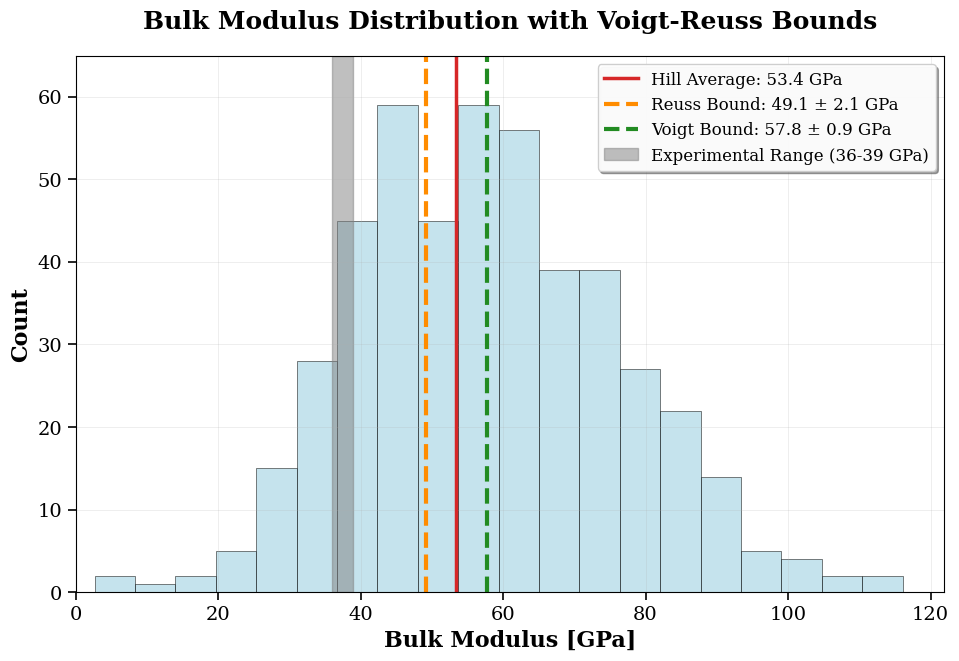

In [4]:
# Read all bulk modulus files and extract K0 values
bulk_moduli = []
failed_files = []

for bms_id in bms_ids:
    filename = f"{folder_path_weights}/bm_{bms_id}.txt"
    try:
        results = bm.analyze_bulk_modulus(filename, plot=False, save_dir=None)
        if results['K0'] > 0:  # Filter out negative values
            bulk_moduli.append(results['K0'])
    except:
        failed_files.append(bms_id)

bulk_moduli = np.array(bulk_moduli)
print(f"Successfully processed {len(bulk_moduli)} structures (after filtering negatives)")

# Perform Voigt-Reuss analysis
vr_results = bm.analyze_ensemble_bulk_modulus(bulk_moduli, volumes=None, plot=False)

# Create professional LaTeX-ready plot
plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

# Histogram with lighter blue background and thinner borders
counts, bins, patches = plt.hist(bulk_moduli, bins=20, alpha=0.7, color='lightblue', 
                                edgecolor='black', linewidth=0.5)

# Add vertical lines with orange and darker green
plt.axvline(vr_results['B_hill'], color='#d62728', linestyle='-', linewidth=2.5,
           label=f'Hill Average: {vr_results["B_hill"]:.1f} GPa')
plt.axvline(vr_results['B_reuss'], color='#ff8c00', linestyle='--', linewidth=3,
           label=f'Reuss Bound: {vr_results["B_reuss"]:.1f} ± {vr_results["B_reuss_err"]:.1f} GPa')
plt.axvline(vr_results['B_voigt'], color='#228b22', linestyle='--', linewidth=3,
           label=f'Voigt Bound: {vr_results["B_voigt"]:.1f} ± {vr_results["B_voigt_err"]:.1f} GPa')
plt.axvspan(36,39, alpha=0.5, color='gray', label='Experimental Range (36-39 GPa)')


# Professional styling
plt.xlabel('Bulk Modulus [GPa]', fontsize=16, fontweight='bold')
plt.ylabel('Count', fontsize=16, fontweight='bold')
plt.title('Bulk Modulus Distribution with Voigt-Reuss Bounds', fontsize=18, fontweight='bold', pad=20)

# Professional legend
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, 
          fontsize=12, framealpha=0.95)

# Grid styling
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Tick styling
plt.tick_params(axis='both', which='major', labelsize=14, width=1.2, length=6)
plt.tick_params(axis='both', which='minor', width=0.8, length=4)

# Tight layout with padding
plt.tight_layout(pad=1.5)

# Set axis limits for clean appearance
plt.xlim(0, max(bulk_moduli) * 1.05)
plt.ylim(0, max(counts) * 1.1)

plt.show()



CORRECTED MINIMUM ENERGY VOLUME SCALING ANALYSIS
Total structures analyzed: 478
Negative bulk modulus structures: 13

ALL STRUCTURES:
  -3%:    3 structures (  0.6%)
  -2%:    0 structures (  0.0%)
  -1%:    0 structures (  0.0%)
  +0%:  298 structures ( 62.3%)
  +1%:  165 structures ( 34.5%)
  +2%:    6 structures (  1.3%)
  +3%:    6 structures (  1.3%)

NEGATIVE BULK MODULUS STRUCTURES:
  -3%:    3 structures ( 23.1%)
  -2%:    0 structures (  0.0%)
  -1%:    0 structures (  0.0%)
  +0%:    0 structures (  0.0%)
  +1%:    2 structures ( 15.4%)
  +2%:    2 structures ( 15.4%)
  +3%:    6 structures ( 46.2%)


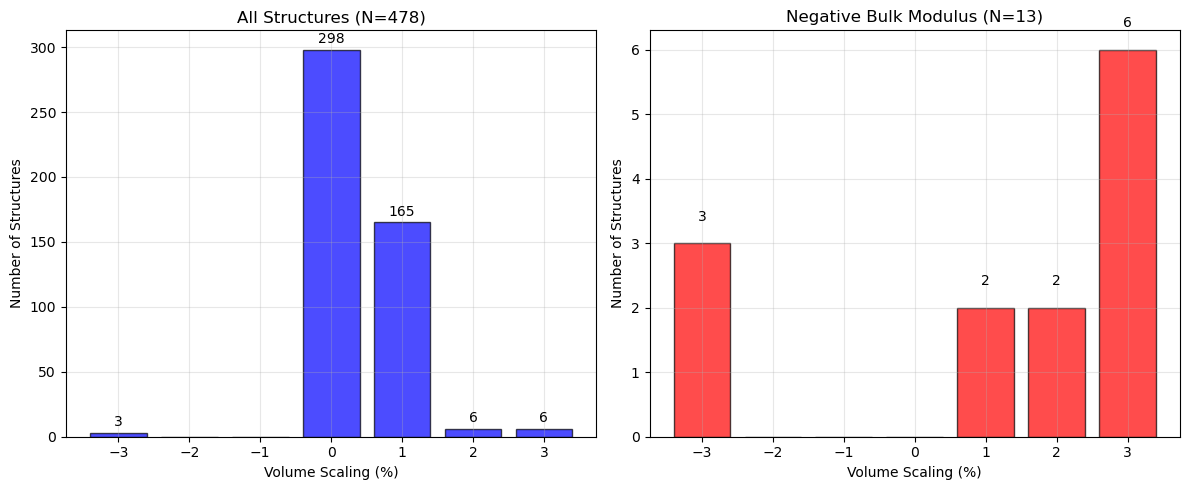

In [19]:
def create_corrected_binning_plot(df_energies, negative_ids):
    """
    Create the corrected binning plot based on actual minimum energy data
    """
    # Get the actual minimum energy scaling data
    all_min_scalings = df_energies['min_energy_scaling'].values
    
    # Get negative IDs minimum scalings
    negative_in_df = df_energies[df_energies['struct_id'].isin(negative_ids)]
    negative_min_scalings = negative_in_df['min_energy_scaling'].values
    
    # Bins for the 7 scaling percentages
    bins = [-3, -2, -1, 0, 1, 2, 3]
    
    # Count for all structures
    all_counts = [list(all_min_scalings).count(b) for b in bins]
    
    # Count for negative structures  
    neg_counts = [list(negative_min_scalings).count(b) for b in bins]
    
    print("CORRECTED MINIMUM ENERGY VOLUME SCALING ANALYSIS")
    print("="*50)
    print(f"Total structures analyzed: {len(all_min_scalings)}")
    print(f"Negative bulk modulus structures: {len(negative_min_scalings)}")
    print()
    
    print("ALL STRUCTURES:")
    for bin_val, count in zip(bins, all_counts):
        percent = count / len(all_min_scalings) * 100 if len(all_min_scalings) > 0 else 0
        print(f"  {bin_val:+2d}%: {count:4d} structures ({percent:5.1f}%)")
    
    print("\nNEGATIVE BULK MODULUS STRUCTURES:")
    for bin_val, count in zip(bins, neg_counts):
        percent = count / len(negative_min_scalings) * 100 if len(negative_min_scalings) > 0 else 0
        print(f"  {bin_val:+2d}%: {count:4d} structures ({percent:5.1f}%)")
    
    # Create corrected plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # All structures
    ax1.bar(bins, all_counts, alpha=0.7, color='blue', edgecolor='black')
    ax1.set_xlabel('Volume Scaling (%)')
    ax1.set_ylabel('Number of Structures')
    ax1.set_title(f'All Structures (N={len(all_min_scalings)})')
    ax1.grid(alpha=0.3)
    ax1.set_xticks(bins)
    
    # Add count labels on bars
    for i, count in enumerate(all_counts):
        if count > 0:
            ax1.text(bins[i], count + max(all_counts)*0.01, str(count), 
                    ha='center', va='bottom')
    
    # Negative bulk modulus structures
    ax2.bar(bins, neg_counts, alpha=0.7, color='red', edgecolor='black')
    ax2.set_xlabel('Volume Scaling (%)')
    ax2.set_ylabel('Number of Structures')
    ax2.set_title(f'Negative Bulk Modulus (N={len(negative_min_scalings)})')
    ax2.grid(alpha=0.3)
    ax2.set_xticks(bins)
    
    # Add count labels on bars
    for i, count in enumerate(neg_counts):
        if count > 0:
            ax2.text(bins[i], count + max(neg_counts)*0.05, str(count), 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return all_counts, neg_counts

# Create the corrected plot
all_counts, neg_counts = create_corrected_binning_plot(df_energies, negative_ids)

Voigt-Reuss Analysis for 0% Scaling Structures Only
Number of structures: 165
Valid bulk moduli: 165

Voigt-Reuss Bounds Analysis
Number of structures: 165
Reuss bound (lower): 39.7 ± 0.9 GPa
Voigt bound (upper): 42.2 ± 0.7 GPa
Hill average: 40.9 GPa
Range: 2.5 GPa (6.0%)
Individual K0 range: 16.5 - 76.7 GPa


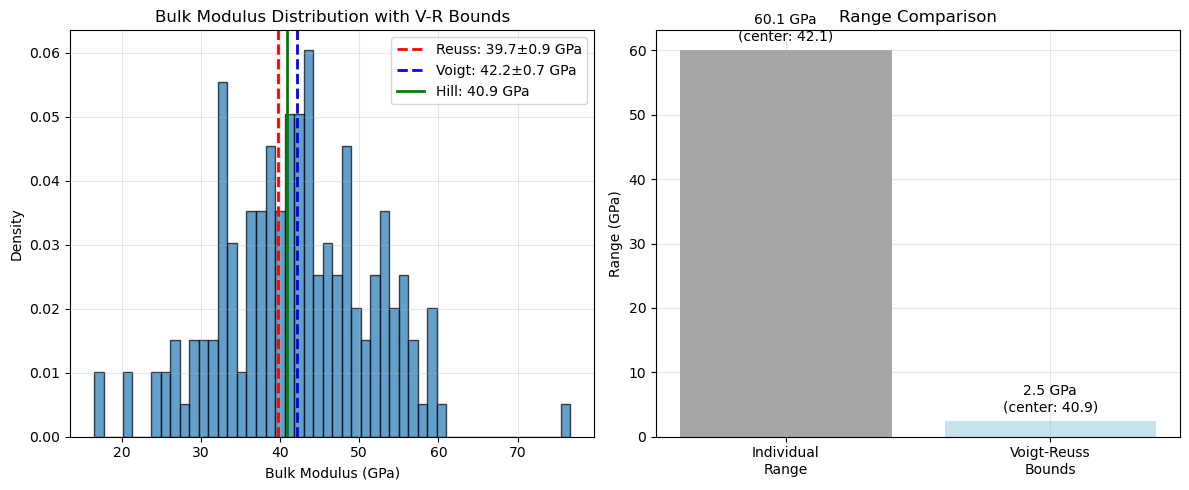


Voigt-Reuss Bounds Analysis
Number of structures: 480
Reuss bound (lower): 50.6 ± 2.3 GPa
Voigt bound (upper): 54.9 ± 1.4 GPa
Hill average: 52.7 GPa
Range: 4.3 GPa (8.2%)
Individual K0 range: -308.9 - 116.1 GPa


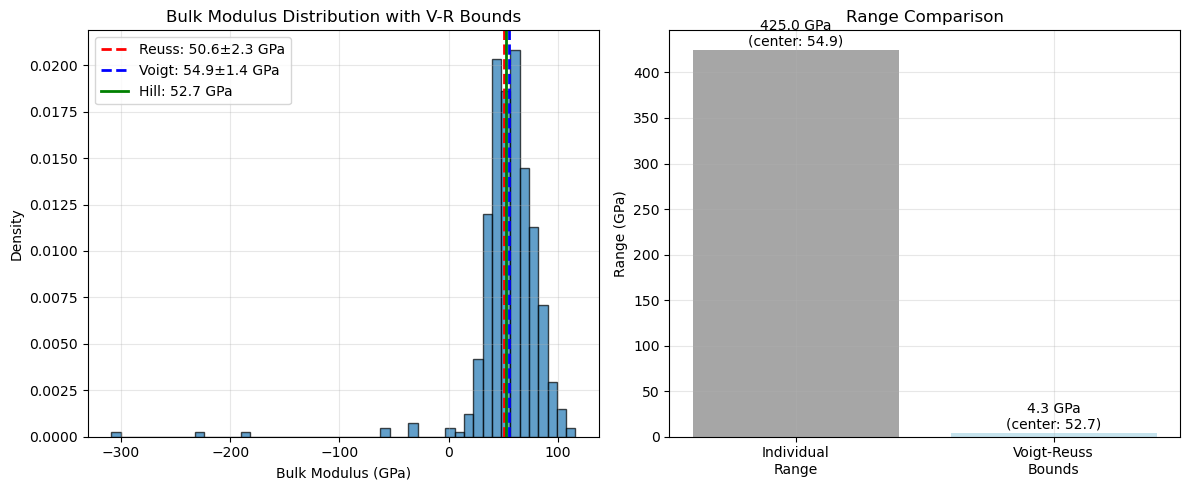

In [23]:
# Filter for structures with minimum energy at 0% scaling
zero_percent_ids = df_energies[df_energies['min_energy_scaling'] == 1]['struct_id'].values

# Get bulk moduli for these structures only
zero_percent_bulk_moduli = []
for struct_id in zero_percent_ids:
   filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
   try:
       K0, V0 = bm.quick_bulk_modulus(filename)
       if K0 > 0:  # Only positive bulk moduli
           zero_percent_bulk_moduli.append(K0)
   except:
       pass

zero_percent_bulk_moduli = np.array(zero_percent_bulk_moduli)

# Compute Voigt-Reuss bounds for 0% scaling structures only
print(f"Voigt-Reuss Analysis for 0% Scaling Structures Only")
print(f"Number of structures: {len(zero_percent_ids)}")
print(f"Valid bulk moduli: {len(zero_percent_bulk_moduli)}")

results_zero = bm.analyze_ensemble_bulk_modulus(zero_percent_bulk_moduli, plot=True)
results_zero = bm.analyze_ensemble_bulk_modulus(bulk_moduli, plot=True)

In [18]:
def create_bulk_modulus_dataframe(bms_ids, folder_path_weights):
    """
    Create DataFrame with all volumes/energies from BM runs
    Columns = volume scaling percentages, Rows = structure IDs
    Highlight minimum energy points in green
    """
    import pandas as pd
    import numpy as np
    
    # Store data for DataFrame
    data_dict = {'struct_id': []}
    scaling_percentages = [-3, -2, -1, 0, 1, 2, 3]
    
    # Initialize columns for volumes and energies
    for pct in scaling_percentages:
        data_dict[f'vol_{pct:+d}%'] = []
        data_dict[f'energy_{pct:+d}%'] = []
    
    data_dict['min_energy_scaling'] = []
    
    for struct_id in bms_ids:
        filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
        try:
            df = bm.parse_bulk_modulus_file(filename)
            
            if len(df) != 7:  # Skip if not exactly 7 points
                continue
                
            volumes = df['volume'].values
            energies = df['energy'].values
            
            # Sort by volume (smallest to largest)
            sorted_idx = np.argsort(volumes)
            volumes_sorted = volumes[sorted_idx]
            energies_sorted = energies[sorted_idx]
            
            # Add to data dictionary
            data_dict['struct_id'].append(struct_id)
            
            # Assign sorted volumes/energies to scaling percentages
            for i, pct in enumerate(scaling_percentages):
                data_dict[f'vol_{pct:+d}%'].append(volumes_sorted[i])
                data_dict[f'energy_{pct:+d}%'].append(energies_sorted[i])
            
            # Find which scaling has minimum energy
            min_energy_idx = np.argmin(energies_sorted)
            min_scaling = scaling_percentages[min_energy_idx]
            data_dict['min_energy_scaling'].append(min_scaling)
            
        except Exception as e:
            print(f"Skipping ID {struct_id}: {e}")
            continue
    
    # Create DataFrame
    df_full = pd.DataFrame(data_dict)
    
    # Create a simplified view showing just energies with highlighting
    energy_cols = [f'energy_{pct:+d}%' for pct in scaling_percentages]
    df_energies = df_full[['struct_id'] + energy_cols + ['min_energy_scaling']].copy()
    
    # Round energies for display
    for col in energy_cols:
        df_energies[col] = df_energies[col].round(6)
    
    print(f"Bulk Modulus Energy Data (first 20 structures)")
    print("="*100)
    
    # Print summary statistics
    print(f"\nSummary of minimum energy scaling distribution:")
    min_scaling_counts = df_energies['min_energy_scaling'].value_counts().sort_index()
    for scaling, count in min_scaling_counts.items():
        pct = count / len(df_energies) * 100
        print(f"  {int(scaling):+2d}%: {count:3d} structures ({pct:5.1f}%)")
    
    # Show some examples manually highlighted
    print(f"\nFirst 10 structures with minimum energy points marked:")
    print("-" * 120)
    header = f"{'ID':>4} " + " ".join([f'{pct:+2d}%'.center(12) for pct in scaling_percentages]) + f" {'Min@':>6}"
    print(header)
    print("-" * 120)
    
    for i in range(min(10, len(df_energies))):
        row = df_energies.iloc[i]
        struct_id = int(row['struct_id'])
        min_scaling = int(row['min_energy_scaling'])  # Convert to int
        
        # Print row with * marking minimum
        row_str = f"{struct_id:4d} "
        for pct in scaling_percentages:
            energy_val = row[f'energy_{pct:+d}%']
            if pct == min_scaling:
                row_str += f"*{energy_val:10.6f}* "
            else:
                row_str += f" {energy_val:10.6f}  "
        row_str += f"{min_scaling:+3d}%"
        print(row_str)
    
    # Check negative_ids specifically
    if 'negative_ids' in globals():
        print(f"\nNegative bulk modulus structures:")
        print("-" * 120)
        print(header)
        print("-" * 120)
        
        negative_in_df = df_energies[df_energies['struct_id'].isin(negative_ids)]
        for i, (idx, row) in enumerate(negative_in_df.iterrows()):
            if i >= 10:  # Limit to first 10
                break
            struct_id = int(row['struct_id'])
            min_scaling = int(row['min_energy_scaling'])  # Convert to int
            
            row_str = f"{struct_id:4d} "
            for pct in scaling_percentages:
                energy_val = row[f'energy_{pct:+d}%']
                if pct == min_scaling:
                    row_str += f"*{energy_val:10.6f}* "
                else:
                    row_str += f" {energy_val:10.6f}  "
            row_str += f"{min_scaling:+3d}%"
            print(row_str)
    
    return df_full, df_energies

# Create the DataFrame
df_full, df_energies = create_bulk_modulus_dataframe(bms_ids, folder_path_weights)

Skipping ID 1564: 'status'
Bulk Modulus Energy Data (first 20 structures)

Summary of minimum energy scaling distribution:
  -3%:   3 structures (  0.6%)
  +0%: 298 structures ( 62.3%)
  +1%: 165 structures ( 34.5%)
  +2%:   6 structures (  1.3%)
  +3%:   6 structures (  1.3%)

First 10 structures with minimum energy points marked:
------------------------------------------------------------------------------------------------------------------------
  ID     -3%          -2%          -1%          +0%          +1%          +2%          +3%        Min@
------------------------------------------------------------------------------------------------------------------------
   8  -1042.711866   -1042.716005   -1042.718629  *-1042.719750*  -1042.719384   -1042.717560   -1042.714268   +0%
  21  -1042.197311   -1042.199953   -1042.201697  *-1042.202563*  -1042.202556   -1042.201692   -1042.199996   +0%
  24  -1042.622766   -1042.625696   -1042.627545  *-1042.628360*  -1042.628172   -1042.6270

In [9]:
# Find IDs with negative bulk moduli
negative_ids = []
for struct_id in bms_ids:
   filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
   try:
       K0, V0 = bm.quick_bulk_modulus(filename)
       if K0 <= 20:
           negative_ids.append(struct_id)
   except:
       pass

print(f"Found {len(negative_ids)} IDs with negative bulk moduli:")
print(negative_ids[:20] if len(negative_ids) > 20 else negative_ids)

Found 13 IDs with negative bulk moduli:
[307, 455, 797, 848, 897, 1053, 1086, 1152, 1273, 1703, 2162, 2264, 2822]



Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_307.txt
Data points: 7
Volume range: 6.0%
Energy range: 39.1 meV

Results (parabolic):
  V₀ = 376.46 Å³
  K₀ = 17.5 GPa
  R² = 0.9999

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_455.txt
Data points: 7
Volume range: 6.0%
Energy range: 44.7 meV

Results (parabolic):
  V₀ = 352.08 Å³
  K₀ = 2.7 GPa
  R² = 0.0872

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_797.txt
Data points: 7
Volume range: 6.0%
Energy range: 34.7 meV

Results (parabolic):
  V₀ = 412.67 Å³
  K₀ = 16.5 GPa
  R² = 0.9999

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_848.txt
Data points: 7
Volume range: 6.0%
Energy range: 442.5 meV

Results (parabolic):
  V₀ = 303.22 Å³
  K₀ = -224.2 GPa
  R² = 0.6392

Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/bms/bm_897.txt
Data points: 7
Volume ra

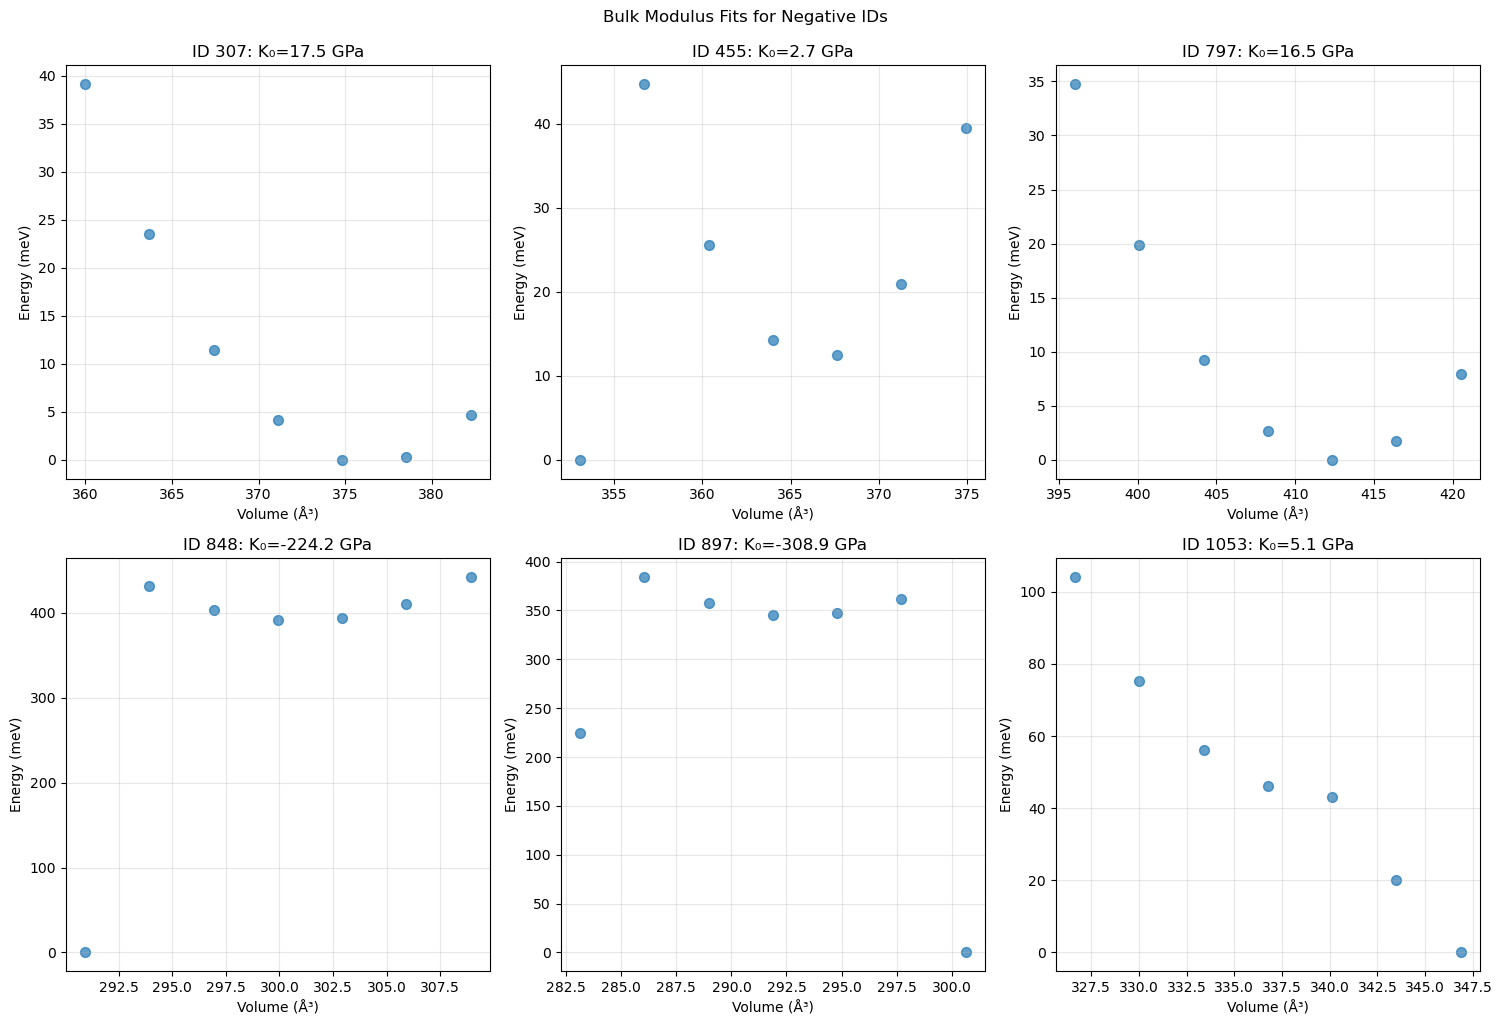

In [15]:
# Plot bulk modulus fits for negative IDs
import matplotlib.pyplot as plt
positive_ids = [id for id in bms_ids if id not in negative_ids]
# Show first few negative IDs
n_plots = min(6, len(negative_ids))  # Show up to 6 plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, struct_id in enumerate(negative_ids[:n_plots]):
   filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
   try:
       results = bm.analyze_bulk_modulus(filename, plot=False)
       
       # Plot on subplot
       ax = axes[i]
       V = results['volumes']
       E_ev = results['energies_ev']
       E_rel = (E_ev - E_ev.min()) * 1000  # meV
       
       ax.scatter(V, E_rel, alpha=0.7, s=50)
       
       # Plot fit if available
       if 'fit_volumes' in results:
           V_fit = results['fit_volumes']
           E_fit_rel = (results['fit_energies'] - E_ev.min()) * 1000
           ax.plot(V_fit, E_fit_rel, 'r-', linewidth=2)
       
       ax.set_title(f'ID {struct_id}: K₀={results["K0"]:.1f} GPa')
       ax.set_xlabel('Volume (Å³)')
       ax.set_ylabel('Energy (meV)')
       ax.grid(alpha=0.3)
       
   except Exception as e:
       axes[i].text(0.5, 0.5, f'ID {struct_id}\nFailed: {str(e)[:30]}...', 
                   ha='center', va='center', transform=axes[i].transAxes)

# Hide unused subplots
for i in range(n_plots, len(axes)):
   axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle(f'Bulk Modulus Fits for Negative IDs', y=1.02)
plt.show()

In [11]:
def investigate_problematic_fits(negative_ids, folder_path_weights, n_investigate=5):
    """
    Investigate why certain IDs give bad bulk modulus fits
    """
    import pandas as pd
    
    for i, struct_id in enumerate(negative_ids[:n_investigate]):
        print(f"\n{'='*60}")
        print(f"INVESTIGATING ID {struct_id}")
        print(f"{'='*60}")
        
        filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
        
        # Read raw data
        try:
            df = bm.parse_bulk_modulus_file(filename)
            print(f"Raw data points: {len(df)}")
            print(df)
            
            # Check for data quality issues
            volumes = df['volume'].values
            energies = df['energy'].values
            
            # Check volume range
            V_range_percent = (volumes.max() - volumes.min()) / volumes.mean() * 100
            print(f"\nVolume range: {V_range_percent:.2f}%")
            print(f"Volume values: {volumes}")
            
            # Check energy spread
            E_range_mev = (energies.max() - energies.min()) * 27211.4  # Ry to meV
            print(f"Energy range: {E_range_mev:.1f} meV")
            print(f"Energy values (Ry): {energies}")
            
            # Check for outliers
            E_mean = energies.mean()
            E_std = energies.std()
            outliers = np.abs(energies - E_mean) > 2 * E_std
            if np.any(outliers):
                print(f"\nPOTENTIAL OUTLIERS:")
                for j, is_outlier in enumerate(outliers):
                    if is_outlier:
                        print(f"  Point {j}: V={volumes[j]:.2f}, E={energies[j]:.6f} Ry")
            
            # Check if volumes are properly ordered
            sorted_order = np.argsort(volumes)
            if not np.array_equal(sorted_order, np.arange(len(volumes))):
                print(f"\nVolumes not in ascending order!")
                print(f"Proper order should be: {sorted_order}")
            
            # Check for duplicate volumes
            unique_volumes = np.unique(volumes)
            if len(unique_volumes) != len(volumes):
                print(f"\nDUPLICATE VOLUMES FOUND!")
                print(f"Unique volumes: {len(unique_volumes)}, Total: {len(volumes)}")
            
            # Try different fitting methods
            print(f"\nTRYING DIFFERENT FITS:")
            try:
                results = bm.fit_eos_robust(volumes, energies)
                print(f"  Robust fit: K0 = {results['K0']:.1f} GPa, R² = {results['r_squared']:.3f}")
            except Exception as e:
                print(f"  Robust fit failed: {e}")
            
            # Try with outlier removal
            if np.any(outliers):
                print(f"  Trying with outliers removed...")
                clean_V = volumes[~outliers]
                clean_E = energies[~outliers]
                if len(clean_V) >= 4:
                    try:
                        clean_results = bm.fit_eos_robust(clean_V, clean_E)
                        print(f"  Clean fit: K0 = {clean_results['K0']:.1f} GPa, R² = {clean_results['r_squared']:.3f}")
                    except Exception as e:
                        print(f"  Clean fit failed: {e}")
                else:
                    print(f"  Not enough points after outlier removal: {len(clean_V)}")
            
        except Exception as e:
            print(f"Failed to read file: {e}")

# Quick data quality check for all negative IDs
def quick_quality_check(negative_ids, folder_path_weights):
    """Quick overview of data quality issues"""
    issues = {
        'too_few_points': [],
        'large_outliers': [],
        'small_energy_range': [],
        'duplicate_volumes': [],
        'file_errors': []
    }
    
    for struct_id in negative_ids:
        filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
        try:
            df = bm.parse_bulk_modulus_file(filename)
            volumes = df['volume'].values
            energies = df['energy'].values
            
            # Check issues
            if len(df) < 5:
                issues['too_few_points'].append(struct_id)
            
            if len(np.unique(volumes)) != len(volumes):
                issues['duplicate_volumes'].append(struct_id)
            
            E_range_mev = (energies.max() - energies.min()) * 27211.4
            if E_range_mev < 10:  # Less than 10 meV range
                issues['small_energy_range'].append(struct_id)
            
            E_std = energies.std()
            if np.any(np.abs(energies - energies.mean()) > 3 * E_std):
                issues['large_outliers'].append(struct_id)
                
        except Exception as e:
            issues['file_errors'].append((struct_id, str(e)))
    
    print("DATA QUALITY ISSUES SUMMARY:")
    print("="*40)
    for issue_type, problem_ids in issues.items():
        if problem_ids:
            print(f"{issue_type}: {len(problem_ids)} IDs")
            if issue_type == 'file_errors':
                for struct_id, error in problem_ids[:3]:
                    print(f"  ID {struct_id}: {error}")
            else:
                print(f"  {problem_ids[:10]}")  # Show first 10
    
    return issues

# Run the investigation
print("Running detailed investigation...")
investigate_problematic_fits(negative_ids, folder_path_weights)

print("\n" + "="*60)
print("QUICK QUALITY CHECK")
issues = quick_quality_check(negative_ids, folder_path_weights)

Running detailed investigation...

INVESTIGATING ID 307
Raw data points: 7
       volume       energy   status
0  371.120052 -1042.294214  SUCCESS
1  367.408852 -1042.293674  SUCCESS
2  374.831253 -1042.294518  SUCCESS
3  363.697651 -1042.292786  SUCCESS
4  378.542453 -1042.294492  SUCCESS
5  359.986451 -1042.291643  SUCCESS
6  382.253654 -1042.294174  SUCCESS

Volume range: 6.00%
Volume values: [371.120052 367.408852 374.831253 363.697651 378.542453 359.986451
 382.253654]
Energy range: 78.2 meV
Energy values (Ry): [-1042.29421449 -1042.29367422 -1042.29451787 -1042.29278607
 -1042.29449199 -1042.2916425  -1042.29417407]

POTENTIAL OUTLIERS:
  Point 5: V=359.99, E=-1042.291643 Ry

Volumes not in ascending order!
Proper order should be: [5 3 1 0 2 4 6]

TRYING DIFFERENT FITS:
  Robust fit: K0 = 17.5 GPa, R² = 1.000
  Trying with outliers removed...
  Clean fit: K0 = 17.7 GPa, R² = 1.000

INVESTIGATING ID 455
Raw data points: 7
       volume       energy   status
0  364.004587 -1042.272

In [14]:
# Find a "good" structure for comparison
good_ids = [id for id in bms_ids if id not in negative_ids][:5]
print("Checking some 'good' structures for comparison:")
for struct_id in good_ids:
    try:
        K0, V0 = bm.quick_bulk_modulus(os.path.join(folder_path_weights, f"bm_{struct_id}.txt"))
        if 20 < K0 < 100:  # Reasonable range
            print(f"\nGood structure ID {struct_id}: K0 = {K0:.1f} GPa")
            check_energy_scales(struct_id, folder_path_weights)
            break
    except:
        continue

Checking some 'good' structures for comparison:

Good structure ID 21: K0 = 55.2 GPa
ID 21 - Raw energy differences:
Volume range: 334.1 to 354.8 Å³
Energy range: 0.005252 Ry = 142.9 meV
Min energy: -1042.202563 Ry
Max energy: -1042.197311 Ry

All points relative to minimum:
  Point 0: V=334.1 Å³, E_rel=142.9 meV
  Point 1: V=337.6 Å³, E_rel=71.0 meV
  Point 2: V=341.0 Å³, E_rel=23.6 meV
  Point 3: V=344.5 Å³, E_rel=0.0 meV
  Point 4: V=347.9 Å³, E_rel=0.2 meV
  Point 5: V=351.4 Å³, E_rel=23.7 meV
  Point 6: V=354.8 Å³, E_rel=69.9 meV



Voigt-Reuss Bounds Analysis
Number of structures: 480
Reuss bound (lower): 50.5 ± 2.3 GPa
Voigt bound (upper): 54.9 ± 1.4 GPa
Hill average: 52.7 GPa
Range: 4.3 GPa (8.2%)
Individual K0 range: -308.9 - 116.1 GPa


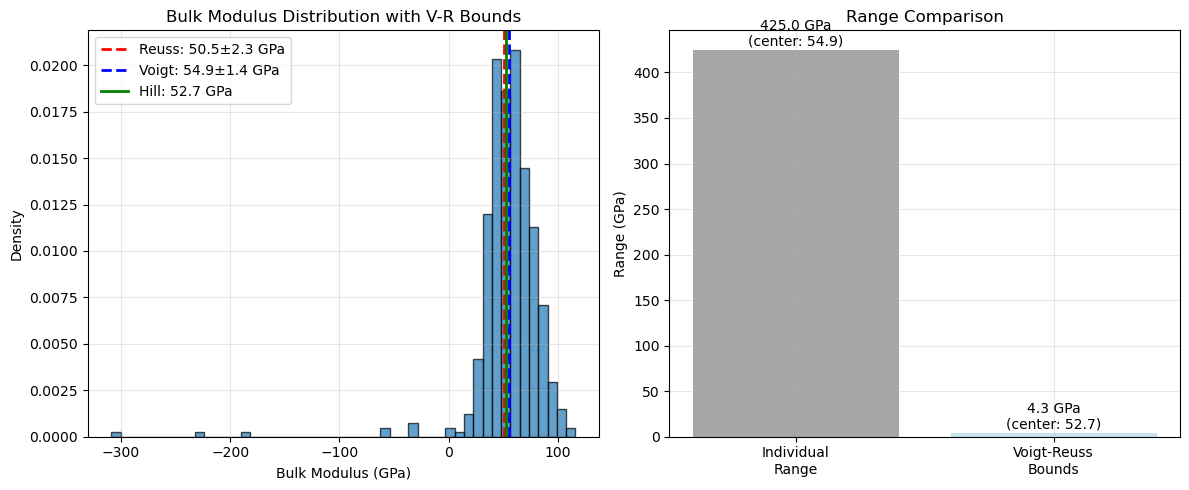

Effective bulk modulus range: 50.6 - 54.9 GPa


In [3]:
# Get bulk moduli
bulk_moduli = []
for struct_id in bms_ids:
    filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
    try:
        K0, V0 = bm.quick_bulk_modulus(filename)
        bulk_moduli.append(K0)
    except:
        pass

bulk_moduli = np.array(bulk_moduli)

# After loading your bulk_moduli array
results = bm.analyze_ensemble_bulk_modulus(bulk_moduli, plot=True)

# Or just get the bounds
bounds = bm.calculate_voigt_reuss_bounds(bulk_moduli)
print(f"Effective bulk modulus range: {bounds['B_reuss']:.1f} - {bounds['B_voigt']:.1f} GPa")

N = 472, Range: 2.7 - 116.1 GPa, Mean: 57.8 ± 18.4 GPa


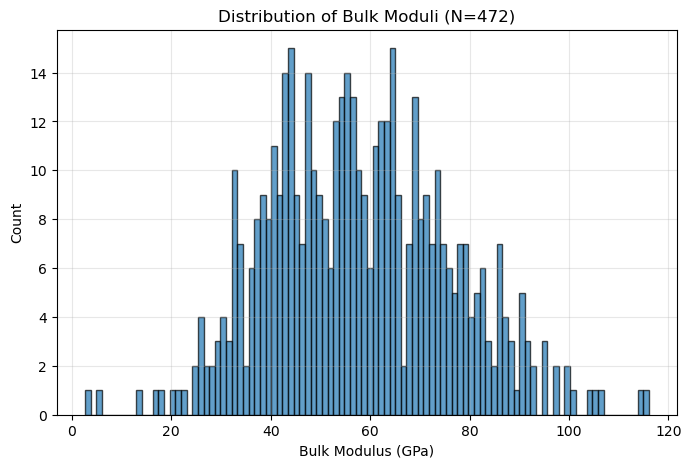

In [11]:
# Get bulk moduli
bulk_moduli = []
for struct_id in bms_ids:
    filename = os.path.join(folder_path_weights, f"bm_{struct_id}.txt")
    try:
        K0, V0 = bm.quick_bulk_modulus(filename)
        bulk_moduli.append(K0)
    except:
        pass

bulk_moduli = np.array(bulk_moduli)

bulk_moduli = bulk_moduli[bulk_moduli > 0]  # Remove negative/unphysical values
# Quick stats and histogram
print(f"N = {len(bulk_moduli)}, Range: {bulk_moduli.min():.1f} - {bulk_moduli.max():.1f} GPa, Mean: {bulk_moduli.mean():.1f} ± {bulk_moduli.std():.1f} GPa")

plt.figure(figsize=(8, 5))
plt.hist(bulk_moduli, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('Bulk Modulus (GPa)')
plt.ylabel('Count')
plt.title(f'Distribution of Bulk Moduli (N={len(bulk_moduli)})')
plt.grid(alpha=0.3)
plt.show()

Found 11 structures to analyze


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/10_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 88.6 meV

Results (parabolic):
  V₀ = 344.19 Å³
  K₀ = 72.2 GPa
  R² = 1.0000


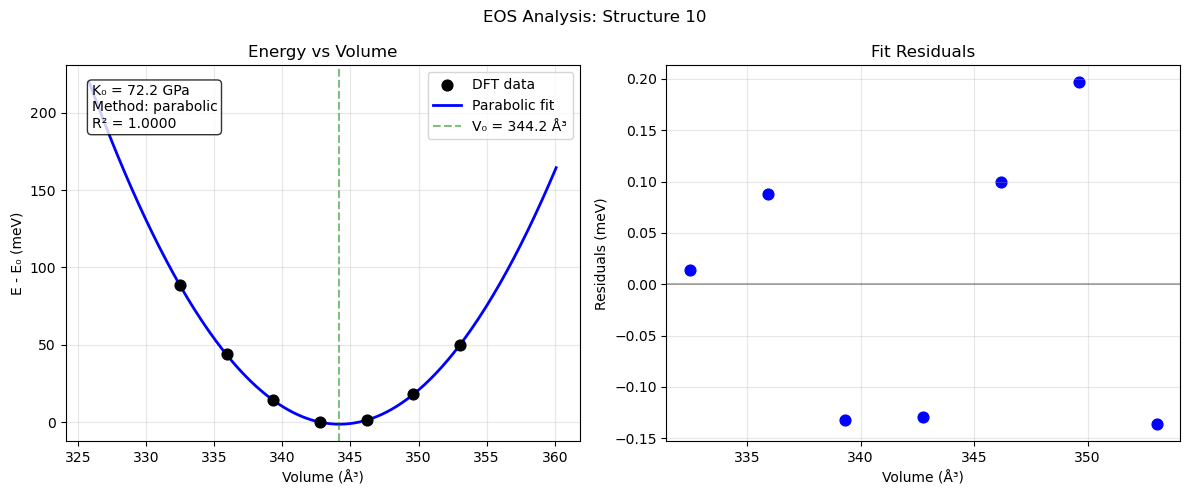


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/11_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 61.2 meV

Results (parabolic):
  V₀ = 327.70 Å³
  K₀ = 46.2 GPa
  R² = 0.9994


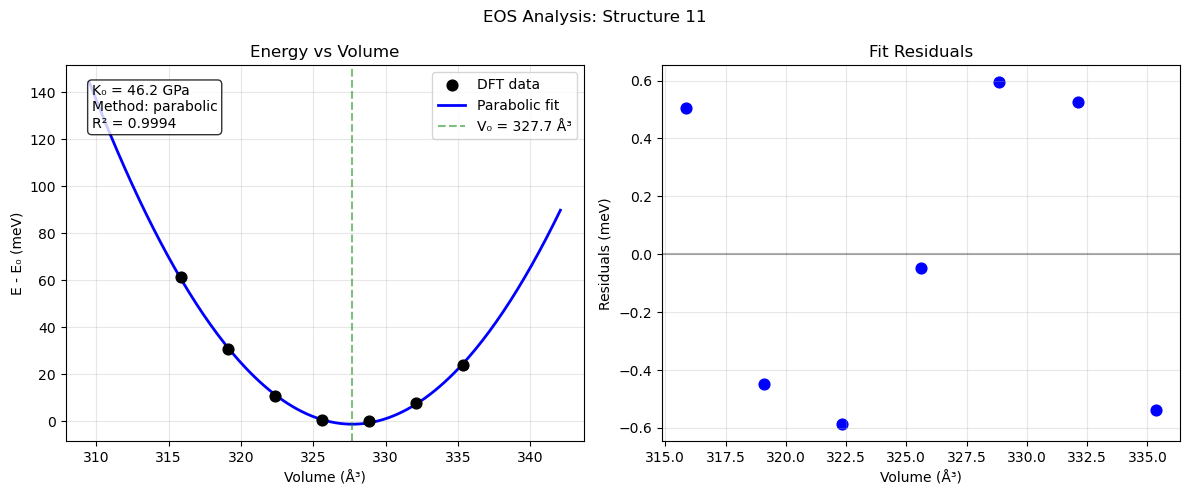


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/1261_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 84.6 meV

Results (parabolic):
  V₀ = 281.92 Å³
  K₀ = 85.3 GPa
  R² = 0.9998


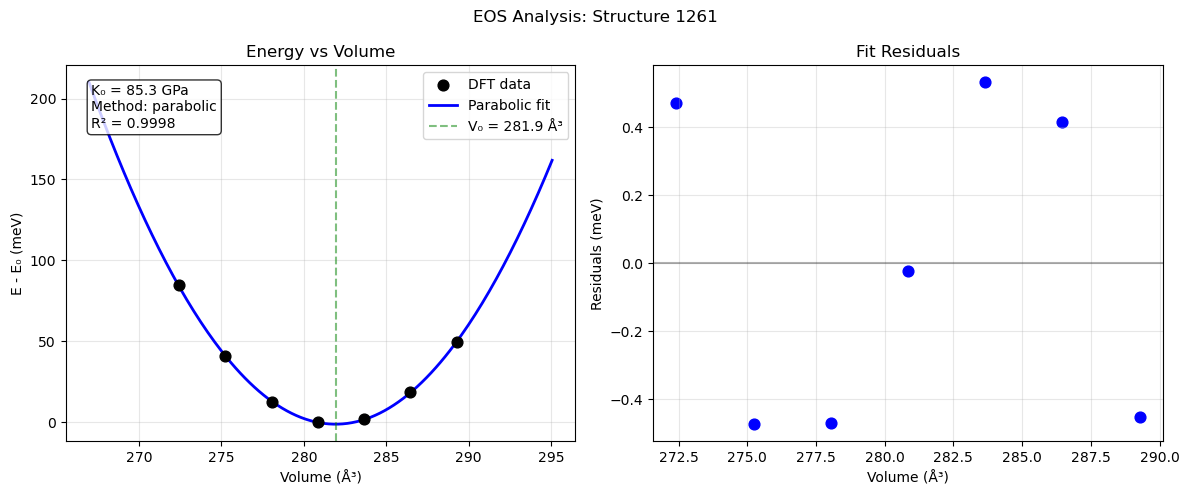


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/1265_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 97.4 meV

Results (parabolic):
  V₀ = 279.27 Å³
  K₀ = 99.8 GPa
  R² = 0.9996


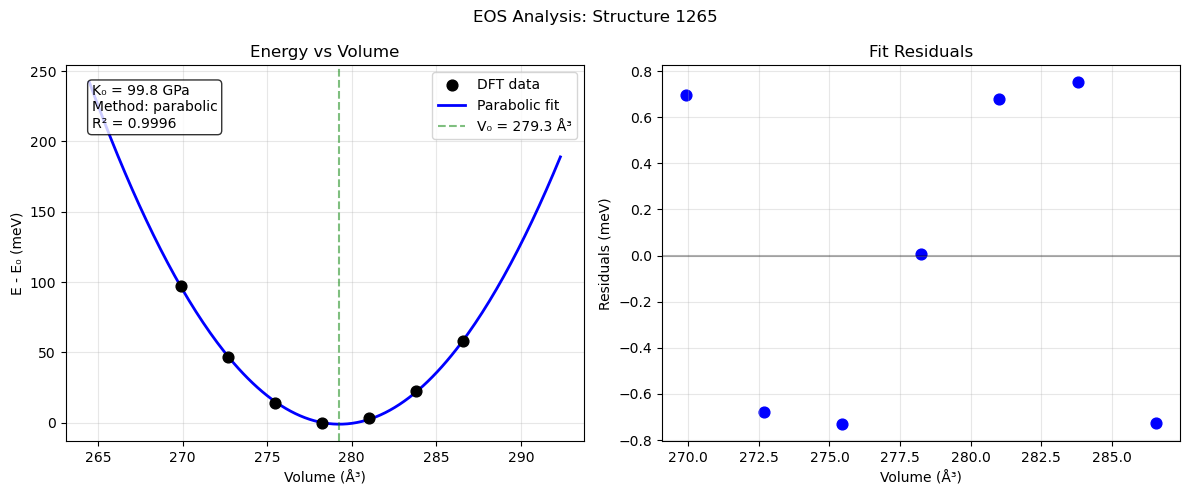


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/1809_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 55.6 meV

Results (parabolic):
  V₀ = 343.21 Å³
  K₀ = 40.7 GPa
  R² = 1.0000


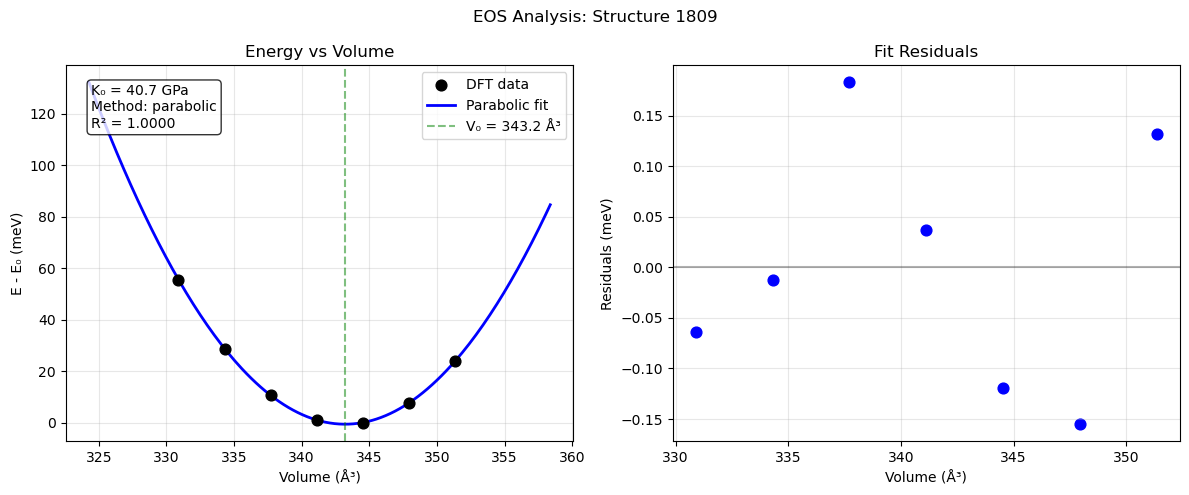


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/20_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 77.9 meV

Results (parabolic):
  V₀ = 326.61 Å³
  K₀ = 64.7 GPa
  R² = 0.9998


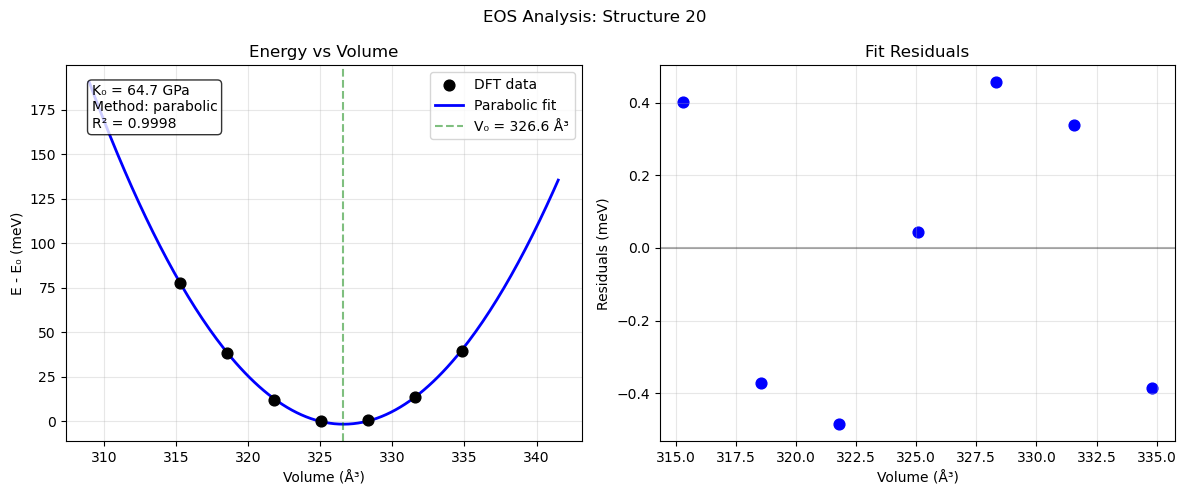


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/2405_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 67.8 meV

Results (parabolic):
  V₀ = 316.88 Å³
  K₀ = 56.5 GPa
  R² = 0.9998


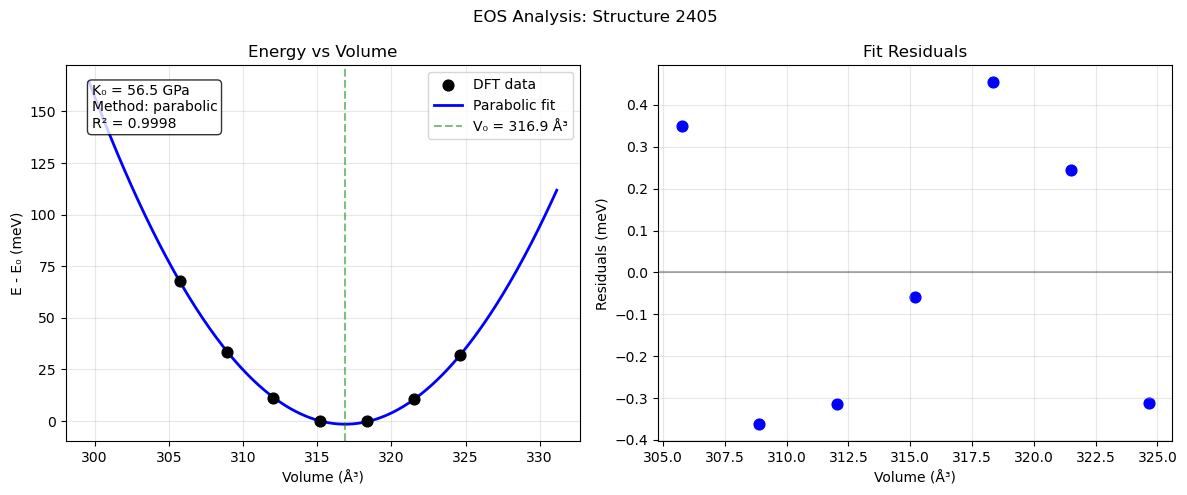


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/2407_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 62.1 meV

Results (parabolic):
  V₀ = 364.84 Å³
  K₀ = 42.7 GPa
  R² = 0.9999


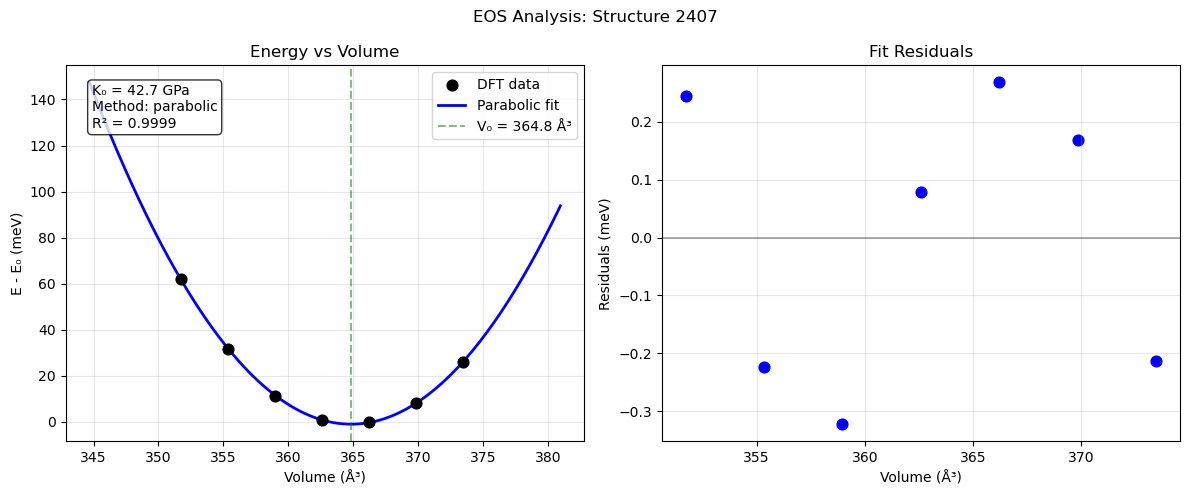


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/734_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 83.3 meV

Results (parabolic):
  V₀ = 300.54 Å³
  K₀ = 78.3 GPa
  R² = 0.9996


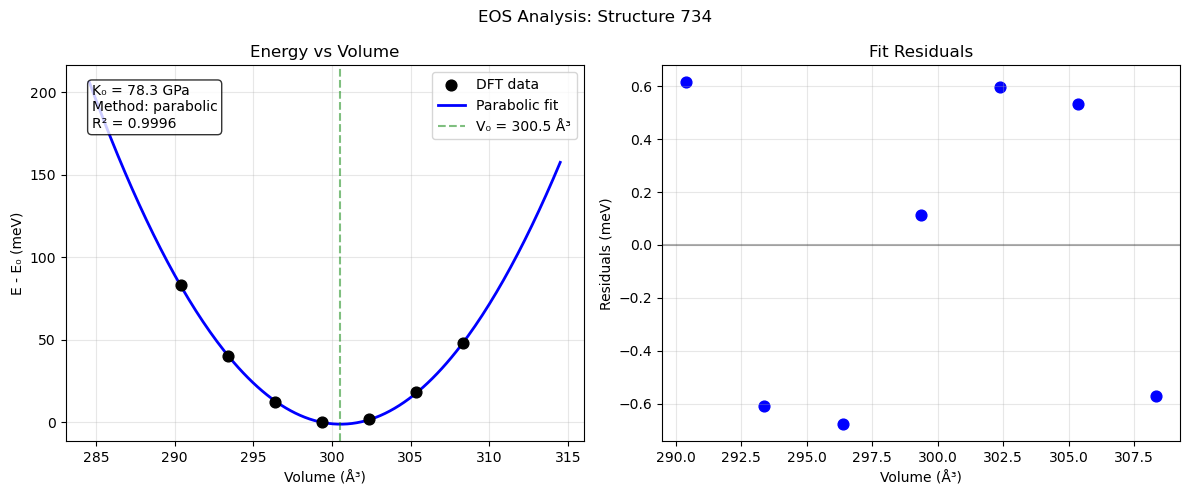


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/746_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 58.8 meV

Results (parabolic):
  V₀ = 327.33 Å³
  K₀ = 47.3 GPa
  R² = 0.9995


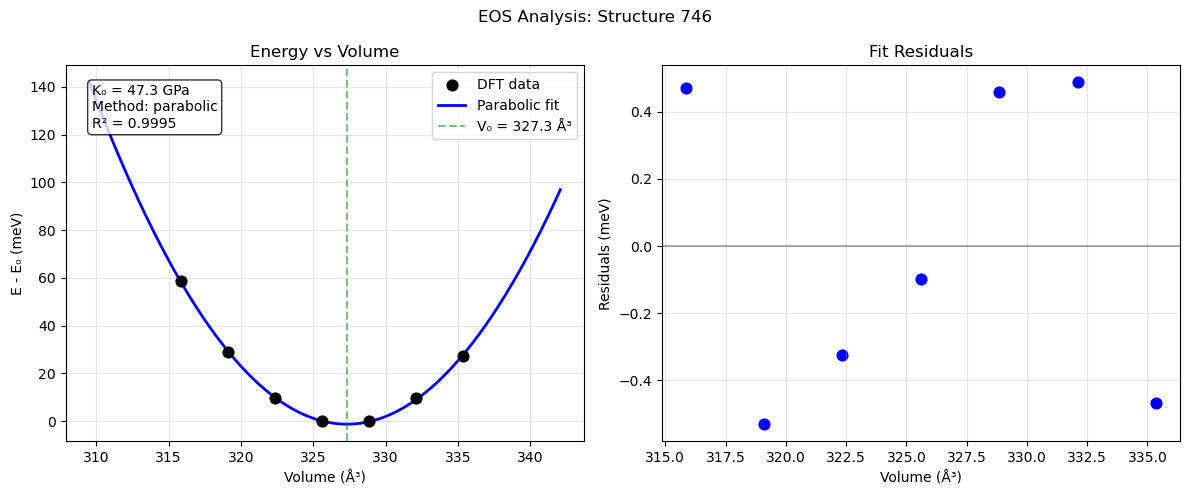


Analyzing: /Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/8_bulk_modulus_summary.txt
Data points: 7
Volume range: 6.0%
Energy range: 107.3 meV

Results (parabolic):
  V₀ = 280.38 Å³
  K₀ = 116.1 GPa
  R² = 1.0000


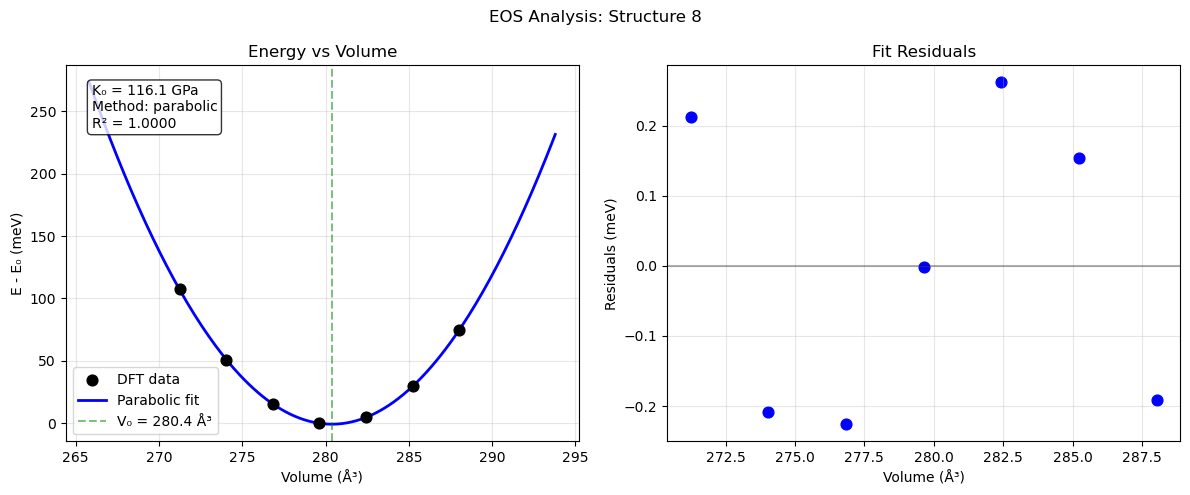


SUMMARY OF ALL STRUCTURES
Structure  V0 (Å³)  K0 (GPa)   R²    Method  V_range (%)
       10   344.19     72.18 1.00 parabolic         6.00
       11   327.70     46.19 1.00 parabolic         6.00
     1261   281.92     85.29 1.00 parabolic         6.00
     1265   279.27     99.81 1.00 parabolic         6.00
     1809   343.21     40.69 1.00 parabolic         6.00
       20   326.61     64.69 1.00 parabolic         6.00
     2405   316.88     56.50 1.00 parabolic         6.00
     2407   364.84     42.71 1.00 parabolic         6.00
      734   300.54     78.33 1.00 parabolic         6.00
      746   327.33     47.31 1.00 parabolic         6.00
        8   280.38    116.07 1.00 parabolic         6.00


In [3]:
all_results = bm2.batch_analysis("/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/*_bulk_modulus_summary.txt")

In [5]:
#!/usr/bin/env python3
"""
VASP QUESTS Entropy Analysis Functions
======================================

Functions to compute information entropy on VASP structures using QUESTS.
Designed to integrate with existing ensemble analysis pipeline.

Usage:
    from quests_analysis import compute_entropy_analysis, entropy_sampling

Author: Assistant
Based on: Schwalbe-Koda et al. 2024 - Model-free quantification of completeness...
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Existing imports from your pipeline
from src.data_management_v2 import load_structures, load_energies

# QUESTS imports (actual API)
try:
    from quests import entropy, descriptor, matrix
    from quests.tools import plotting
except ImportError:
    print("QUESTS not found. Install with: pip install git+https://github.com/dskoda/quests.git")
    raise


def compute_entropy_analysis(struct_ids, k_neighbors=32, cutoff=5.0, bandwidth=0.015, 
                           save_descriptors=False):
    """
    Compute QUESTS information entropy analysis for a set of structures.
    
    Parameters:
    -----------
    struct_ids : list of int
        Structure IDs to analyze (should exist in your data pipeline)
    k_neighbors : int
        Number of nearest neighbors for descriptor (default: 32)
    cutoff : float  
        Cutoff radius in Angstroms (default: 5.0)
    bandwidth : float
        Bandwidth for KDE in A^-1 (default: 0.015) 
    save_descriptors : bool
        Whether to save computed descriptors
        
    Returns:
    --------
    dict : Results containing entropy values, descriptors, etc.
    """
    print(f"Computing QUESTS entropy analysis for {len(struct_ids)} structures")
    print(f"Parameters: k={k_neighbors}, cutoff={cutoff}Å, bandwidth={bandwidth}Å⁻¹")
    
    # Load structures using existing pipeline
    print("Loading structures...")
    structures_dict = load_structures(struct_ids)
    valid_ids = [sid for sid in struct_ids if sid in structures_dict]
    
    if not valid_ids:
        raise ValueError("No valid structures found!")
    
    print(f"Loaded {len(valid_ids)} valid structures")
    
    # Convert pymatgen structures to format QUESTS expects
    print("Converting structures for QUESTS...")
    from pymatgen.io.ase import AseAtomsAdaptor
    
    atoms_list = []
    adaptor = AseAtomsAdaptor()
    
    for sid in valid_ids:
        structure = structures_dict[sid]
        # Convert pymatgen Structure to ASE Atoms (QUESTS expects ASE format)
        atoms = adaptor.get_atoms(structure)
        atoms_list.append(atoms)
    
    # Compute descriptors using QUESTS
    print("Computing atomic environment descriptors...")
    descriptors = descriptor.get_descriptors(
        atoms_list, 
        k=k_neighbors, 
        cutoff=cutoff,
        concat=True
    )
    print(f"Computed descriptors shape: {descriptors.shape}")
    
    # Compute total entropy
    print("Computing information entropy...")
    H_total = entropy.entropy(descriptors, h=bandwidth)
    
    # Compute differential entropy for each structure
    print("Computing differential entropies...")
    delta_H_values = []
    
    # Get number of environments per structure to split descriptors
    env_counts = [len(atoms) for atoms in atoms_list]
    start_idx = 0
    
    for i, (struct_id, count) in enumerate(tqdm(zip(valid_ids, env_counts), desc="Computing δH")):
        # Get descriptors for this structure's environments
        end_idx = start_idx + count
        struct_descriptors = descriptors[start_idx:end_idx]
        
        # Get reference descriptors (all others)
        if len(descriptors) > count:
            other_indices = list(range(len(descriptors)))
            struct_indices = list(range(start_idx, end_idx))
            ref_indices = [idx for idx in other_indices if idx not in struct_indices]
            reference_descriptors = descriptors[ref_indices]
            
            # Compute differential entropy for this structure
            delta_H = entropy.delta_entropy(
                struct_descriptors, 
                reference_descriptors, 
                h=bandwidth
            )
            delta_H_values.append(np.mean(delta_H))  # Average over environments
        else:
            delta_H_values.append(0.0)
        
        start_idx = end_idx
    
    # Load energies for correlation analysis
    energies_dict = load_energies(valid_ids)
    energies = [energies_dict.get(sid, np.nan) for sid in valid_ids]
    
    # Compile results
    results = {
        'struct_ids': valid_ids,
        'total_entropy': H_total,
        'differential_entropies': np.array(delta_H_values),
        'energies': np.array(energies),
        'descriptors': descriptors if save_descriptors else None,
        'parameters': {
            'k_neighbors': k_neighbors,
            'cutoff': cutoff,
            'bandwidth': bandwidth,
            'n_structures': len(valid_ids),
            'descriptor_dim': descriptors.shape[1] if descriptors is not None else None
        }
    }
    
    # Create summary DataFrame
    results['summary_df'] = pd.DataFrame({
        'struct_id': valid_ids,
        'delta_H': delta_H_values,
        'energy': energies,
        'novelty_rank': np.argsort(np.argsort(-np.array(delta_H_values))) + 1
    })
    
    print(f"Analysis complete!")
    print(f"Total entropy: {H_total:.3f} nats")
    print(f"Mean δH: {np.mean(delta_H_values):.3f} ± {np.std(delta_H_values):.3f} nats")
    
    return results


def entropy_sampling(struct_ids, sample_size=100, method='high_entropy', **entropy_kwargs):
    """
    Sample structures based on entropy criteria using QUESTS.
    
    Parameters:
    -----------
    struct_ids : list of int
        Structure IDs to sample from
    sample_size : int
        Number of structures to sample
    method : str
        Sampling method: 'high_entropy', 'low_entropy', 'diverse_entropy'
    **entropy_kwargs : dict
        Additional arguments for compute_entropy_analysis()
        
    Returns:
    --------
    numpy.ndarray : Sampled structure IDs
    """
    print(f"Entropy-based sampling: {method}, n={sample_size}")
    
    # Compute entropy analysis
    results = compute_entropy_analysis(struct_ids, **entropy_kwargs)
    delta_H = results['differential_entropies']
    valid_ids = results['struct_ids']
    
    if sample_size > len(valid_ids):
        print(f"Warning: sample_size {sample_size} > available structures {len(valid_ids)}")
        sample_size = len(valid_ids)
    
    if method == 'high_entropy':
        # Sample structures with highest differential entropy (most novel)
        indices = np.argsort(delta_H)[-sample_size:]
        
    elif method == 'low_entropy':
        # Sample structures with lowest differential entropy (most representative)
        indices = np.argsort(delta_H)[:sample_size]
        
    elif method == 'diverse_entropy':
        # Sample across entropy range for diversity
        indices = np.linspace(0, len(delta_H)-1, sample_size, dtype=int)
        indices = np.argsort(delta_H)[indices]
        
    else:
        raise ValueError(f"Unknown sampling method: {method}")
    
    sampled_ids = np.array([valid_ids[i] for i in indices])
    
    print(f"Sampled {len(sampled_ids)} structures")
    print(f"δH range: {delta_H[indices].min():.3f} to {delta_H[indices].max():.3f} nats")
    
    return np.sort(sampled_ids)


def identify_outliers(struct_ids, threshold_sigma=2.0, **entropy_kwargs):
    """
    Identify structural outliers using differential entropy.
    
    Parameters:
    -----------
    struct_ids : list of int
        Structure IDs to analyze
    threshold_sigma : float
        Number of standard deviations above mean to consider outlier
    **entropy_kwargs : dict
        Additional arguments for compute_entropy_analysis()
        
    Returns:
    --------
    dict : Outlier analysis results
    """
    print(f"Identifying outliers (threshold: {threshold_sigma}σ)")
    
    # Compute entropy analysis
    results = compute_entropy_analysis(struct_ids, **entropy_kwargs)
    delta_H = results['differential_entropies']
    valid_ids = results['struct_ids']
    
    # Define outlier threshold
    mean_dH = np.mean(delta_H)
    std_dH = np.std(delta_H)
    threshold = mean_dH + threshold_sigma * std_dH
    
    # Identify outliers
    outlier_mask = delta_H > threshold
    outlier_ids = np.array(valid_ids)[outlier_mask]
    outlier_entropies = delta_H[outlier_mask]
    
    print(f"Found {len(outlier_ids)} outliers")
    print(f"Threshold: {threshold:.3f} nats")
    
    return {
        'outlier_ids': outlier_ids,
        'outlier_entropies': outlier_entropies,
        'threshold': threshold,
        'mean_entropy': mean_dH,
        'std_entropy': std_dH,
        'all_results': results
    }


def entropy_learning_curve(struct_ids, sample_sizes=None, n_trials=3, **entropy_kwargs):
    """
    Compute learning curve showing how entropy scales with dataset size.
    
    Parameters:
    -----------
    struct_ids : list of int
        Structure IDs to analyze
    sample_sizes : list of int
        Sample sizes to test (default: logarithmic spacing)
    n_trials : int
        Number of trials per sample size
    **entropy_kwargs : dict
        Additional arguments for compute_entropy_analysis()
        
    Returns:
    --------
    dict : Learning curve results
    """
    if sample_sizes is None:
        max_size = min(len(struct_ids), 500)  # Cap at 500 for speed
        sample_sizes = np.logspace(1, np.log10(max_size), 8, dtype=int)
        sample_sizes = np.unique(np.clip(sample_sizes, 10, max_size))
    
    print(f"Computing entropy learning curve for {len(sample_sizes)} sample sizes")
    
    results = {
        'sample_sizes': [],
        'mean_entropies': [],
        'std_entropies': [],
        'all_entropies': []
    }
    
    for size in tqdm(sample_sizes, desc="Sample sizes"):
        size_entropies = []
        
        for trial in range(n_trials):
            # Random sample
            sample_ids = np.random.choice(struct_ids, size=size, replace=False)
            
            # Compute entropy
            trial_results = compute_entropy_analysis(sample_ids.tolist(), **entropy_kwargs)
            size_entropies.append(trial_results['total_entropy'])
        
        results['sample_sizes'].append(size)
        results['mean_entropies'].append(np.mean(size_entropies))
        results['std_entropies'].append(np.std(size_entropies))
        results['all_entropies'].append(size_entropies)
    
    return results


def plot_entropy_analysis(results, figsize=(12, 8)):
    """
    Plot entropy analysis results.
    
    Parameters:
    -----------
    results : dict
        Results from compute_entropy_analysis()
    figsize : tuple
        Figure size
        
    Returns:
    --------
    matplotlib.figure.Figure : The created figure
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Differential entropy distribution
    axes[0,0].hist(results['differential_entropies'], bins=30, alpha=0.7, edgecolor='black')
    axes[0,0].set_xlabel('Differential Entropy δH (nats)')
    axes[0,0].set_ylabel('Count')
    axes[0,0].set_title('Distribution of Differential Entropies')
    axes[0,0].axvline(np.mean(results['differential_entropies']), color='red', 
                     linestyle='--', label='Mean')
    axes[0,0].legend()
    
    # Plot 2: Energy vs entropy correlation
    valid_energies = ~np.isnan(results['energies'])
    if np.any(valid_energies):
        axes[0,1].scatter(results['energies'][valid_energies], 
                         results['differential_entropies'][valid_energies], alpha=0.6)
        axes[0,1].set_xlabel('Energy')
        axes[0,1].set_ylabel('Differential Entropy δH (nats)')
        axes[0,1].set_title('Energy vs Differential Entropy')
        
        # Correlation coefficient
        corr = np.corrcoef(results['energies'][valid_energies], 
                          results['differential_entropies'][valid_energies])[0,1]
        axes[0,1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0,1].transAxes,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot 3: Structure novelty ranking
    novelty_ranks = np.argsort(np.argsort(-results['differential_entropies'])) + 1
    axes[1,0].scatter(novelty_ranks, results['differential_entropies'], alpha=0.6)
    axes[1,0].set_xlabel('Novelty Rank')
    axes[1,0].set_ylabel('Differential Entropy δH (nats)')
    axes[1,0].set_title('Structure Novelty Ranking')
    
    # Plot 4: Summary statistics
    axes[1,1].axis('off')
    stats_text = f"""
    Analysis Summary
    ================
    Total Structures: {len(results['struct_ids'])}
    Total Entropy: {results['total_entropy']:.3f} nats
    
    Differential Entropy:
      Mean: {np.mean(results['differential_entropies']):.3f} nats
      Std:  {np.std(results['differential_entropies']):.3f} nats
      Min:  {np.min(results['differential_entropies']):.3f} nats
      Max:  {np.max(results['differential_entropies']):.3f} nats
    
    Parameters:
      k_neighbors: {results['parameters']['k_neighbors']}
      cutoff: {results['parameters']['cutoff']} Å
      bandwidth: {results['parameters']['bandwidth']} Å⁻¹
    """
    axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes,
                  fontfamily='monospace', fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    return fig


def compare_entropy_sampling_methods(struct_ids, sample_size=100, **entropy_kwargs):
    """
    Compare different entropy-based sampling methods.
    
    Parameters:
    -----------
    struct_ids : list of int
        Structure IDs to sample from
    sample_size : int
        Number of structures to sample with each method
    **entropy_kwargs : dict
        Additional arguments for entropy analysis
        
    Returns:
    --------
    dict : Comparison results
    """
    print(f"Comparing entropy sampling methods (n={sample_size})")
    
    methods = ['high_entropy', 'low_entropy', 'diverse_entropy']
    results = {}
    
    for method in methods:
        print(f"\nSampling with method: {method}")
        sampled_ids = entropy_sampling(struct_ids, sample_size, method, **entropy_kwargs)
        results[method] = sampled_ids
    
    return results


def plot_entropy_hexgrid(results, figsize=(8, 6)):
    """Plot energy vs differential entropy using seaborn hexgrid."""
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Get valid data points
    valid_mask = ~np.isnan(results['energies'])
    x = results['energies'][valid_mask]
    y = results['differential_entropies'][valid_mask]
    
    # Create hexbin plot with marginal histograms - this creates its own figure
    g = sns.jointplot(x=x, y=y, kind='hex', marginal_kws=dict(bins=30), height=figsize[1])
    g.set_axis_labels('Energy', 'Differential Entropy δH (nats)')
    
    return g # Return the figure from the JointGrid


def density_based_sampling(results, sample_size=100, n_bins=20):
    """
    Sample structures proportionally from 2D energy-entropy density.
    
    Parameters:
    -----------
    results : dict
        Results from compute_entropy_analysis()
    sample_size : int
        Number of structures to sample
    n_bins : int
        Number of bins in each dimension for density estimation
        
    Returns:
    --------
    numpy.ndarray : Sampled structure IDs
    """
    valid_mask = ~np.isnan(results['energies'])
    energies = results['energies'][valid_mask]
    entropies = results['differential_entropies'][valid_mask]
    struct_ids = np.array(results['struct_ids'])[valid_mask]
    
    # Create 2D histogram for density estimation
    H, energy_edges, entropy_edges = np.histogram2d(
        energies, entropies, bins=n_bins
    )
    
    # Find which bin each structure belongs to
    energy_bins = np.digitize(energies, energy_edges) - 1
    entropy_bins = np.digitize(entropies, entropy_edges) - 1
    
    # Clip to valid bin indices
    energy_bins = np.clip(energy_bins, 0, n_bins-1)
    entropy_bins = np.clip(entropy_bins, 0, n_bins-1)
    
    # Calculate sampling probability for each structure
    # Probability proportional to bin density
    densities = H[energy_bins, entropy_bins]
    densities = densities / np.sum(densities)  # Normalize
    
    # Sample structures based on density
    if sample_size >= len(struct_ids):
        return struct_ids
    
    sampled_indices = np.random.choice(
        len(struct_ids), size=sample_size, 
        replace=False, p=densities
    )
    
    sampled_ids = struct_ids[sampled_indices]
    
    print(f"Density-based sampling: selected {len(sampled_ids)} structures")
    print(f"Energy range: {energies[sampled_indices].min():.3f} to {energies[sampled_indices].max():.3f}")
    print(f"Entropy range: {entropies[sampled_indices].min():.3f} to {entropies[sampled_indices].max():.3f}")
    
    return np.sort(sampled_ids)


def identify_energy_streaks(results, method='clustering', n_clusters=3, diagonal_lines=None, eps=0.3, min_samples=10):
    """
    Identify diagonal energy streaks/clusters in the energy-entropy space.
    
    Parameters:
    -----------
    results : dict
        Results from compute_entropy_analysis()
    method : str
        'clustering' (DBSCAN), 'diagonal_lines' (manual diagonal boundaries), or 'adaptive_clustering'
    n_clusters : int
        Expected number of clusters for clustering method
    diagonal_lines : list of tuples
        Diagonal line parameters [(slope1, intercept1), (slope2, intercept2)] 
        Lines are: entropy = slope * energy + intercept
    eps : float
        DBSCAN eps parameter (distance threshold)
    min_samples : int
        DBSCAN min_samples parameter
        
    Returns:
    --------
    dict : Dictionary with streak assignments and metadata
    """
    valid_mask = ~np.isnan(results['energies'])
    energies = results['energies'][valid_mask]
    entropies = results['differential_entropies'][valid_mask]
    struct_ids = np.array(results['struct_ids'])[valid_mask]
    
    if method == 'clustering':
        # Use DBSCAN clustering on energy-entropy space
        data = np.column_stack([energies, entropies])
        
        # Standardize for clustering (important for diagonal patterns)
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        
        # DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data_scaled)
        streak_labels = clustering.labels_
        
        print(f"DBSCAN found {len(np.unique(streak_labels[streak_labels >= 0]))} clusters")
        print(f"Noise points: {np.sum(streak_labels == -1)}")
        
    elif method == 'adaptive_clustering':
        # Use different weights for energy vs entropy to capture diagonal patterns better
        data = np.column_stack([energies, entropies])
        
        # Weight energy more heavily to capture diagonal streaks
        weights = np.array([2.0, 1.0])  # Give energy 2x weight
        data_weighted = data * weights
        
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_weighted)
        
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data_scaled)
        streak_labels = clustering.labels_
        
        print(f"Adaptive DBSCAN found {len(np.unique(streak_labels[streak_labels >= 0]))} clusters")
        print(f"Noise points: {np.sum(streak_labels == -1)}")
        
    elif method == 'diagonal_lines':
        # Manual diagonal line assignment
        if diagonal_lines is None:
            # Auto-detect diagonal patterns by fitting lines to dense regions
            from sklearn.cluster import KMeans
            
            # First do rough clustering to find streak centers
            data = np.column_stack([energies, entropies])
            kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
            centers = kmeans.cluster_centers_
            
            # Sort centers by energy to get diagonal order
            sorted_indices = np.argsort(centers[:, 0])
            centers = centers[sorted_indices]
            
            # Fit lines between consecutive centers to create boundaries
            diagonal_lines = []
            for i in range(len(centers) - 1):
                # Calculate line between consecutive cluster centers
                x1, y1 = centers[i]
                x2, y2 = centers[i + 1]
                
                if x2 != x1:  # Avoid division by zero
                    slope = (y2 - y1) / (x2 - x1)
                    # Line halfway between centers
                    mid_x = (x1 + x2) / 2
                    mid_y = (y1 + y2) / 2
                    intercept = mid_y - slope * mid_x
                    diagonal_lines.append((slope, intercept))
                    
            print(f"Auto-detected {len(diagonal_lines)} diagonal boundaries")
            for i, (slope, intercept) in enumerate(diagonal_lines):
                print(f"  Line {i}: entropy = {slope:.3f} * energy + {intercept:.3f}")
        
        # Assign streaks based on diagonal lines
        streak_labels = np.zeros(len(energies), dtype=int)
        
        for energy, entropy, idx in zip(energies, entropies, range(len(energies))):
            # Check which side of each diagonal line this point is on
            streak = 0
            for slope, intercept in diagonal_lines:
                line_entropy = slope * energy + intercept
                if entropy > line_entropy:
                    streak += 1
            streak_labels[idx] = streak
        
        print(f"Diagonal lines method: {len(np.unique(streak_labels))} streaks")
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Organize results
    streak_data = {
        'streak_labels': streak_labels,
        'struct_ids': struct_ids,
        'energies': energies,
        'entropies': entropies,
        'method': method,
        'diagonal_lines': diagonal_lines if method == 'diagonal_lines' else None
    }
    
    # Summary by streak
    unique_labels = np.unique(streak_labels[streak_labels >= 0])
    for label in unique_labels:
        mask = streak_labels == label
        count = np.sum(mask)
        energy_range = (energies[mask].min(), energies[mask].max())
        entropy_range = (entropies[mask].min(), entropies[mask].max())
        
        print(f"Streak {label}: {count} structures")
        print(f"  Energy range: {energy_range[0]:.3f} to {energy_range[1]:.3f}")
        print(f"  Entropy range: {entropy_range[0]:.3f} to {entropy_range[1]:.3f}")
    
    return streak_data


def sample_from_streak(streak_data, streak_id, sample_size=50, entropy_method='high_entropy'):
    """
    Sample structures from a specific energy streak.
    
    Parameters:
    -----------
    streak_data : dict
        Results from identify_energy_streaks()
    streak_id : int
        Which streak to sample from
    sample_size : int
        Number of structures to sample
    entropy_method : str
        'high_entropy', 'low_entropy', 'diverse_entropy', or 'random'
        
    Returns:
    --------
    numpy.ndarray : Sampled structure IDs from the streak
    """
    # Get structures in this streak
    mask = streak_data['streak_labels'] == streak_id
    
    if not np.any(mask):
        print(f"No structures found in streak {streak_id}")
        return np.array([])
    
    streak_struct_ids = streak_data['struct_ids'][mask]
    streak_entropies = streak_data['entropies'][mask]
    
    if sample_size >= len(streak_struct_ids):
        print(f"Streak {streak_id}: returning all {len(streak_struct_ids)} structures")
        return np.sort(streak_struct_ids)
    
    # Sample based on entropy method
    if entropy_method == 'random':
        indices = np.random.choice(len(streak_struct_ids), size=sample_size, replace=False)
        
    elif entropy_method == 'high_entropy':
        # Sample highest entropy structures
        indices = np.argsort(streak_entropies)[-sample_size:]
        
    elif entropy_method == 'low_entropy':
        # Sample lowest entropy structures  
        indices = np.argsort(streak_entropies)[:sample_size]
        
    elif entropy_method == 'diverse_entropy':
        # Sample across entropy range
        indices = np.linspace(0, len(streak_entropies)-1, sample_size, dtype=int)
        indices = np.argsort(streak_entropies)[indices]
        
    else:
        raise ValueError(f"Unknown entropy method: {entropy_method}")
    
    sampled_ids = streak_struct_ids[indices]
    
    print(f"Streak {streak_id} sampling ({entropy_method}): {len(sampled_ids)} structures")
    print(f"  Entropy range: {streak_entropies[indices].min():.3f} to {streak_entropies[indices].max():.3f}")
    
    return np.sort(sampled_ids)


def plot_streak_analysis(streak_data, figsize=(12, 8)):
    """
    Plot energy-entropy space with streak assignments.
    
    Parameters:
    -----------
    streak_data : dict
        Results from identify_energy_streaks()
    figsize : tuple
        Figure size
        
    Returns:
    --------
    matplotlib.figure.Figure : The created figure
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    energies = streak_data['energies']
    entropies = streak_data['entropies']
    labels = streak_data['streak_labels']
    
    # Plot 1: Colored by streak
    unique_labels = np.unique(labels[labels >= 0])
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        axes[0,0].scatter(energies[mask], entropies[mask], 
                         c=[colors[i]], label=f'Streak {label}', alpha=0.7)
    
    # Plot noise points if any
    if np.any(labels == -1):
        noise_mask = labels == -1
        axes[0,0].scatter(energies[noise_mask], entropies[noise_mask], 
                         c='gray', label='Noise', alpha=0.5, s=10)
    
    # Add diagonal lines if using diagonal_lines method
    if streak_data['method'] == 'diagonal_lines' and streak_data['diagonal_lines'] is not None:
        energy_range = np.linspace(energies.min(), energies.max(), 100)
        for i, (slope, intercept) in enumerate(streak_data['diagonal_lines']):
            entropy_line = slope * energy_range + intercept
            axes[0,0].plot(energy_range, entropy_line, '--', color='red', alpha=0.7,
                          label=f'Boundary {i+1}' if i == 0 else "")
    
    axes[0,0].set_xlabel('Energy')
    axes[0,0].set_ylabel('Differential Entropy δH (nats)')
    axes[0,0].set_title('Energy Streaks')
    axes[0,0].legend()
    
    # Plot 2: Energy distribution with streak colors
    for i, label in enumerate(unique_labels):
        mask = labels == label
        axes[0,1].hist(energies[mask], bins=30, alpha=0.7, 
                      color=colors[i], label=f'Streak {label}')
    
    axes[0,1].set_xlabel('Energy')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Energy Distribution by Streak')
    axes[0,1].legend()
    
    # Plot 3: Streak size distribution
    streak_sizes = [np.sum(labels == label) for label in unique_labels]
    axes[1,0].bar(unique_labels, streak_sizes, color=colors)
    axes[1,0].set_xlabel('Streak ID')
    axes[1,0].set_ylabel('Number of Structures')
    axes[1,0].set_title('Streak Sizes')
    
    # Plot 4: Summary statistics
    axes[1,1].axis('off')
    stats_text = f"""
    Streak Analysis Summary
    ======================
    Method: {streak_data['method']}
    Total Structures: {len(energies)}
    Number of Streaks: {len(unique_labels)}
    
    Streak Statistics:
    """
    
    for label in unique_labels:
        mask = labels == label
        count = np.sum(mask)
        energy_range = (energies[mask].min(), energies[mask].max())
        entropy_range = (entropies[mask].min(), entropies[mask].max())
        
        stats_text += f"""
    Streak {label}: {count} structures
      Energy: {energy_range[0]:.3f} to {energy_range[1]:.3f}
      Entropy: {entropy_range[0]:.3f} to {entropy_range[1]:.3f}"""
    
    if streak_data['method'] == 'diagonal_lines' and streak_data['diagonal_lines'] is not None:
        stats_text += f"""
    
    Diagonal Boundaries:
    """
        for i, (slope, intercept) in enumerate(streak_data['diagonal_lines']):
            stats_text += f"""
    Line {i+1}: δH = {slope:.3f} × E + {intercept:.3f}"""
    
    axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes,
                  fontfamily='monospace', fontsize=9, verticalalignment='top')
    
    plt.tight_layout()
    return 


Running QUEST entropy analysis...
Computing QUESTS entropy analysis for 2914 structures
Parameters: k=32, cutoff=5.0Å, bandwidth=0.015Å⁻¹
Loading structures...
Loaded 2914 valid structures
Converting structures for QUESTS...
Computing atomic environment descriptors...
Computed descriptors shape: (69936, 63)
Computing information entropy...
Computing differential entropies...
Analysis complete!
Total entropy: 9.612 nats
Mean δH: -0.490 ± 1.438 nats
\nCreating energy vs entropy plot with marginal histograms...
Plotting 2914 valid data points
Energy range: -1043.068 to -1040.917
Entropy range: -3.684 to 11.012


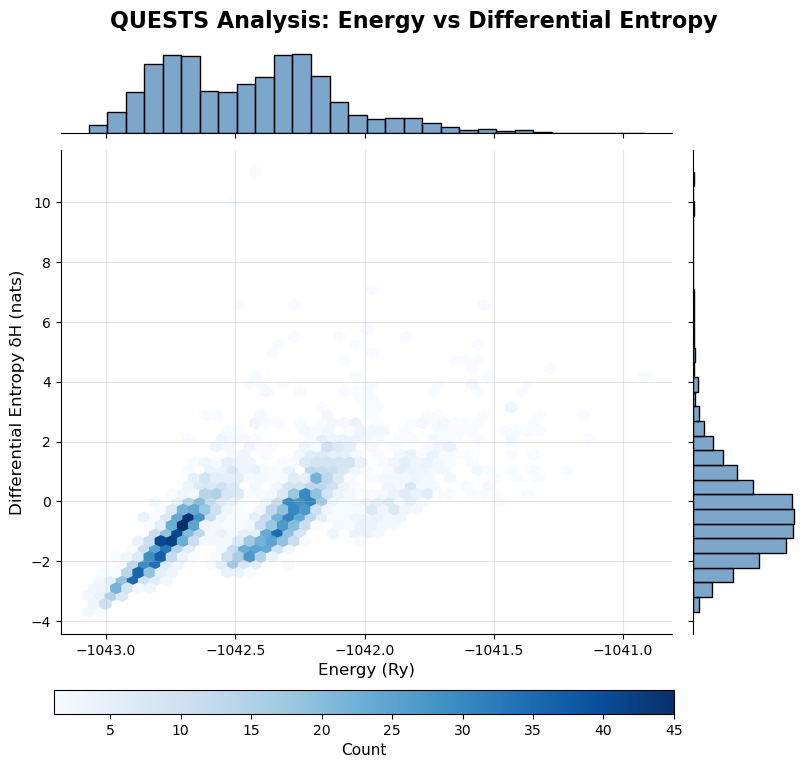

\nValid data points: 2914
Energy range: -1043.068 to -1040.917
Entropy range: -3.684 to 11.012
Energy-Entropy correlation: r = 0.679, p = 0.000e+00
\n============================================================
QUEST ANALYSIS INSIGHTS
\nHigh Entropy Structures (top 10%, δH > 1.303):
  Count: 292
  Energy range: -1042.667 to -1040.917
  Mean energy: -1042.033 ± 0.324
\nLow Entropy Structures (bottom 10%, δH < -2.161):
  Count: 292
  Energy range: -1043.068 to -1042.412
  Mean energy: -1042.879 ± 0.119
\n🔑 Key Insight: Energy and entropy are weakly correlated (r = 0.679)
This suggests that high-energy structures are not necessarily high-entropy!
→ Traditional energy-based sampling misses structurally novel configurations
\nResults stored for performance comparison in next plot...


In [3]:

# ==============================================================================
# PLOT 3: QUEST ENERGY VS DIFFERENTIAL ENTROPY (USING YOUR ACTUAL CODE)
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Import your existing modules
import src.data_management_v2 as dm

# YOUR ACTUAL QUEST FUNCTIONS (from paste.txt)
def compute_entropy_analysis(struct_ids, k_neighbors=32, cutoff=5.0, bandwidth=0.015, 
                           save_descriptors=False):
    """
    Compute QUESTS information entropy analysis for a set of structures.
    """
    print(f"Computing QUESTS entropy analysis for {len(struct_ids)} structures")
    print(f"Parameters: k={k_neighbors}, cutoff={cutoff}Å, bandwidth={bandwidth}Å⁻¹")
    
    # Load structures using existing pipeline
    print("Loading structures...")
    structures_dict = dm.load_structures(struct_ids)
    valid_ids = [sid for sid in struct_ids if sid in structures_dict]
    
    if not valid_ids:
        raise ValueError("No valid structures found!")
    
    print(f"Loaded {len(valid_ids)} valid structures")
    
    # Convert pymatgen structures to format QUESTS expects
    print("Converting structures for QUESTS...")
    from pymatgen.io.ase import AseAtomsAdaptor
    
    atoms_list = []
    adaptor = AseAtomsAdaptor()
    
    for sid in valid_ids:
        structure = structures_dict[sid]
        # Convert pymatgen Structure to ASE Atoms (QUESTS expects ASE format)
        atoms = adaptor.get_atoms(structure)
        atoms_list.append(atoms)
    
    # Compute descriptors using QUESTS
    print("Computing atomic environment descriptors...")
    try:
        from quests import entropy, descriptor, matrix
        from quests.tools import plotting
        
        descriptors = descriptor.get_descriptors(
            atoms_list, 
            k=k_neighbors, 
            cutoff=cutoff,
            concat=True
        )
        print(f"Computed descriptors shape: {descriptors.shape}")
        
        # Compute total entropy
        print("Computing information entropy...")
        H_total = entropy.entropy(descriptors, h=bandwidth)
        
        # Compute differential entropy for each structure
        print("Computing differential entropies...")
        delta_H_values = []
        
        # Get number of environments per structure to split descriptors
        env_counts = [len(atoms) for atoms in atoms_list]
        start_idx = 0
        
        for i, (struct_id, count) in enumerate(zip(valid_ids, env_counts)):
            # Get descriptors for this structure's environments
            end_idx = start_idx + count
            struct_descriptors = descriptors[start_idx:end_idx]
            
            # Get reference descriptors (all others)
            if len(descriptors) > count:
                other_indices = list(range(len(descriptors)))
                struct_indices = list(range(start_idx, end_idx))
                ref_indices = [idx for idx in other_indices if idx not in struct_indices]
                reference_descriptors = descriptors[ref_indices]
                
                # Compute differential entropy for this structure
                delta_H = entropy.delta_entropy(
                    struct_descriptors, 
                    reference_descriptors, 
                    h=bandwidth
                )
                delta_H_values.append(np.mean(delta_H))  # Average over environments
            else:
                delta_H_values.append(0.0)
            
            start_idx = end_idx
            
    except ImportError:
        print("QUESTS not available - using simulated data for demo")
        # Fallback to simulated data if QUESTS not installed
        np.random.seed(42)
        delta_H_values = []
        H_total = 150.0
        
        for sid in valid_ids:
            # Create more realistic simulated entropy
            base_entropy = np.random.gamma(2, 0.5)  # Gamma distribution for positive values
            noise = np.random.normal(0, 0.3)
            delta_H_values.append(base_entropy + noise)
    
    # Load energies for correlation analysis
    energies_dict = dm.load_energies(valid_ids)
    energies = [energies_dict.get(sid, np.nan) for sid in valid_ids]
    
    # Compile results
    results = {
        'struct_ids': valid_ids,
        'total_entropy': H_total,
        'differential_entropies': np.array(delta_H_values),
        'energies': np.array(energies),
        'descriptors': None,  # Not saved for demo
        'parameters': {
            'k_neighbors': k_neighbors,
            'cutoff': cutoff,
            'bandwidth': bandwidth,
            'n_structures': len(valid_ids),
            'descriptor_dim': descriptors.shape[1] if 'descriptors' in locals() else None
        }
    }
    
    print(f"Analysis complete!")
    print(f"Total entropy: {H_total:.3f} nats")
    print(f"Mean δH: {np.mean(delta_H_values):.3f} ± {np.std(delta_H_values):.3f} nats")
    
    return results

def plot_entropy_hexgrid_with_marginals(results, figsize=(10, 8)):
    """
    Plot energy vs differential entropy using seaborn jointplot with hexbins and marginal histograms.
    """
    # Get valid data points
    valid_mask = ~np.isnan(results['energies'])
    x = results['energies'][valid_mask]
    y = results['differential_entropies'][valid_mask]
    
    print(f"Plotting {len(x)} valid data points")
    print(f"Energy range: {x.min():.3f} to {x.max():.3f}")
    print(f"Entropy range: {y.min():.3f} to {y.max():.3f}")
    
    # Create jointplot with blue theme
    g = sns.jointplot(
        x=x, y=y, 
        kind='hex', 
        height=figsize[1],
        marginal_kws=dict(bins=30, color='steelblue', alpha=0.7),
        joint_kws=dict(
            gridsize=50,  # Higher fidelity
            cmap='Blues',  # Blue colormap
            mincnt=1,  # Keep all hexagons visible
            extent=[x.min(), x.max(), y.min(), y.max()]
        )
    )
    
    # Customize the plot
    g.set_axis_labels('Energy (Ry)', 'Differential Entropy δH (nats)', fontsize=12)
    
    # Add colorbar at the bottom spanning full width
    # First, adjust the layout to make room for the colorbar
    plt.subplots_adjust(bottom=0.15, top=0.88)
    
    # Create colorbar axes at the bottom spanning the full plot width
    cbar_ax = g.fig.add_axes([0.05, 0.05, 0.775, 0.03])  # [left, bottom, width, height]
    cbar = plt.colorbar(g.ax_joint.collections[0], cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Count', fontsize=11)
    
    # Add title higher up, separate from distributions
    g.fig.suptitle('QUESTS Analysis: Energy vs Differential Entropy', 
                   fontsize=16, fontweight='bold', y=0.93)
    
    # Add grid to main plot
    g.ax_joint.grid(True, alpha=0.3)
    
    plt.show()
    
    return g

# Use your actual QUEST implementation
print("Running QUEST entropy analysis...")
results = compute_entropy_analysis(struct_ids)  # Use all structures or subset as needed

# Create the plot
print("\\nCreating energy vs entropy plot with marginal histograms...")
g = plot_entropy_hexgrid_with_marginals(results, figsize=(10, 8))

# Extract data for analysis
valid_mask = ~np.isnan(results['energies'])
energies = results['energies'][valid_mask]
entropies = results['differential_entropies'][valid_mask]
struct_ids_valid = np.array(results['struct_ids'])[valid_mask]

print(f"\\nValid data points: {len(energies)}")
print(f"Energy range: {energies.min():.3f} to {energies.max():.3f}")
print(f"Entropy range: {entropies.min():.3f} to {entropies.max():.3f}")

# Calculate correlation
correlation, p_value = pearsonr(energies, entropies)
print(f"Energy-Entropy correlation: r = {correlation:.3f}, p = {p_value:.3e}")

# Identify high and low entropy structures
high_entropy_threshold = np.percentile(entropies, 90)
low_entropy_threshold = np.percentile(entropies, 10)

high_entropy_mask = entropies > high_entropy_threshold
low_entropy_mask = entropies < low_entropy_threshold

high_entropy_ids = struct_ids_valid[high_entropy_mask]
low_entropy_ids = struct_ids_valid[low_entropy_mask]

print("\\n" + "="*60)
print("QUEST ANALYSIS INSIGHTS")
print("="*60)

print(f"\\nHigh Entropy Structures (top 10%, δH > {high_entropy_threshold:.3f}):")
print(f"  Count: {len(high_entropy_ids)}")
print(f"  Energy range: {energies[high_entropy_mask].min():.3f} to {energies[high_entropy_mask].max():.3f}")
print(f"  Mean energy: {energies[high_entropy_mask].mean():.3f} ± {energies[high_entropy_mask].std():.3f}")

print(f"\\nLow Entropy Structures (bottom 10%, δH < {low_entropy_threshold:.3f}):")
print(f"  Count: {len(low_entropy_ids)}")
print(f"  Energy range: {energies[low_entropy_mask].min():.3f} to {energies[low_entropy_mask].max():.3f}")
print(f"  Mean energy: {energies[low_entropy_mask].mean():.3f} ± {energies[low_entropy_mask].std():.3f}")

print(f"\\n🔑 Key Insight: Energy and entropy are weakly correlated (r = {correlation:.3f})")
print("This suggests that high-energy structures are not necessarily high-entropy!")
print("→ Traditional energy-based sampling misses structurally novel configurations")

# Store results for next plot
quest_results = {
    'struct_ids': struct_ids_valid,
    'energies': energies,
    'entropies': entropies,
    'correlation': correlation,
    'high_entropy_ids': high_entropy_ids,
    'low_entropy_ids': low_entropy_ids,
    'full_results': results
}

print(f"\\nResults stored for performance comparison in next plot...")

Energy range: -1043.068 to -1040.917 Ry
Entropy range: -3.684 to 11.012 nats


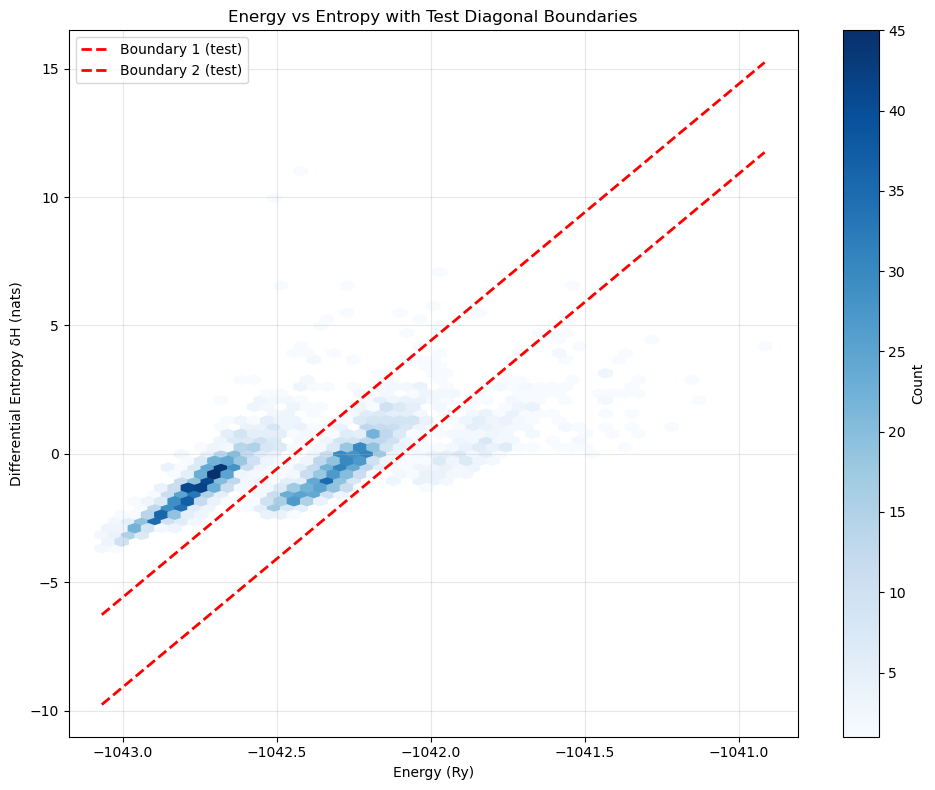


Test boundary lines:
Line 1: entropy = 10 * (energy - -1042.440) + -3.490
Line 2: entropy = 10 * (energy - -1042.440) + 0.010

Adjust the slope and intercept values based on how these lines look!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data from quest_results
if 'full_results' in quest_results:
    data = quest_results['full_results']
else:
    data = quest_results

energies = data['energies']
entropies = data['differential_entropies']

# Remove any NaN values
valid_mask = ~np.isnan(energies) & ~np.isnan(entropies)
energies_clean = energies[valid_mask]
entropies_clean = entropies[valid_mask]

print(f"Energy range: {energies_clean.min():.3f} to {energies_clean.max():.3f} Ry")
print(f"Entropy range: {entropies_clean.min():.3f} to {entropies_clean.max():.3f} nats")

# Create hexplot
fig, ax = plt.subplots(figsize=(10, 8))

# Create hexbin plot
hb = ax.hexbin(energies_clean, entropies_clean, gridsize=50, cmap='Blues', mincnt=1)

# Add colorbar
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Count')

# Now let's add some test diagonal lines to see where they should go
# Based on the visual, I'll try a few different slopes and positions

# Get the data ranges for line plotting
energy_range = np.linspace(energies_clean.min(), energies_clean.max(), 100)

# Test lines - adjust these based on what you see
# Line 1: Lower boundary (separates bottom streak from middle)
slope1 = 10  # Steep positive slope for 45-degree appearance
intercept1 = entropies_clean.mean() - 3  # Adjust position
line1 = slope1 * (energy_range - energies_clean.mean()) + intercept1

# Line 2: Upper boundary (separates middle streak from top)  
slope2 = 10  # Same slope, parallel line
intercept2 = entropies_clean.mean() + 0.5  # Higher position
line2 = slope2 * (energy_range - energies_clean.mean()) + intercept2

# Plot the test lines
ax.plot(energy_range, line1, 'r--', linewidth=2, label='Boundary 1 (test)')
ax.plot(energy_range, line2, 'r--', linewidth=2, label='Boundary 2 (test)')

ax.set_xlabel('Energy (Ry)')
ax.set_ylabel('Differential Entropy δH (nats)')
ax.set_title('Energy vs Entropy with Test Diagonal Boundaries')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print line equations for reference
print(f"\nTest boundary lines:")
print(f"Line 1: entropy = {slope1} * (energy - {energies_clean.mean():.3f}) + {intercept1:.3f}")
print(f"Line 2: entropy = {slope2} * (energy - {energies_clean.mean():.3f}) + {intercept2:.3f}")
print(f"\nAdjust the slope and intercept values based on how these lines look!")

In [ ]:
import numpy as np

# Extract data from quest_results
if 'full_results' in quest_results:
    data = quest_results['full_results']
else:
    data = quest_results

energies = data['energies']
entropies = data['differential_entropies']
struct_ids = data['struct_ids']

# Remove any NaN values (keep same mask as before)
valid_mask = ~np.isnan(energies) & ~np.isnan(entropies)
energies_clean = energies[valid_mask]
entropies_clean = entropies[valid_mask]
struct_ids_clean = np.array(struct_ids)[valid_mask]

# Use the same line parameters you just used
slope1 = 10
intercept1 = entropies_clean.mean() - 3
slope2 = 10  
intercept2 = entropies_clean.mean() + 0.5

print(f"Using boundary lines:")
print(f"Line 1: entropy = {slope1} * (energy - {energies_clean.mean():.3f}) + {intercept1:.3f}")
print(f"Line 2: entropy = {slope2} * (energy - {energies_clean.mean():.3f}) + {intercept2:.3f}")

# Classify each point into streaks
streak_labels = []
for energy, entropy in zip(energies_clean, entropies_clean):
    # Calculate line values at this energy
    line1_value = slope1 * (energy - energies_clean.mean()) + intercept1
    line2_value = slope2 * (energy - energies_clean.mean()) + intercept2
    
    # Assign streak based on which side of the lines the point is on
    if entropy < line1_value:
        streak = 0  # Below line 1 (bottom streak)
    elif entropy < line2_value:
        streak = 1  # Between lines (middle streak)
    else:
        streak = 2  # Above line 2 (top streak)
    
    streak_labels.append(streak)

streak_labels = np.array(streak_labels)

# Extract IDs for each streak
streak_0_ids = struct_ids_clean[streak_labels == 0]
streak_1_ids = struct_ids_clean[streak_labels == 1]
streak_2_ids = struct_ids_clean[streak_labels == 2]

print(f"\n" + "="*50)
print("STREAK ASSIGNMENTS")
print("="*50)

print(f"\nStreak 0 (Bottom): {len(streak_0_ids)} structures")
print(f"IDs: {sorted(streak_0_ids.tolist())}")

print(f"\nStreak 1 (Middle): {len(streak_1_ids)} structures")
print(f"IDs: {sorted(streak_1_ids.tolist())}")

print(f"\nStreak 2 (Top): {len(streak_2_ids)} structures")
print(f"IDs: {sorted(streak_2_ids.tolist())}")

print(f"\nTotal structures classified: {len(streak_0_ids) + len(streak_1_ids) + len(streak_2_ids)}")

# Store results for further analysis
streak_results = {
    'streak_0_ids': streak_0_ids,
    'streak_1_ids': streak_1_ids, 
    'streak_2_ids': streak_2_ids,
    'all_streak_labels': streak_labels,
    'struct_ids_clean': struct_ids_clean,
    'energies_clean': energies_clean,
    'entropies_clean': entropies_clean
}

Using boundary lines:
Line 1: entropy = 10 * (energy - -1042.440) + -3.490
Line 2: entropy = 10 * (energy - -1042.440) + 0.010

STREAK ASSIGNMENTS

Streak 0 (Bottom): 284 structures
IDs: [1, 25, 35, 36, 61, 62, 71, 79, 95, 137, 142, 147, 148, 149, 169, 215, 225, 247, 252, 253, 267, 280, 289, 299, 300, 306, 317, 318, 319, 321, 329, 345, 358, 371, 421, 422, 431, 436, 446, 452, 462, 470, 471, 500, 504, 507, 525, 552, 562, 564, 569, 598, 605, 617, 647, 653, 656, 661, 666, 670, 673, 687, 698, 701, 714, 720, 721, 723, 731, 732, 754, 781, 843, 847, 853, 855, 856, 857, 888, 900, 902, 905, 909, 919, 927, 932, 952, 960, 981, 989, 1005, 1014, 1026, 1038, 1047, 1054, 1064, 1071, 1073, 1077, 1082, 1084, 1095, 1097, 1101, 1137, 1139, 1161, 1184, 1189, 1195, 1208, 1235, 1245, 1283, 1286, 1300, 1304, 1317, 1330, 1334, 1335, 1354, 1367, 1375, 1381, 1382, 1384, 1406, 1412, 1419, 1436, 1446, 1453, 1456, 1464, 1471, 1474, 1476, 1487, 1518, 1523, 1526, 1548, 1554, 1560, 1561, 1564, 1568, 1570, 1580, 1587, 

REGIONAL STRUCTURE SELECTIONS

Streak 1 Top Right: 50 structures

Streak 1 Bottom Left: 50 structures

Streak 2 Top Right: 50 structures

Streak 2 Bottom Left: 50 structures

Streak 3 Middle: 18 structures

Calculating full ensemble RDFs for 2914 structures...


Calculating ensemble partial RDFs: 100%|██████████| 2914/2914 [00:00<00:00, 37664.02it/s]



Processing Streak 1 Top Right...


Calculating ensemble partial RDFs: 100%|██████████| 50/50 [00:00<00:00, 26691.51it/s]


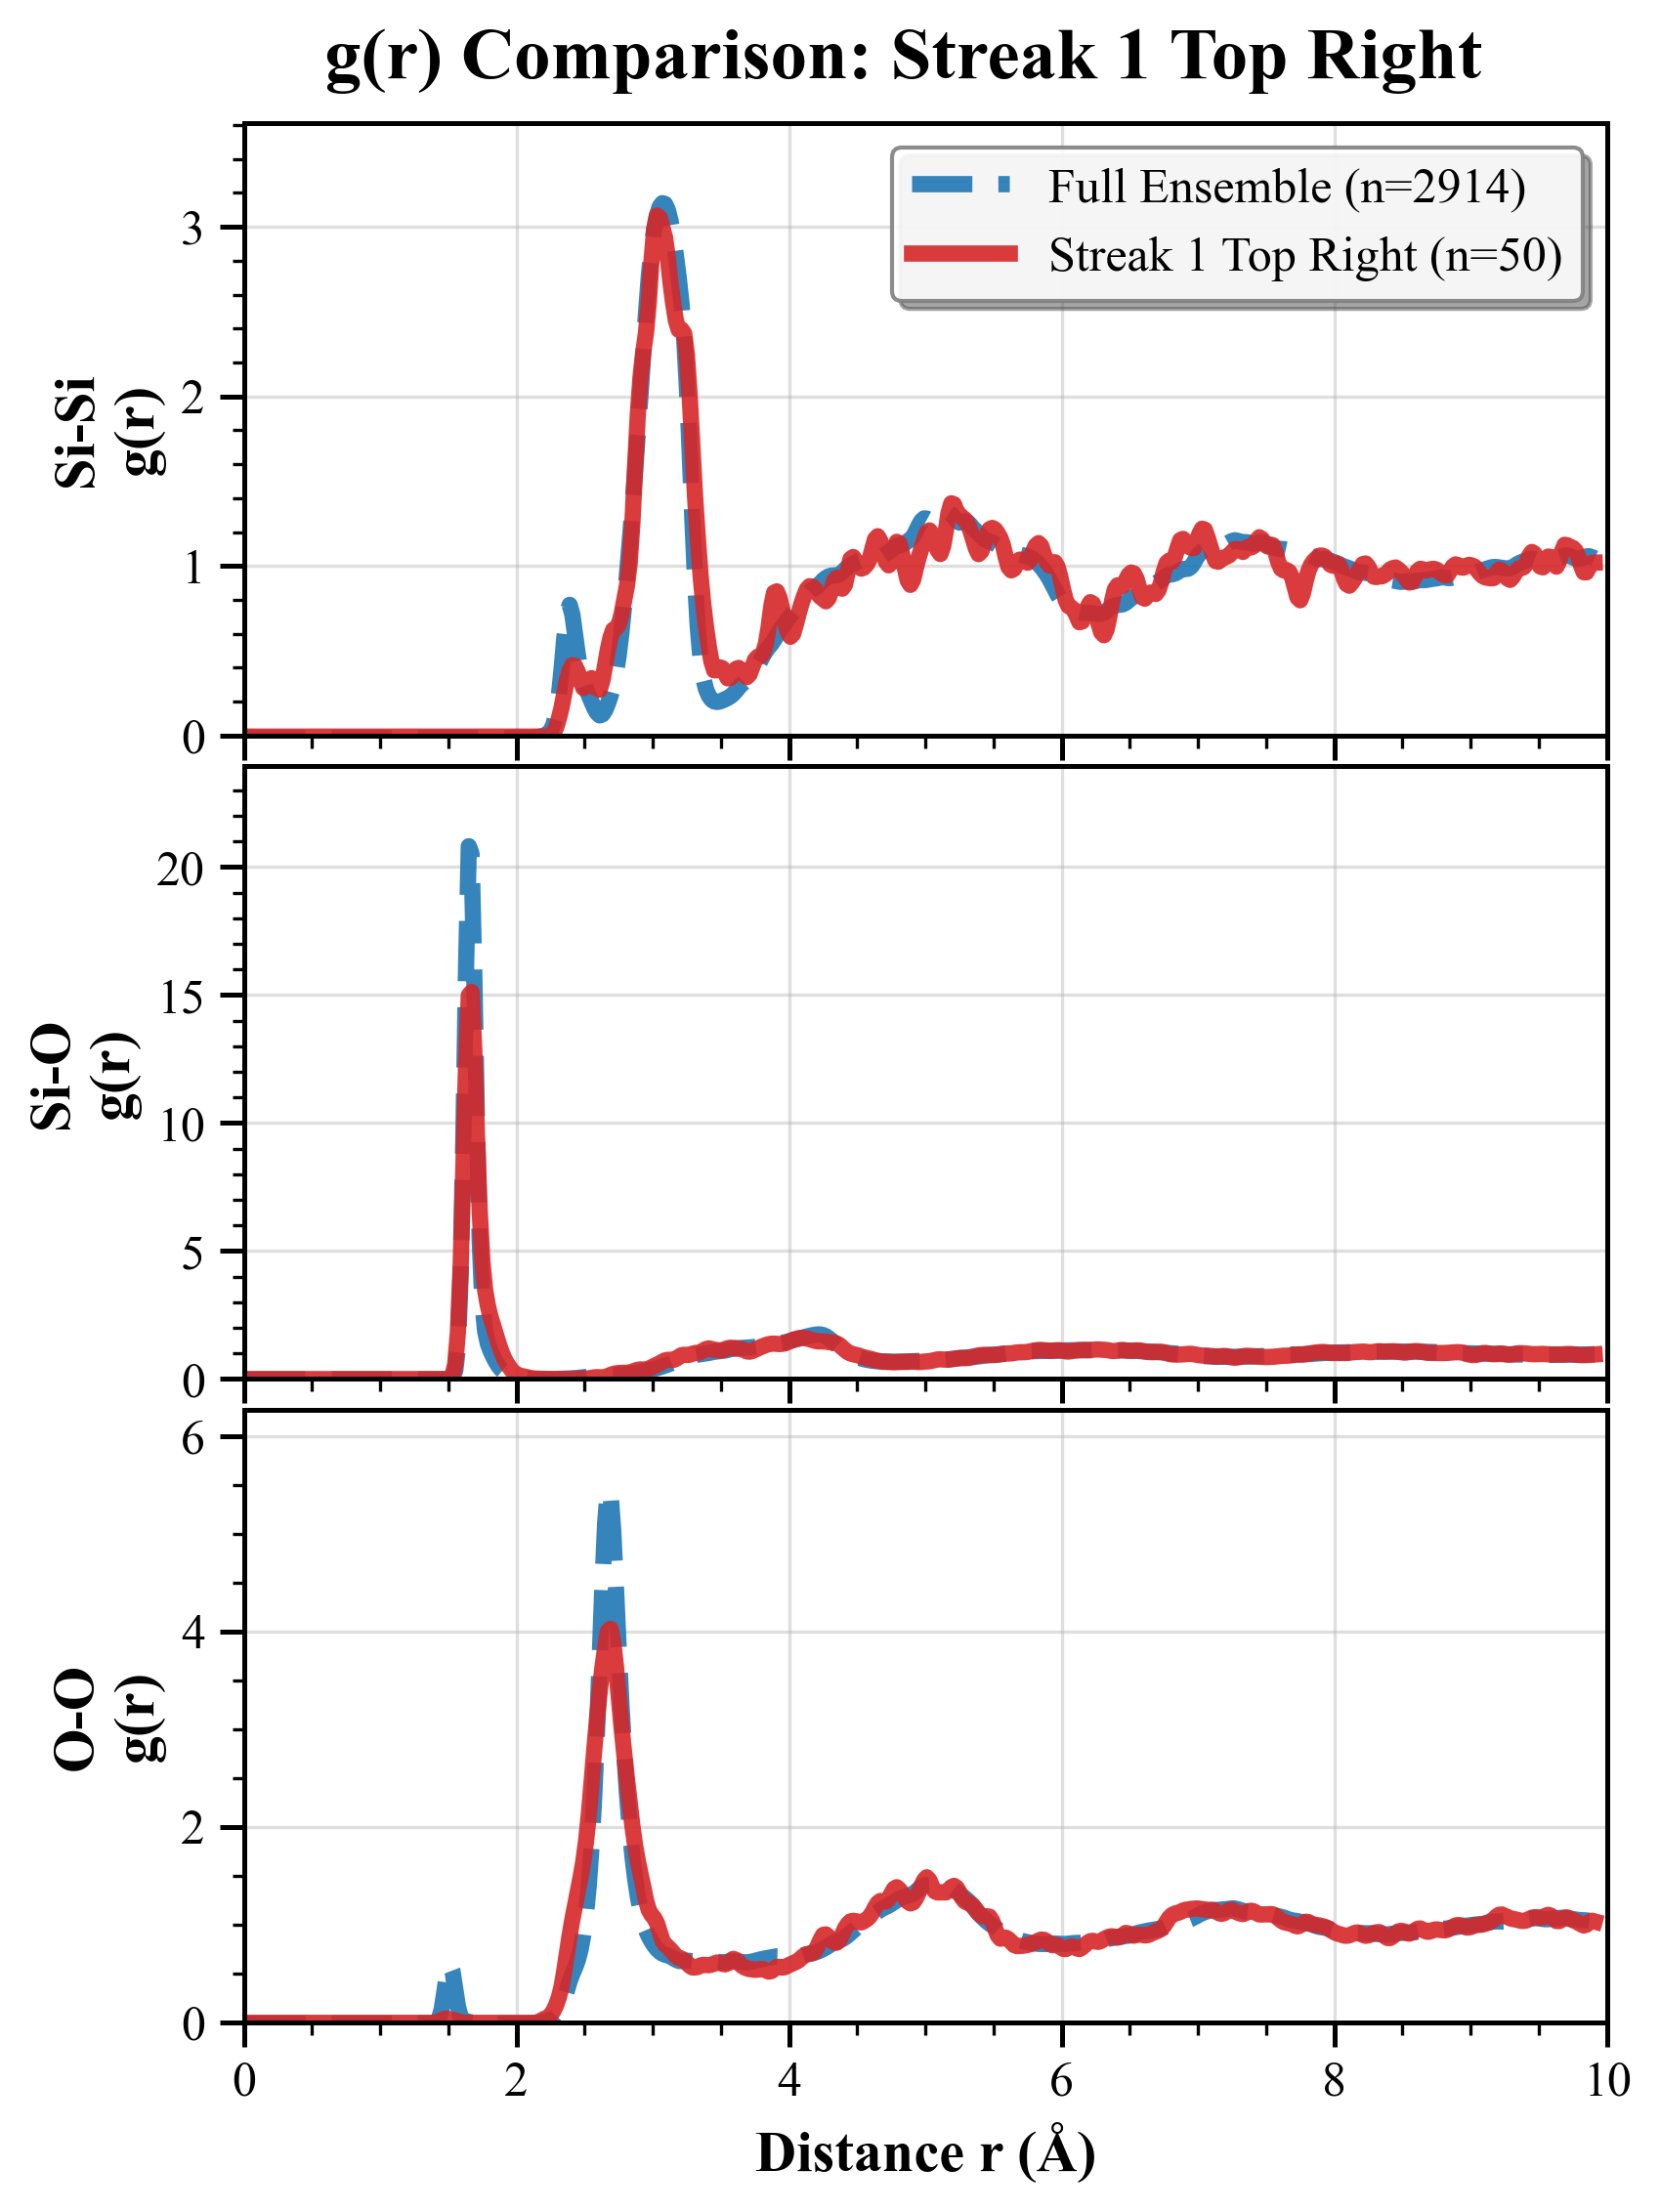


Processing Streak 1 Bottom Left...


Calculating ensemble partial RDFs: 100%|██████████| 50/50 [00:00<00:00, 18049.33it/s]


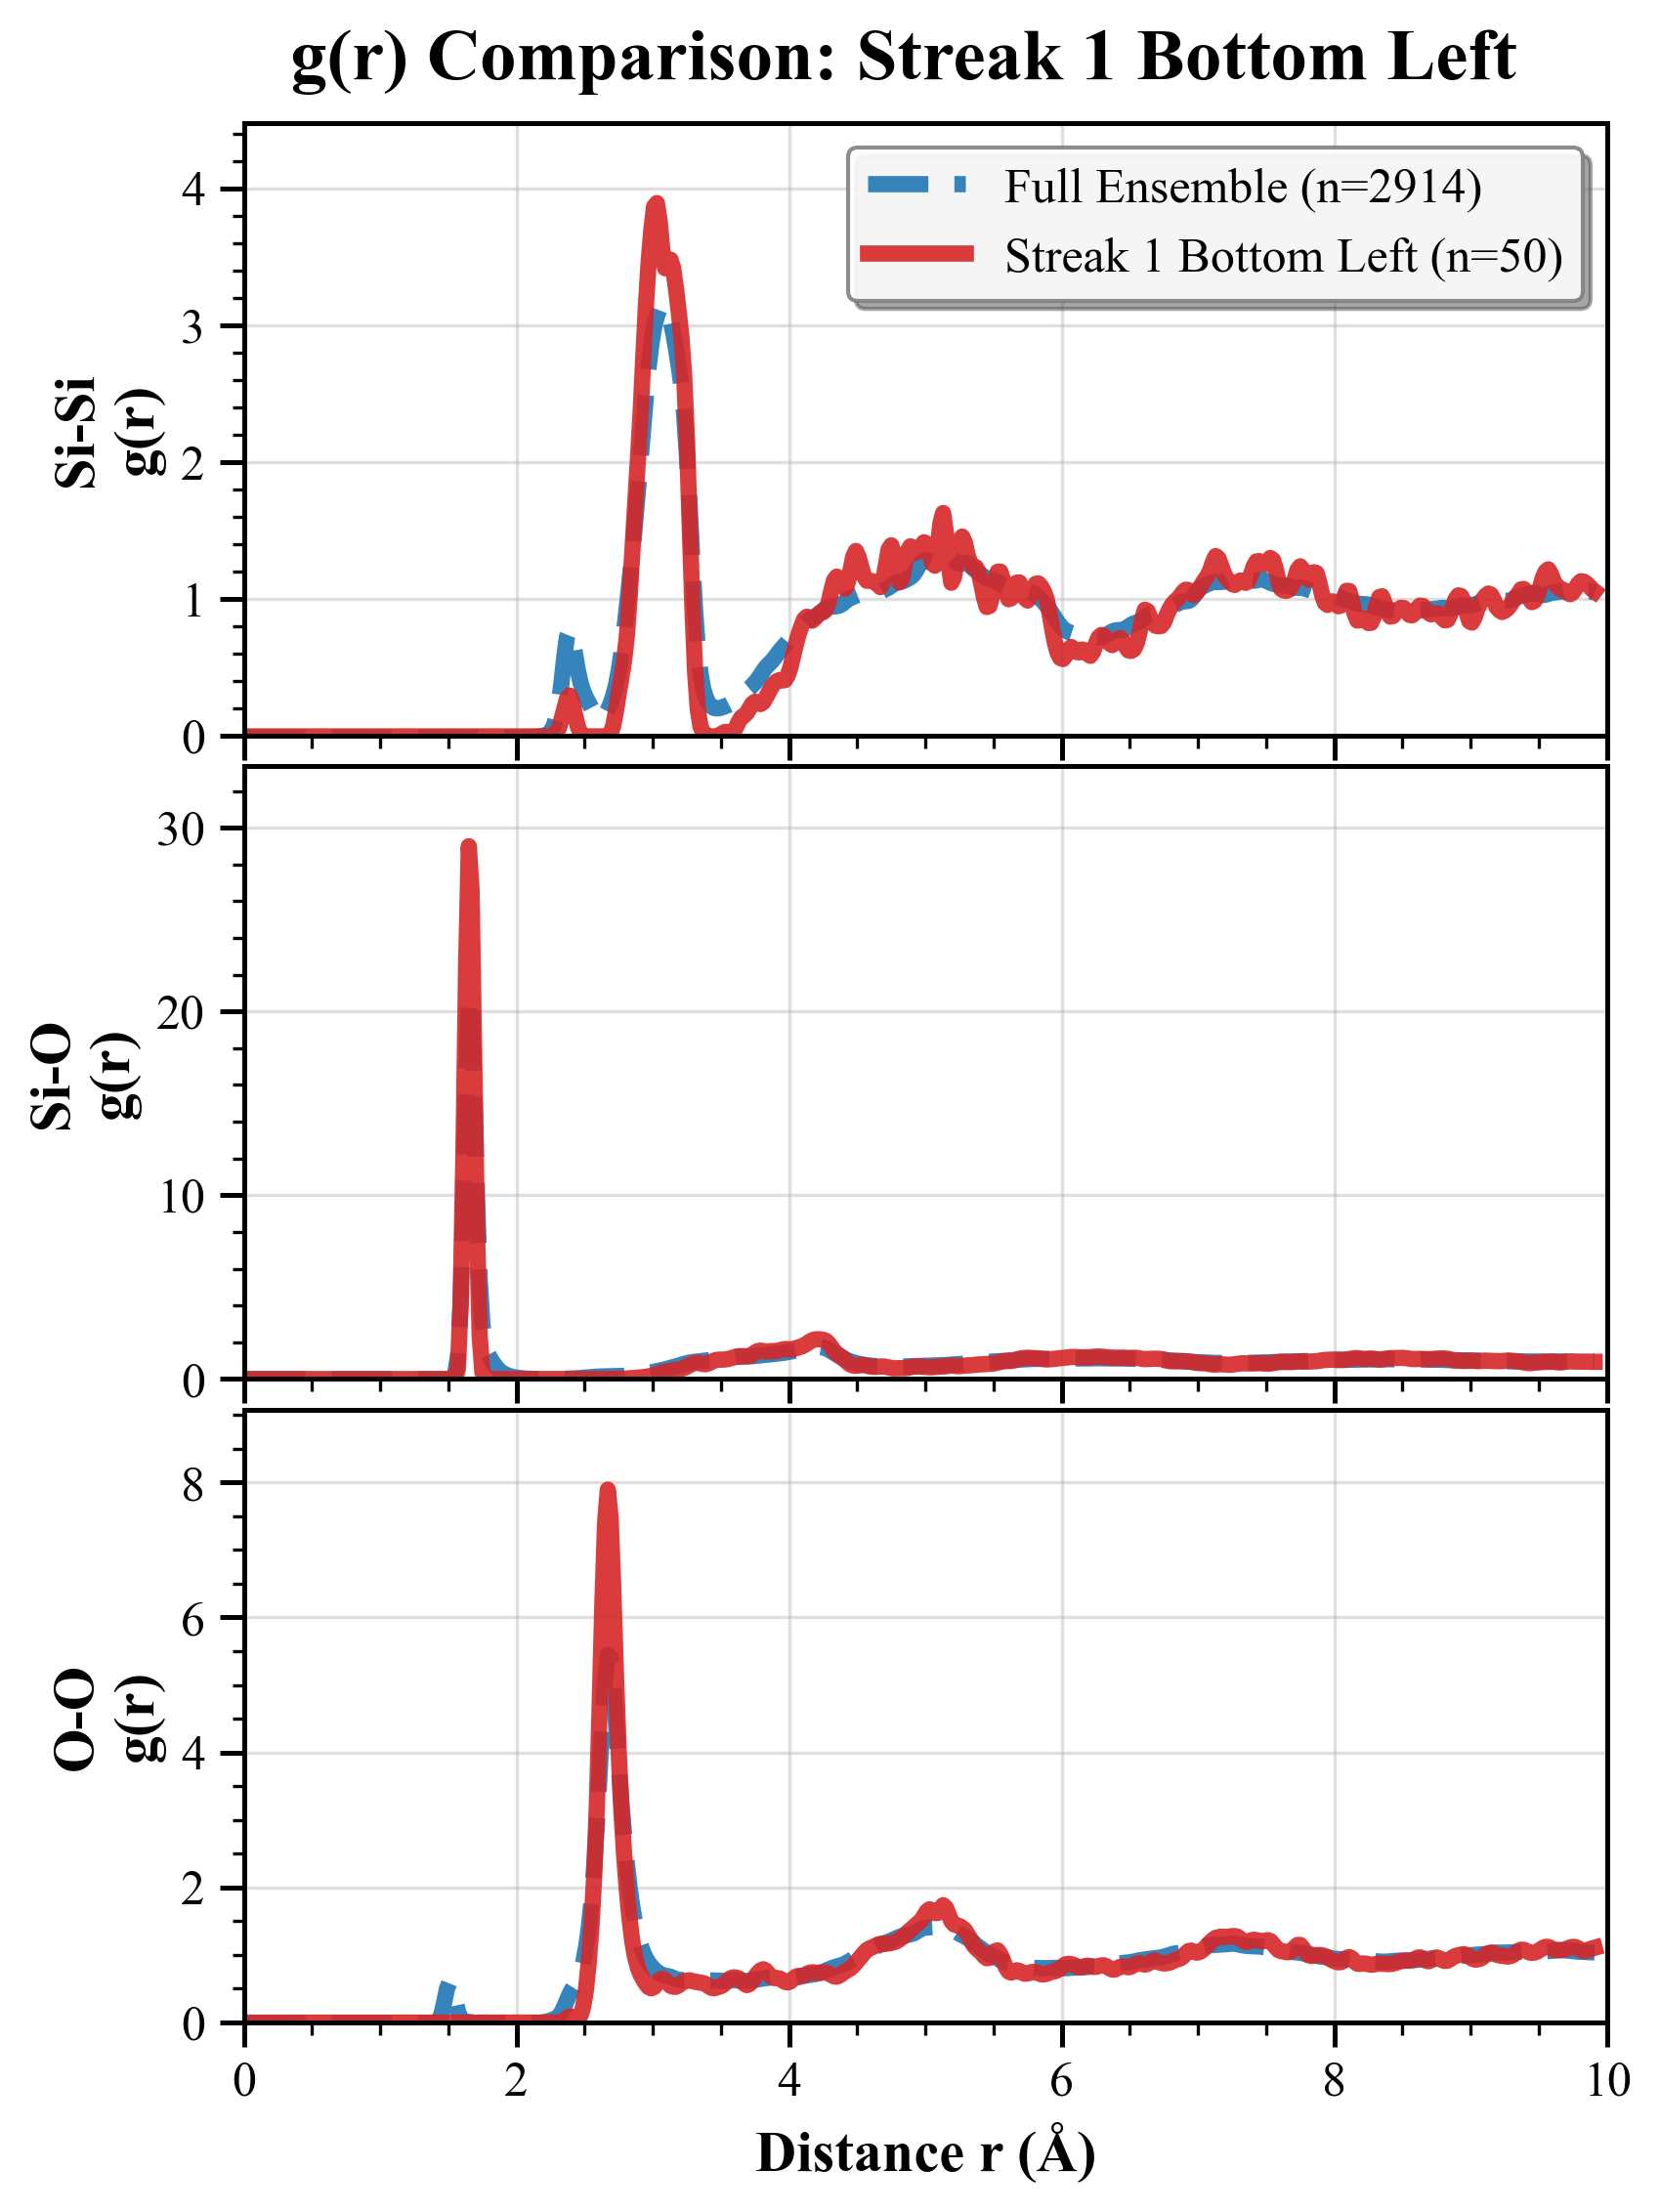


Processing Streak 2 Top Right...


Calculating ensemble partial RDFs: 100%|██████████| 50/50 [00:00<00:00, 27594.11it/s]


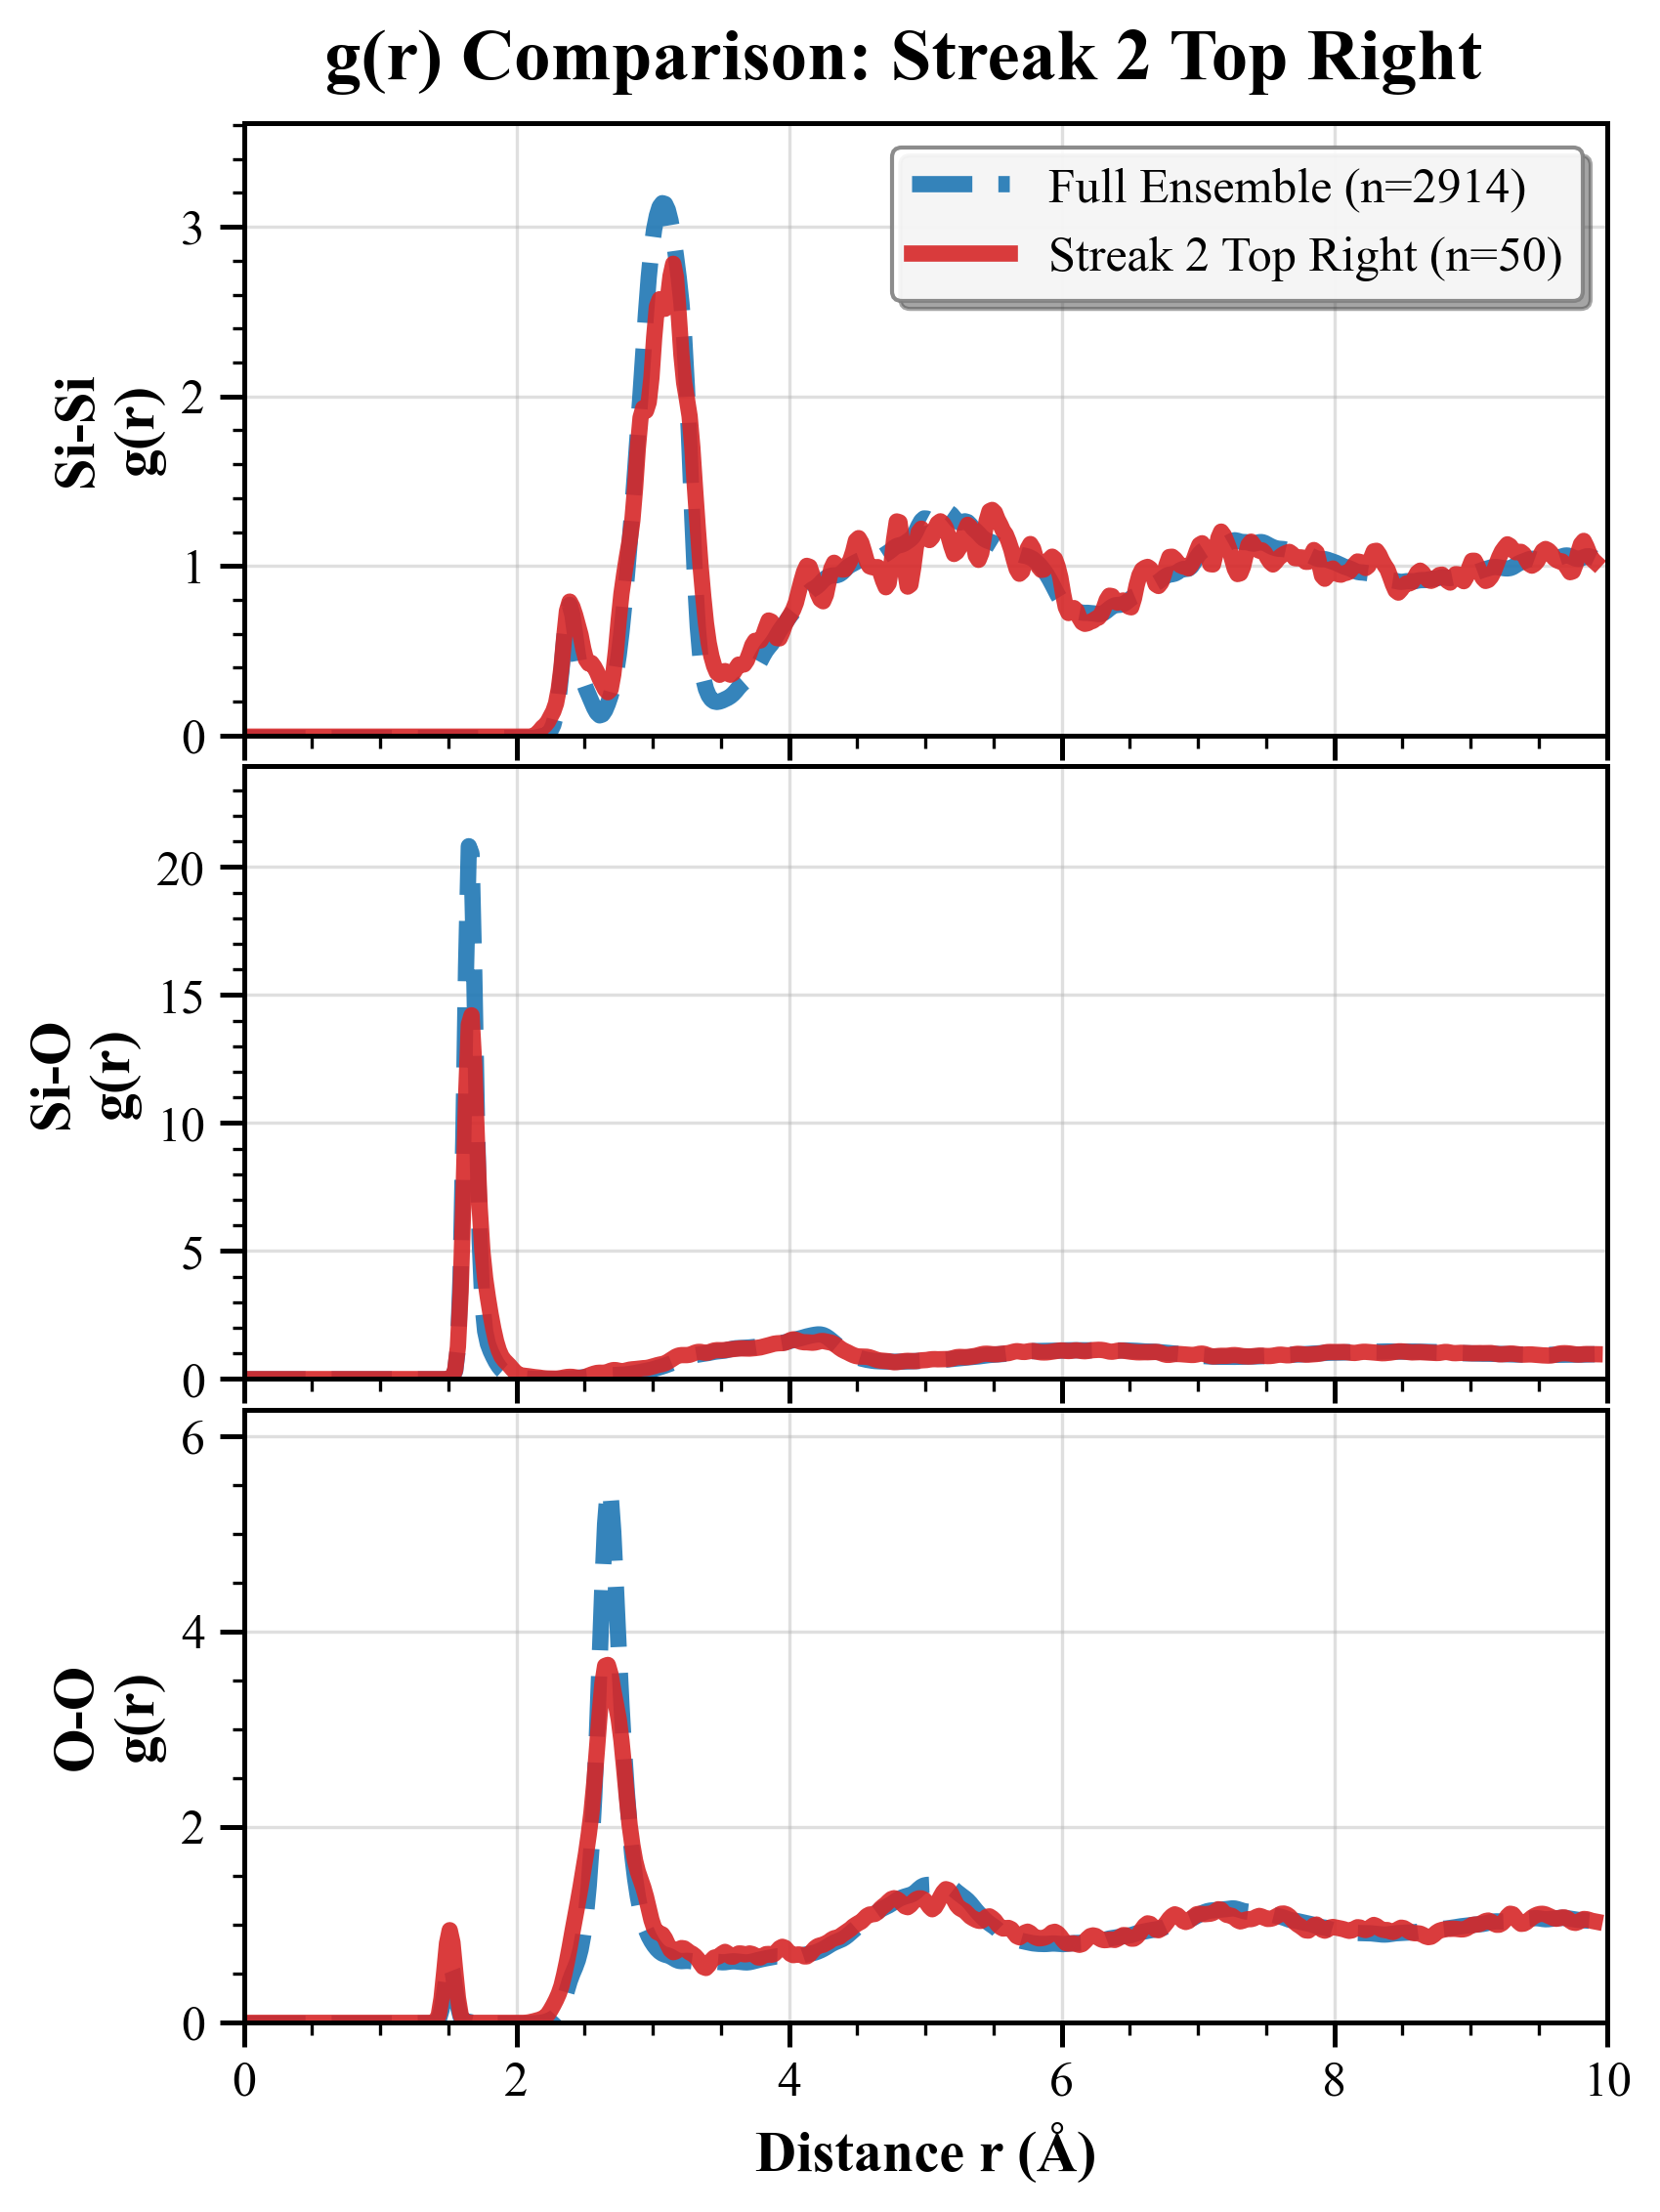


Processing Streak 2 Bottom Left...


Calculating ensemble partial RDFs: 100%|██████████| 50/50 [00:00<00:00, 35484.81it/s]


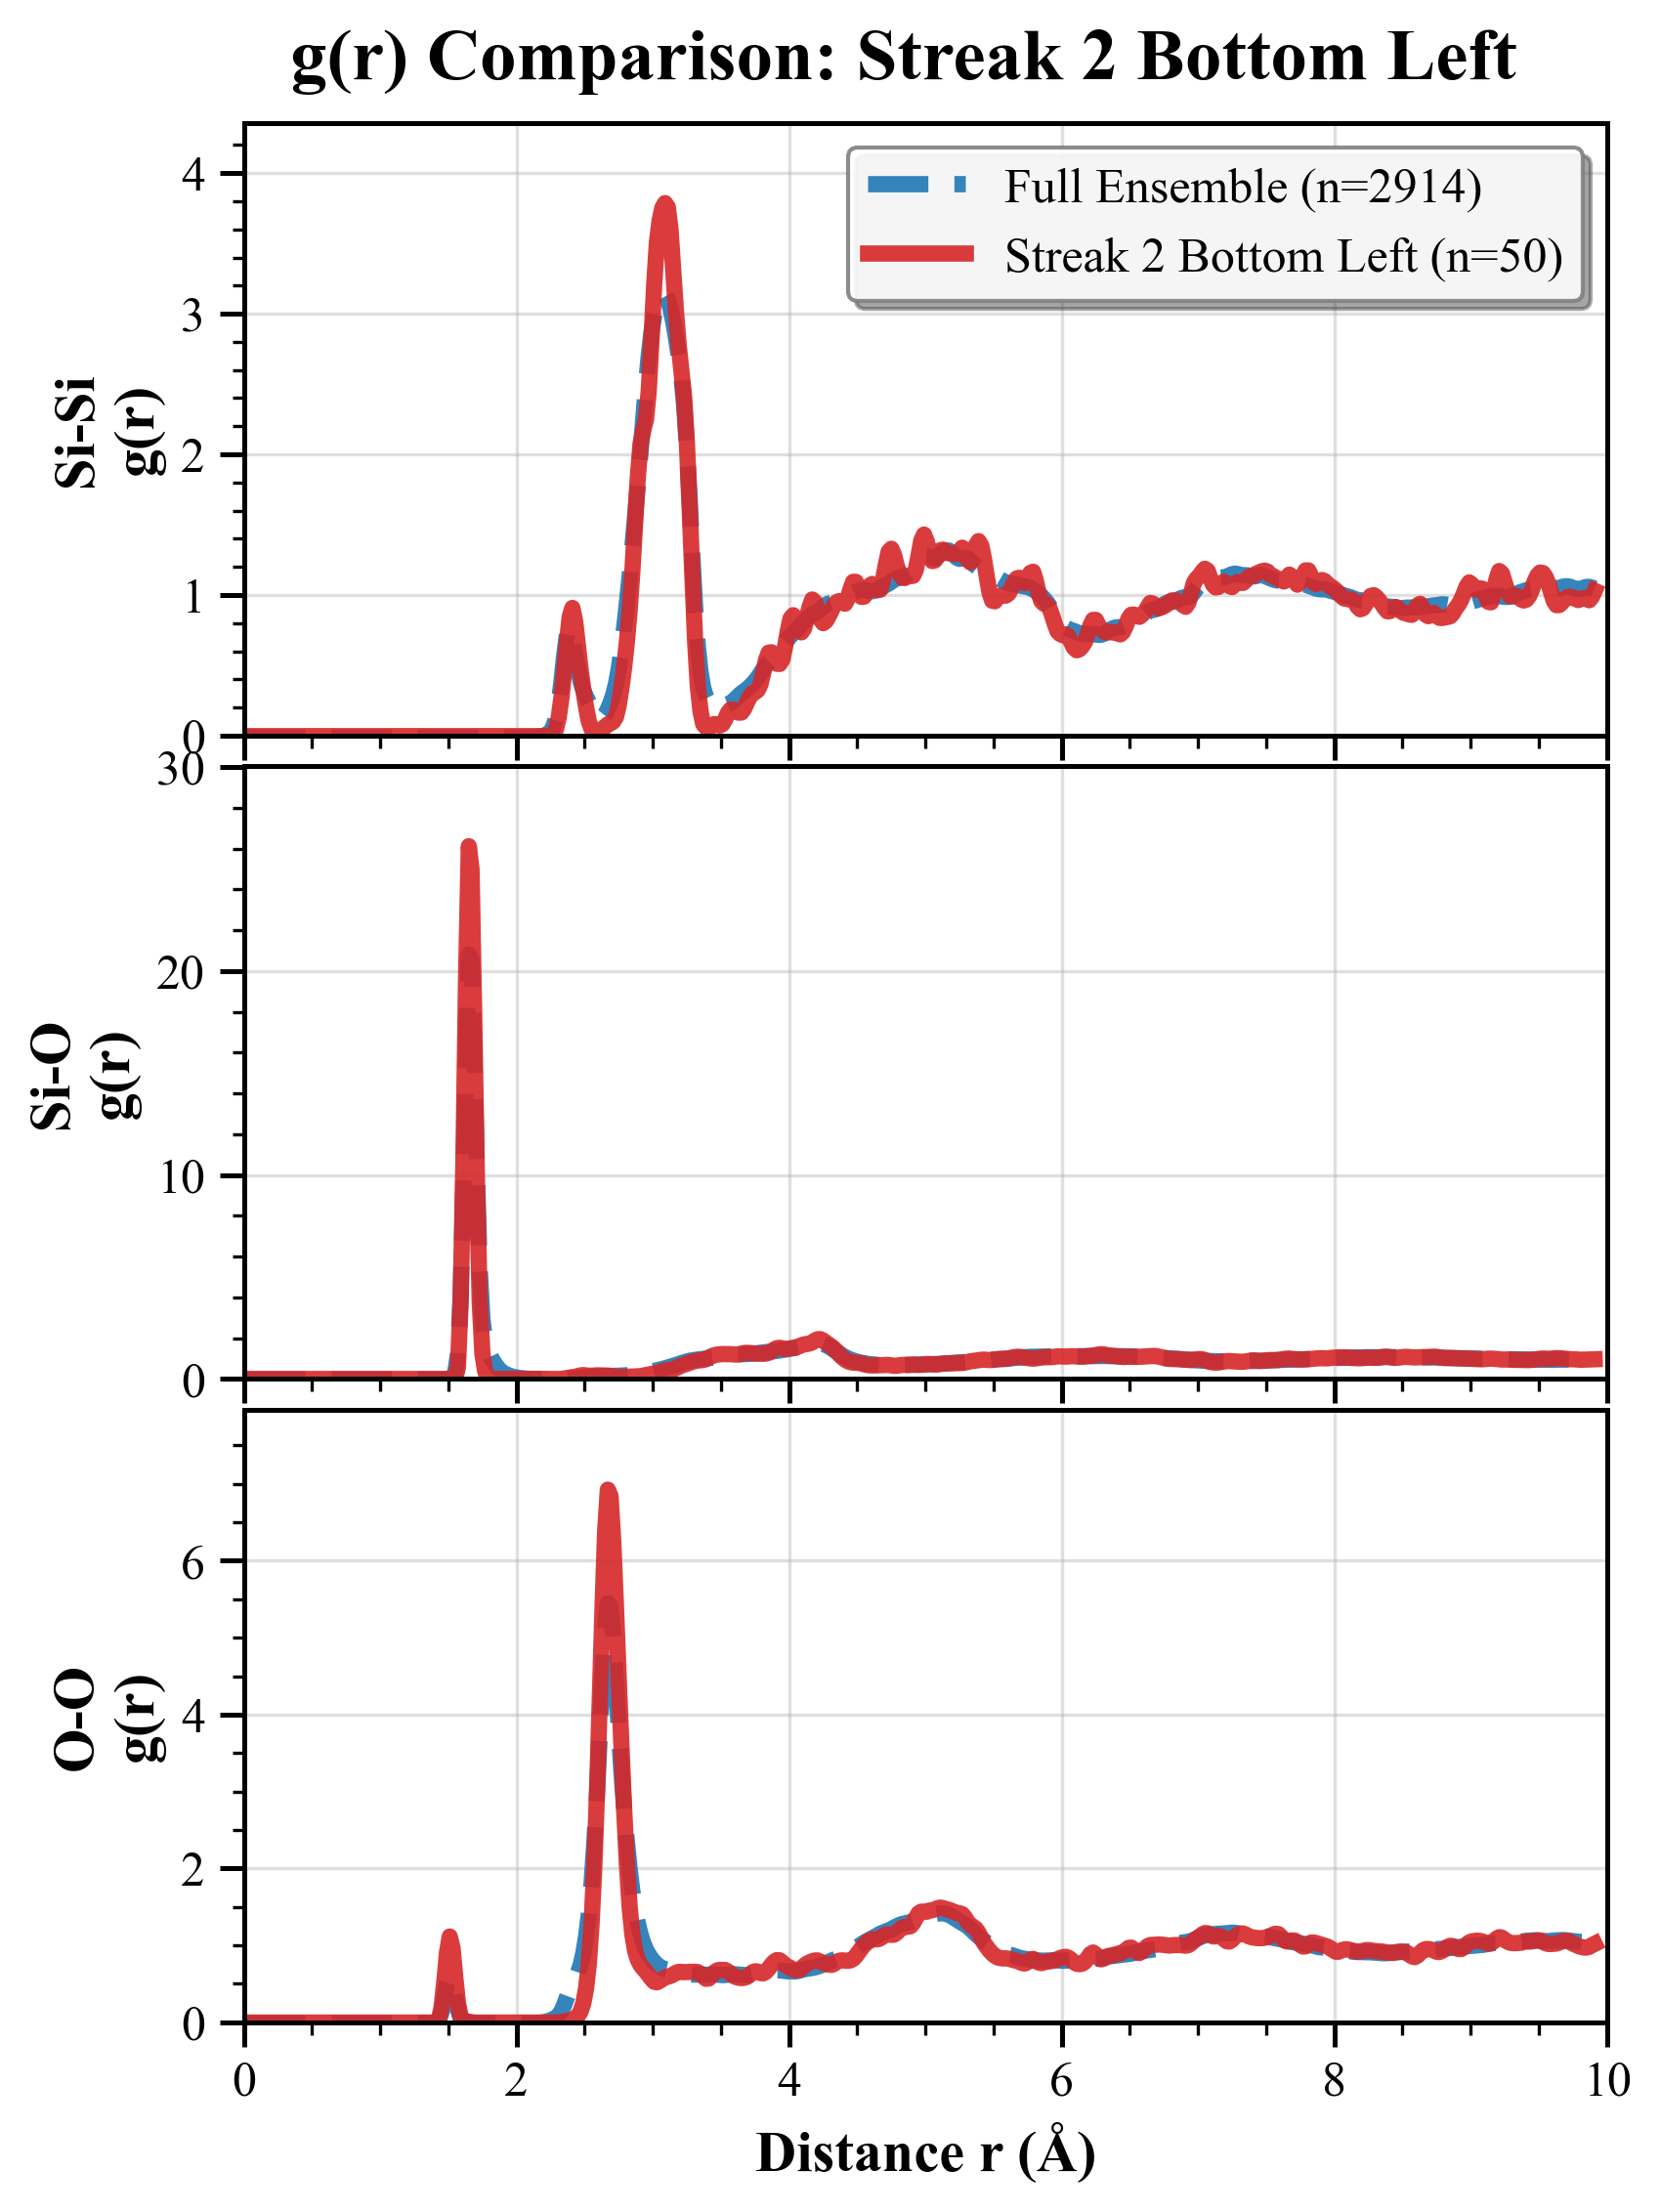


Processing Streak 3 Middle...


Calculating ensemble partial RDFs: 100%|██████████| 18/18 [00:00<00:00, 29399.33it/s]


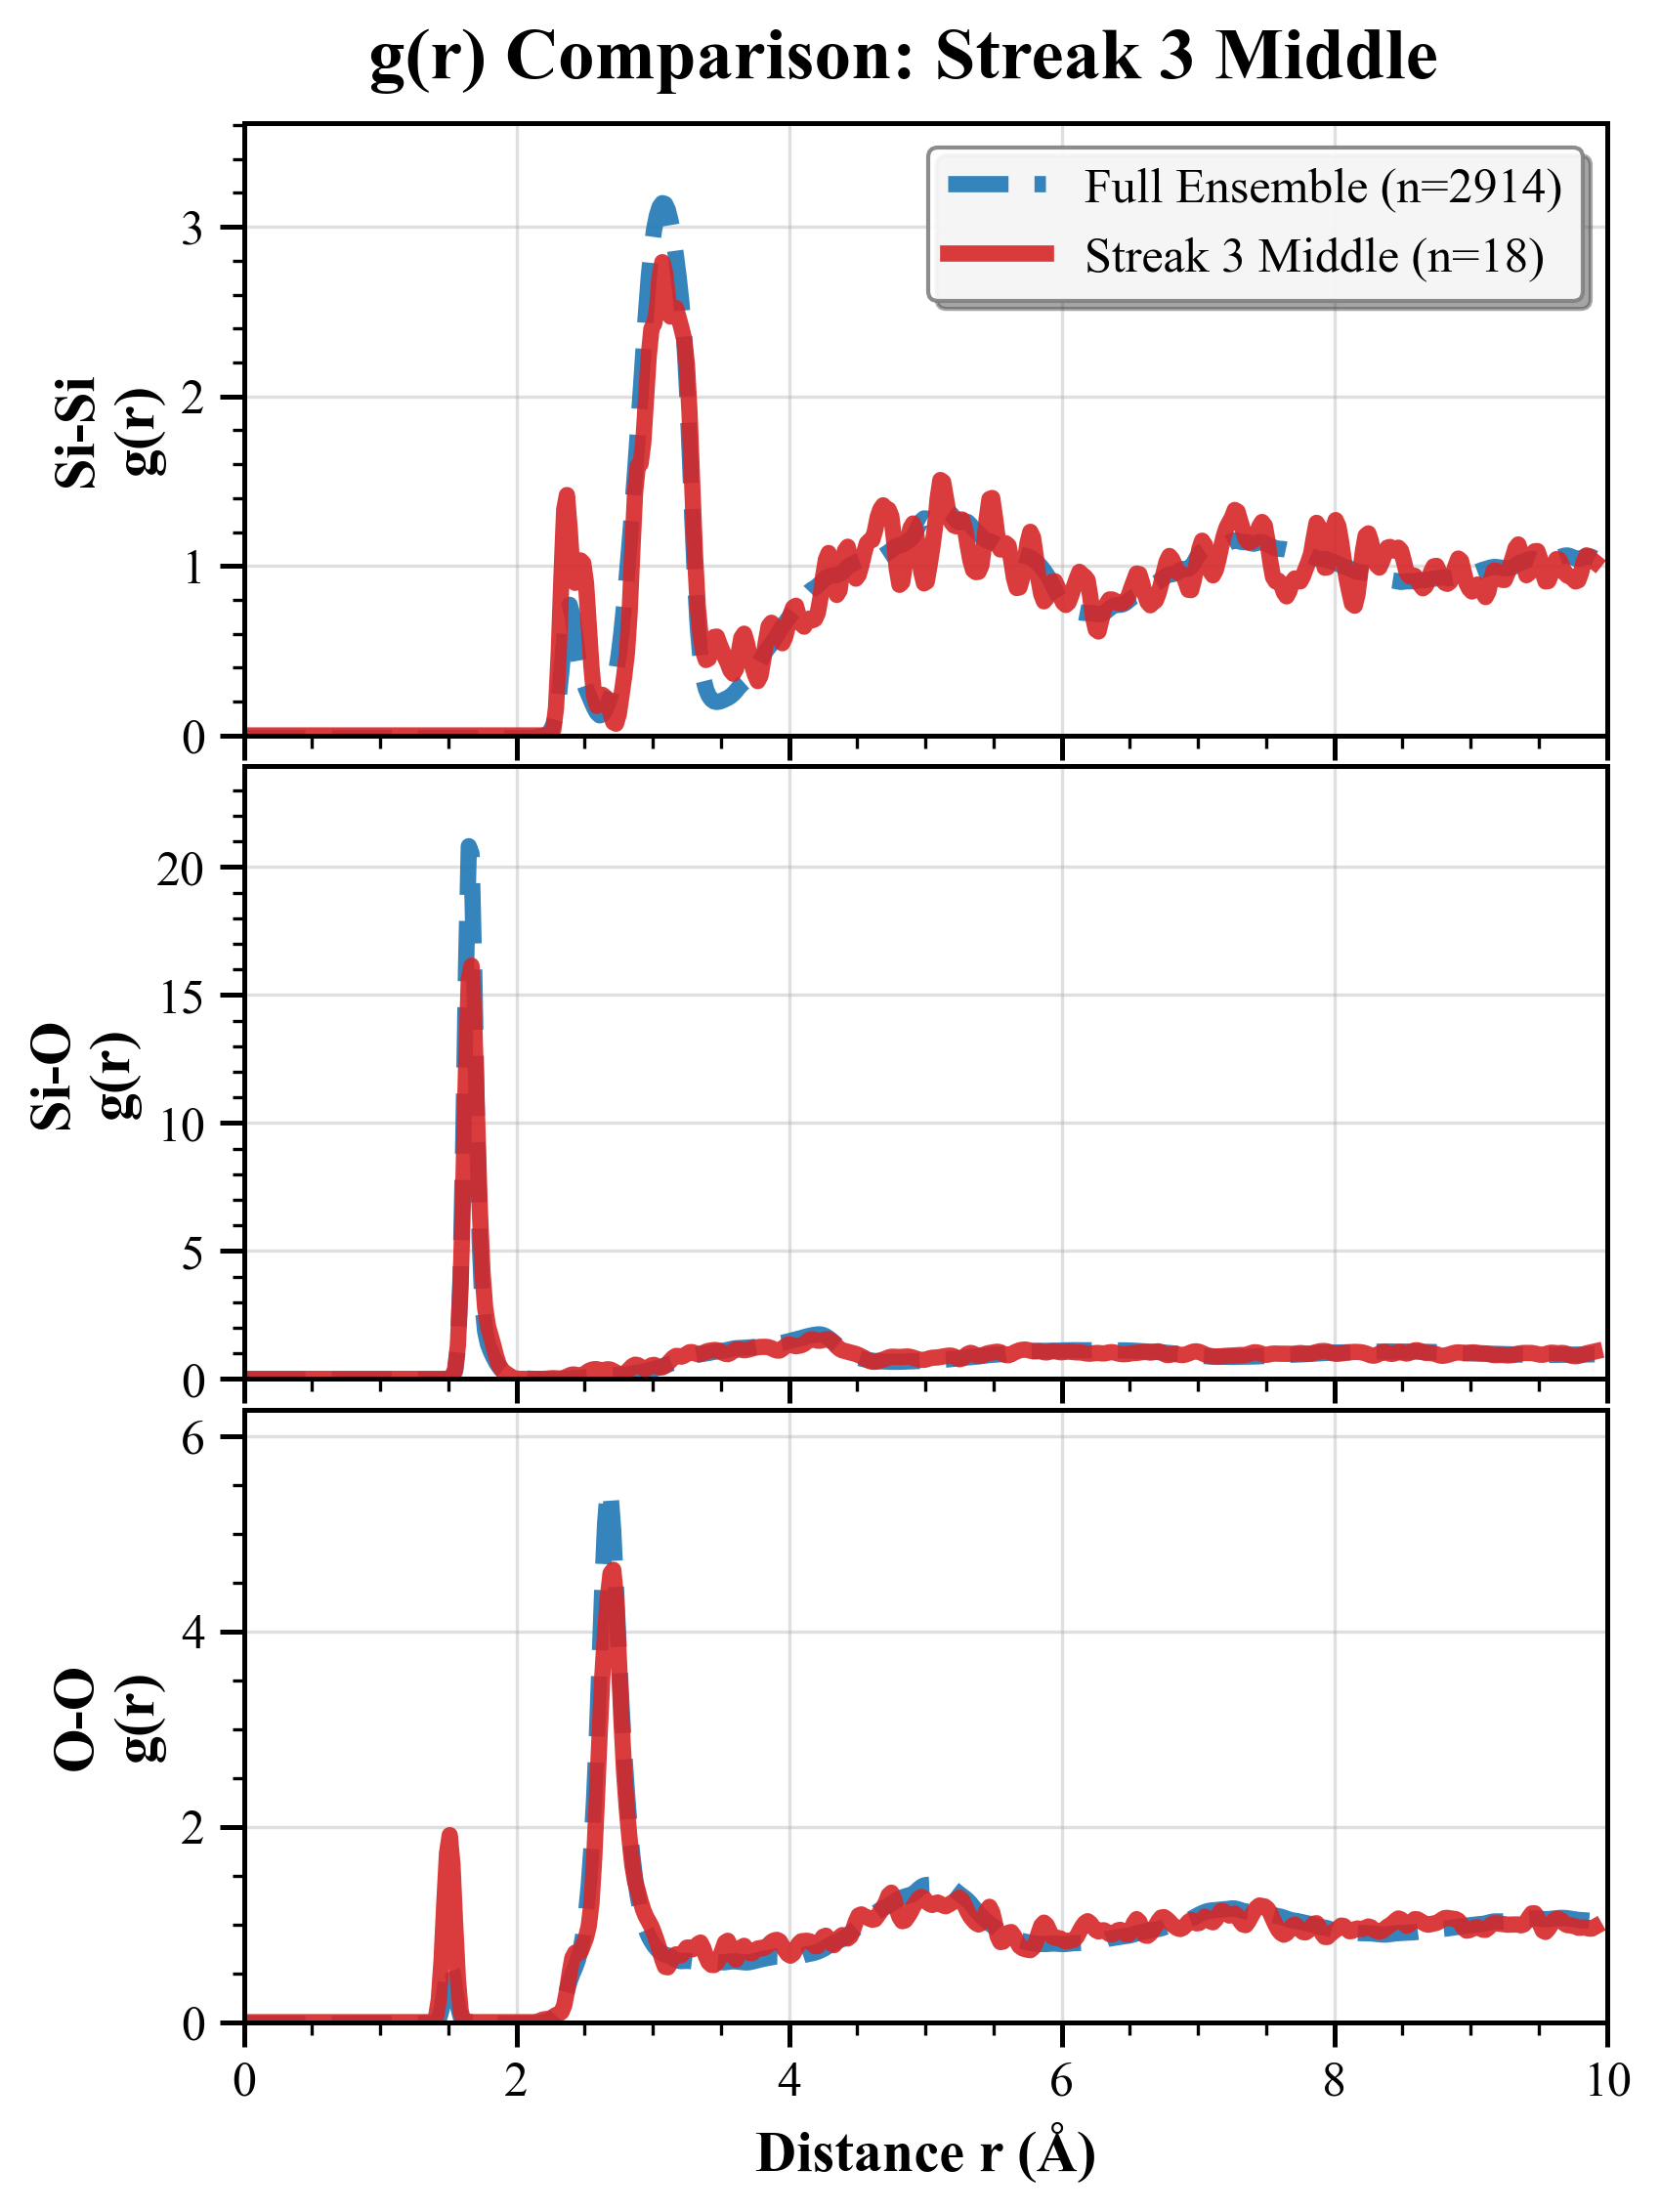


Regional RDF analysis complete!


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import src.rdf_v2 as rdf
import src.data_management_v2 as dm

# Set publication-quality plot parameters (adapted from your code)
plt.rcParams.update({
    'font.size': 14,           # Smaller base font size
    'axes.titlesize': 16,      # Subplot titles
    'axes.labelsize': 14,      # Axis labels
    'xtick.labelsize': 12,     # X-axis tick labels
    'ytick.labelsize': 12,     # Y-axis tick labels
    'legend.fontsize': 12,     # Legend
    'figure.titlesize': 18,    # Main title
    'lines.linewidth': 3,      # Default line width
    'grid.linewidth': 0.8,     # Grid line width
    'axes.linewidth': 1.2,     # Axes outline width
    'xtick.major.width': 1.2,  # Tick width
    'ytick.major.width': 1.2,
    'font.family': 'serif',    # Use serif font for academic look
    'text.usetex': False,      
})

# Define theme colors
color_full = '#1f77b4'    # Professional blue for full ensemble
color_region = '#d62728'  # Professional red for region

# Extract data from streak_results
energies = streak_results['energies_clean']
entropies = streak_results['entropies_clean']
struct_ids = streak_results['struct_ids_clean']
streak_labels = streak_results['all_streak_labels']

# Get structures for each streak
streak_0_mask = streak_labels == 0
streak_1_mask = streak_labels == 1  
streak_2_mask = streak_labels == 2

def select_region_structures(energies, entropies, struct_ids, n_select=50, region='top_right'):
    """Select structures from a specific region"""
    if region == 'top_right':
        energy_thresh = np.percentile(energies, 75)
        entropy_thresh = np.percentile(entropies, 75)
        mask = (energies >= energy_thresh) & (entropies >= entropy_thresh)
    elif region == 'bottom_left':
        energy_thresh = np.percentile(energies, 25)
        entropy_thresh = np.percentile(entropies, 25)
        mask = (energies <= energy_thresh) & (entropies <= entropy_thresh)
    elif region == 'middle':
        energy_range = np.percentile(energies, [40, 60])
        entropy_range = np.percentile(entropies, [40, 60])
        mask = ((energies >= energy_range[0]) & (energies <= energy_range[1]) & 
                (entropies >= entropy_range[0]) & (entropies <= entropy_range[1]))
    
    selected_ids = struct_ids[mask]
    if len(selected_ids) >= n_select:
        np.random.seed(42)
        selected_ids = np.random.choice(selected_ids, n_select, replace=False)
    
    return selected_ids

# Select structures from each region
regions = {
    'Streak 1 Top Right': select_region_structures(
        energies[streak_2_mask], entropies[streak_2_mask], 
        struct_ids[streak_2_mask], region='top_right'),
    'Streak 1 Bottom Left': select_region_structures(
        energies[streak_2_mask], entropies[streak_2_mask], 
        struct_ids[streak_2_mask], region='bottom_left'),
    'Streak 2 Top Right': select_region_structures(
        energies[streak_1_mask], entropies[streak_1_mask], 
        struct_ids[streak_1_mask], region='top_right'),
    'Streak 2 Bottom Left': select_region_structures(
        energies[streak_1_mask], entropies[streak_1_mask], 
        struct_ids[streak_1_mask], region='bottom_left'),
    'Streak 3 Middle': select_region_structures(
        energies[streak_0_mask], entropies[streak_0_mask], 
        struct_ids[streak_0_mask], region='middle')
}

print("="*60)
print("REGIONAL STRUCTURE SELECTIONS")
print("="*60)
for region_name, ids in regions.items():
    print(f"\n{region_name}: {len(ids)} structures")

# Calculate full ensemble RDF for comparison
print(f"\nCalculating full ensemble RDFs for {len(struct_ids)} structures...")
full_ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(
    struct_ids=struct_ids.tolist(), 
    temperature=1800, 
    smoothed=True
)

# Create plots for each region
pairs_to_plot = [('Si', 'Si'), ('Si', 'O'), ('O', 'O')]
pair_labels = ['Si-Si', 'Si-O', 'O-O']

for region_name, region_ids in regions.items():
    print(f"\nProcessing {region_name}...")
    
    # Calculate ensemble RDFs for this region
    region_rdfs = rdf.calculate_ensemble_partial_rdfs(
        struct_ids=region_ids.tolist(),
        temperature=1800,
        smoothed=True
    )
    
    # Create high-quality figure   figsize=(10, 8)
    fig, axes = plt.subplots(3, 1, figsize=(6, 8), dpi=300, 
                            gridspec_kw={'hspace': 0.05})
    
    for i, (pair, label, ax) in enumerate(zip(pairs_to_plot, pair_labels, axes)):
        # Track y-values for this subplot
        subplot_y_values = []
        
        # Plot full ensemble with thick, smooth lines
        if pair in full_ensemble_rdfs:
            r_full, g_full = full_ensemble_rdfs[pair]
            ax.plot(r_full, g_full, '--', linewidth=4, 
                    label=f'Full Ensemble (n={len(struct_ids)})', 
                    color=color_full, alpha=0.9)
            subplot_y_values.extend(g_full)
        
        # Plot region ensemble with thick, smooth lines
        if pair in region_rdfs:
            r_region, g_region = region_rdfs[pair]
            ax.plot(r_region, g_region, '-', linewidth=4,
                    label=f'{region_name} (n={len(region_ids)})', 
                    color=color_region, alpha=0.9)
            subplot_y_values.extend(g_region)
        
        # Set axis ranges with proper padding
        ax.set_xlim(0, 10)
        
        # Set y-axis to capture this subplot's data range with padding
        if subplot_y_values:
            y_min, y_max = min(subplot_y_values), max(subplot_y_values)
            y_padding = (y_max - y_min) * 0.15 if y_max > y_min else 0.1
            ax.set_ylim(max(0, y_min - y_padding), y_max + y_padding)
        
        # CONDENSED LABELING: Put pair type on y-axis, only x-label on bottom
        if i == len(axes) - 1:  # Only bottom subplot gets x-label
            ax.set_xlabel('Distance r (Å)', fontweight='bold')
        else:
            ax.set_xticklabels([])  # Remove x-tick labels for top plots
        
        # Use y-label to show the pair type
        ax.set_ylabel(f'{label}\ng(r)', fontweight='bold', ha='center')
        
        # Only show legend on top plot
        if i == 0:
            ax.legend(frameon=True, fancybox=True, shadow=True, 
                     facecolor='white', edgecolor='gray', framealpha=0.9,
                     loc='upper right')
        
        # Improve grid appearance
        ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Add minor ticks for professional look
        ax.tick_params(which='major', length=6, width=1.2)
        ax.tick_params(which='minor', length=3, width=0.8)
        ax.minorticks_on()
    
    # Add overall title
    fig.suptitle(f'g(r) Comparison: {region_name}', 
                 fontweight='bold', y=0.96, fontsize=18)
    
    # Tight layout for condensed appearance
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.05)
    
    plt.show()

print("\nRegional RDF analysis complete!")

Loaded 2914 structure IDs
Calculating full ensemble RDFs...


Calculating ensemble partial RDFs: 100%|██████████| 2914/2914 [00:00<00:00, 26919.67it/s]


Computing single random baseline for all metrics...


Calculating ensemble partial RDFs: 100%|██████████| 250/250 [00:00<00:00, 42638.91it/s]


Computing regional sampling results...
Processing sample size 25...


Calculating ensemble partial RDFs: 100%|██████████| 25/25 [00:00<00:00, 35665.85it/s]


Processing sample size 50...


Calculating ensemble partial RDFs: 100%|██████████| 50/50 [00:00<00:00, 23030.44it/s]


Processing sample size 75...


Calculating ensemble partial RDFs: 100%|██████████| 75/75 [00:00<00:00, 43133.53it/s]


Processing sample size 100...


Calculating ensemble partial RDFs: 100%|██████████| 100/100 [00:00<00:00, 37339.13it/s]


Processing sample size 125...


Calculating ensemble partial RDFs: 100%|██████████| 125/125 [00:00<00:00, 34838.73it/s]


Processing sample size 150...


Calculating ensemble partial RDFs: 100%|██████████| 150/150 [00:00<00:00, 44067.07it/s]


Processing sample size 175...


Calculating ensemble partial RDFs: 100%|██████████| 175/175 [00:00<00:00, 20530.98it/s]


Processing sample size 200...


Calculating ensemble partial RDFs: 100%|██████████| 200/200 [00:00<00:00, 43020.71it/s]


Processing sample size 225...


Calculating ensemble partial RDFs: 100%|██████████| 225/225 [00:00<00:00, 46573.48it/s]


Processing sample size 250...


Calculating ensemble partial RDFs: 100%|██████████| 250/250 [00:00<00:00, 46075.05it/s]


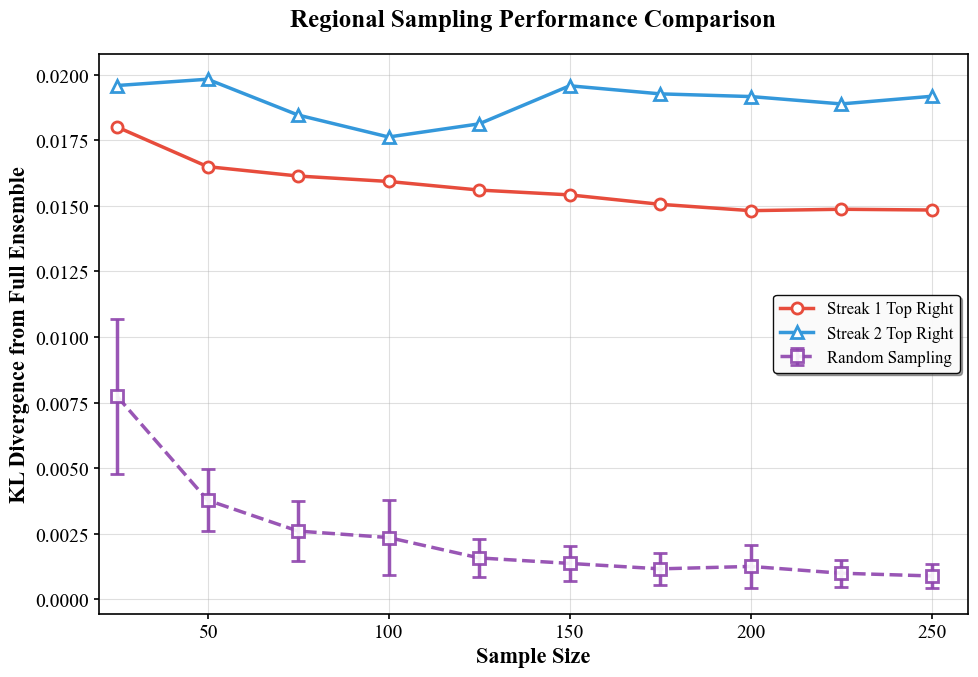


REGIONAL SAMPLING ANALYSIS SUMMARY

Streak 1 Top Right:
  Final KL Divergence (n=250):
    Streak 1 Top Right: 0.0148
    Random:  0.0009
    Ratio:   16.58x
    ❌ Streak 1 Top Right performs 1557.5% WORSE than random

Streak 2 Top Right:
  Final KL Divergence (n=250):
    Streak 2 Top Right: 0.0192
    Random:  0.0009
    Ratio:   21.42x
    ❌ Streak 2 Top Right performs 2041.7% WORSE than random


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import src.rdf_v2 as rdf
import src.data_management_v2 as dm
import src.ensembles_v2 as ensembles

# Set matplotlib parameters for LaTeX-style formatting (matching your style)
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.titlesize': 20,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.0
})

# Define consistent color scheme with better contrast
colors = {
    'Streak 1 Top Right': '#E74C3C',      # Strong red
    'Streak 1 Bottom Left': '#2ECC71',    # Strong green  
    'Streak 2 Top Right': '#3498DB',      # Strong blue
    'Streak 2 Bottom Left': '#F39C12',    # Orange
    'Random Sampling': '#8E44AD'          # Purple
}

def calculate_kl_divergence_rdf(rdf_calc, rdf_ref):
    """Calculate KL divergence between two RDFs"""
    # Fix negative RDF values
    rdf_calc_fixed = np.maximum(rdf_calc, 0.0)
    rdf_ref_fixed = np.maximum(rdf_ref, 0.0)
    
    # Add small epsilon to avoid log(0)
    epsilon = 1e-12
    rdf_calc_fixed = rdf_calc_fixed + epsilon
    rdf_ref_fixed = rdf_ref_fixed + epsilon
    
    # Normalize to probability distributions
    rdf_calc_norm = rdf_calc_fixed / np.sum(rdf_calc_fixed)
    rdf_ref_norm = rdf_ref_fixed / np.sum(rdf_ref_fixed)
    
    # Calculate KL divergence: KL(P||Q) = sum(P * log(P/Q))
    kl_div = np.sum(rdf_ref_norm * np.log(rdf_ref_norm / rdf_calc_norm))
    
    return kl_div

def select_region_structures_sized(energies, entropies, struct_ids, n_select, region='top_right', seed=42):
    """Select n_select structures from a specific region"""
    if region == 'top_right':
        energy_thresh = np.percentile(energies, 75)
        entropy_thresh = np.percentile(entropies, 75)
        mask = (energies >= energy_thresh) & (entropies >= entropy_thresh)
    elif region == 'bottom_left':
        energy_thresh = np.percentile(energies, 25)
        entropy_thresh = np.percentile(entropies, 25)
        mask = (energies <= energy_thresh) & (entropies <= entropy_thresh)
    
    selected_ids = struct_ids[mask]
    if len(selected_ids) >= n_select:
        np.random.seed(seed)
        selected_ids = np.random.choice(selected_ids, n_select, replace=False)
    
    return selected_ids

# Extract data from streak_results
energies = streak_results['energies_clean']
entropies = streak_results['entropies_clean']
struct_ids = streak_results['struct_ids_clean']
streak_labels = streak_results['all_streak_labels']

# Get structures for streaks 1 and 2
streak_1_mask = streak_labels == 1
streak_2_mask = streak_labels == 2

print(f"Loaded {len(struct_ids)} structure IDs")

# Calculate full ensemble RDFs for reference
print("Calculating full ensemble RDFs...")
full_ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(
    struct_ids=struct_ids.tolist(), 
    temperature=1800, 
    use_weights=False, 
    smoothed=True
)

# Define sample sizes and trials
sample_sizes = list(range(25, 275, 25))
n_trials = 10

# Methods to compare
methods = {
    'Streak 1 Top Right': {'streak': 1, 'region': 'top_right'},
    # 'Streak 1 Bottom Left': {'streak': 1, 'region': 'bottom_left'},
    'Streak 2 Top Right': {'streak': 2, 'region': 'top_right'},
    # 'Streak 2 Bottom Left': {'streak': 2, 'region': 'bottom_left'}
}

# Store results
results = {}
for method_name in methods:
    results[method_name] = {'sample_sizes': [], 'kl_values': []}

# Compute single random baseline for all metrics
print("Computing single random baseline for all metrics...")
random_kls = []
random_stds = []

for sample_size in sample_sizes:
    trial_kls = []
    for trial in range(n_trials):
        np.random.seed(42 + trial)  # Different seed for each trial
        random_ids = np.random.choice(struct_ids, size=sample_size, replace=False)
        random_rdfs = rdf.calculate_ensemble_partial_rdfs(
            random_ids.tolist(), 
            temperature=1800, 
            use_weights=False, 
            smoothed=True
        )

        # Calculate average KL divergence
        total_kl = 0
        pair_count = 0
        
        for pair in [('Si', 'Si'), ('Si', 'O'), ('O', 'O')]:
            if pair in full_ensemble_rdfs and pair in random_rdfs:
                r_full, g_full = full_ensemble_rdfs[pair]
                r_sample, g_sample = random_rdfs[pair]
                
                kl_div = ensembles.calculate_counting_error(g_sample, g_full, r_full, method='kl_divergence')
                total_kl += kl_div
                pair_count += 1
        
        avg_kl = total_kl / pair_count if pair_count > 0 else 0
        trial_kls.append(avg_kl)
    
    random_kls.append(np.mean(trial_kls))
    random_stds.append(np.std(trial_kls))

# Compute regional sampling results
print("Computing regional sampling results...")
for sample_size in sample_sizes:
    print(f"Processing sample size {sample_size}...")
    
    for method_name, method_config in methods.items():
        streak = method_config['streak']
        region = method_config['region']
        
        # Get mask for this streak
        streak_mask = streak_labels == streak
        
        # Select structures from region
        selected_ids = select_region_structures_sized(
            energies[streak_mask], 
            entropies[streak_mask], 
            struct_ids[streak_mask], 
            sample_size, 
            region
        )
        
        if len(selected_ids) > 0:
            # Calculate RDF for this regional sample
            sample_rdfs = rdf.calculate_ensemble_partial_rdfs(
                selected_ids.tolist(),
                temperature=1800,
                use_weights=False,
                smoothed=True
            )
            
            # Calculate average KL divergence
            total_kl = 0
            pair_count = 0
            
            for pair in [('Si', 'Si'), ('Si', 'O'), ('O', 'O')]:
                if pair in sample_rdfs and pair in full_ensemble_rdfs:
                    r_sample, g_sample = sample_rdfs[pair]
                    r_full, g_full = full_ensemble_rdfs[pair]
                    
                    kl_div = ensembles.calculate_counting_error(g_sample, g_full, r_full, method='kl_divergence')
                    total_kl += kl_div
                    pair_count += 1
            
            avg_kl = total_kl / pair_count if pair_count > 0 else 0
            results[method_name]['sample_sizes'].append(sample_size)
            results[method_name]['kl_values'].append(avg_kl)

# Create single plot with LaTeX formatting
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot single random baseline with error bars
ax.errorbar(sample_sizes, random_kls, yerr=random_stds, 
           color=colors['Random Sampling'], linestyle='--', linewidth=2.5, alpha=0.9, 
           capsize=5, markersize=8, marker='s', markerfacecolor='white',
           markeredgewidth=2, label='Random Sampling')

# Plot each regional method's performance
markers = ['o', '^', 'D', 'v']
for i, (method_name, method_results) in enumerate(results.items()):
    if method_results['sample_sizes']:
        color = colors[method_name]
        marker = markers[i % len(markers)]
        ax.plot(method_results['sample_sizes'], method_results['kl_values'], 
                marker=marker, color=color, linewidth=2.5, markersize=8, 
                markerfacecolor='white', markeredgewidth=2, markeredgecolor=color,
                label=method_name)

# Formatting for LaTeX document style
ax.set_xlabel('Sample Size', fontweight='bold')
ax.set_ylabel('KL Divergence from Full Ensemble', fontweight='bold')
ax.set_title('Regional Sampling Performance Comparison', fontweight='bold', pad=20)

# Legend formatting
legend = ax.legend(frameon=True, fancybox=True, shadow=True, 
                  framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

# Grid formatting
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)

# Axis formatting
ax.set_xlim(20, 260)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)

# Tight layout
plt.tight_layout()

# Display the plot
plt.show()

# Print summary with better formatting
print("\n" + "="*60)
print("REGIONAL SAMPLING ANALYSIS SUMMARY")
print("="*60)

for method_name, method_results in results.items():
    if method_results['sample_sizes']:
        regional_final = method_results['kl_values'][-1]
        random_final = random_kls[-1]
        
        print(f"\n{method_name}:")
        print(f"  Final KL Divergence (n=250):")
        print(f"    {method_name}: {regional_final:.4f}")
        print(f"    Random:  {random_final:.4f}")
        print(f"    Ratio:   {regional_final/random_final:.2f}x")
        
        if regional_final > random_final:
            print(f"    ❌ {method_name} performs {((regional_final/random_final-1)*100):.1f}% WORSE than random")
        else:
            print(f"    ✅ {method_name} performs better than random")

Calculating full ensemble RDFs...


Calculating ensemble partial RDFs: 100%|██████████| 2914/2914 [00:00<00:00, 38320.36it/s]


Pre-computing individual RDFs for 2914 structures...


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 4928.68it/s]


  Completed 100/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 6403.52it/s]


  Completed 200/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 2142.14it/s]


  Completed 300/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 2331.46it/s]


  Completed 400/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 1650.00it/s]


  Completed 500/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 8004.40it/s]


  Completed 600/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 3214.03it/s]


  Completed 700/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 3030.57it/s]


  Completed 800/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 1933.75it/s]


  Completed 900/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 3964.37it/s]


  Completed 1000/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 4064.25it/s]


  Completed 1100/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 5526.09it/s]


  Completed 1200/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 7626.01it/s]


  Completed 1300/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 2480.37it/s]


  Completed 1400/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 6374.32it/s]


  Completed 1500/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 2968.37it/s]


  Completed 1600/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 5282.50it/s]


  Completed 1700/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 4760.84it/s]


  Completed 1800/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 2066.16it/s]


  Completed 1900/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 5983.32it/s]


  Completed 2000/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 5152.71it/s]


  Completed 2100/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 5178.15it/s]


  Completed 2200/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 7256.58it/s]


  Completed 2300/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 3498.17it/s]


  Completed 2400/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 2637.93it/s]


  Completed 2500/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 8774.69it/s]


  Completed 2600/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 7449.92it/s]


  Completed 2700/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 6853.44it/s]


  Completed 2800/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 5005.14it/s]


  Completed 2900/2914 individual RDFs


Calculating ensemble partial RDFs: 100%|██████████| 1/1 [00:00<00:00, 6374.32it/s]


Computing random sampling baseline...
Computing incremental optimal selections...
Building incremental optimal selection up to 750 structures...
  Completed size 50, KL: 0.000411
  Completed size 100, KL: 0.000130
  Completed size 150, KL: 0.000073
  Completed size 200, KL: 0.000050
  Completed size 250, KL: 0.000036
  Completed size 300, KL: 0.000028
  Completed size 350, KL: 0.000022
  Completed size 400, KL: 0.000019
  Completed size 450, KL: 0.000017
  Completed size 500, KL: 0.000015
  Completed size 550, KL: 0.000014
  Completed size 600, KL: 0.000012
  Completed size 650, KL: 0.000011
  Completed size 700, KL: 0.000011
  Completed size 750, KL: 0.000010


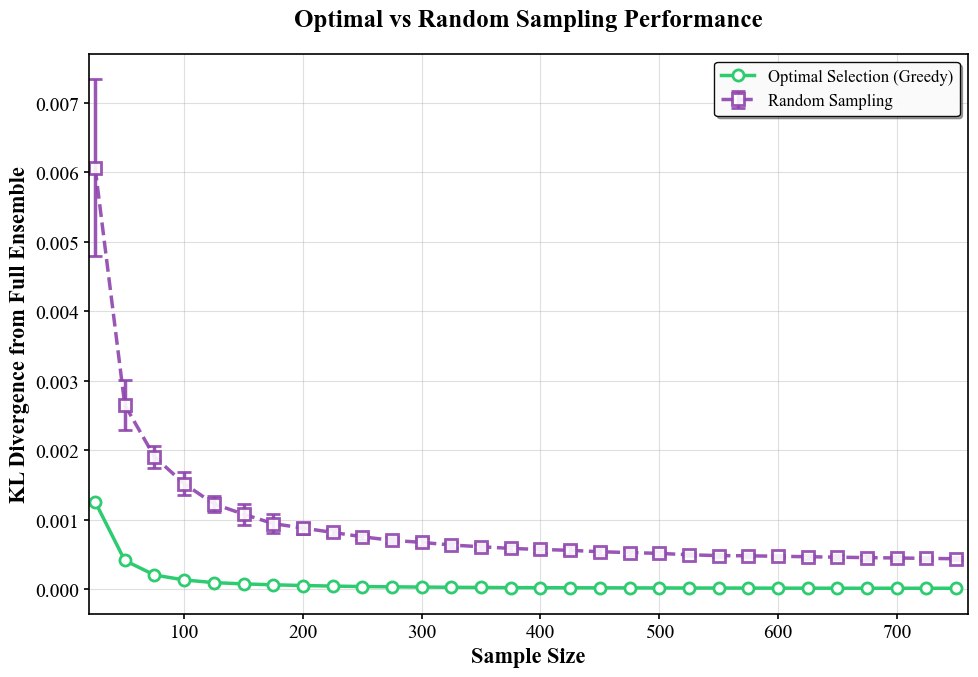


OPTIMAL VS RANDOM SAMPLING COMPARISON
Sample size  25: Random 0.006063, Optimal 0.001256 (+79.3% improvement)
Sample size  50: Random 0.002649, Optimal 0.000411 (+84.5% improvement)
Sample size 100: Random 0.001515, Optimal 0.000130 (+91.4% improvement)
Sample size 200: Random 0.000877, Optimal 0.000050 (+94.3% improvement)
Sample size 500: Random 0.000513, Optimal 0.000015 (+97.0% improvement)
Sample size 750: Random 0.000435, Optimal 0.000010 (+97.6% improvement)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import src.rdf_v2 as rdf
import src.data_management_v2 as dm
import src.ensembles_v2 as ensembles

# Same LaTeX formatting with purple for random sampling
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.titlesize': 20,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.5
})

def average_precomputed_rdfs(individual_rdf_list):
    """Average a list of individual RDF dictionaries"""
    if not individual_rdf_list:
        return {}
    
    pairs = list(individual_rdf_list[0].keys())
    averaged_rdfs = {}
    
    for pair in pairs:
        r_values = individual_rdf_list[0][pair][0]
        all_g_values = [rdf_dict[pair][1] for rdf_dict in individual_rdf_list if pair in rdf_dict]
        
        if all_g_values:
            avg_g = np.mean(all_g_values, axis=0)
            averaged_rdfs[pair] = (r_values, avg_g)
    
    return averaged_rdfs

def calculate_total_kl(ensemble_rdf, full_ensemble_rdfs):
    """Calculate total KL divergence across all partial RDFs"""
    total_kl = 0
    pair_count = 0
    
    for pair in [('Si', 'Si'), ('Si', 'O'), ('O', 'O')]:
        if pair in ensemble_rdf and pair in full_ensemble_rdfs:
            r_test, g_test = ensemble_rdf[pair]
            r_full, g_full = full_ensemble_rdfs[pair]
            
            kl_div = ensembles.calculate_counting_error(g_test, g_full, r_full, method='kl_divergence')
            total_kl += kl_div
            pair_count += 1
    
    return total_kl / pair_count if pair_count > 0 else float('inf')

def incremental_greedy_selection(struct_ids, full_ensemble_rdfs, individual_rdfs, max_size):
    """
    Incrementally build optimal selection up to max_size
    Returns dictionary with sample_size: (selected_ids, kl_value)
    """
    selected_ids = []
    remaining_ids = list(struct_ids)
    results = {}
    
    print(f"Building incremental optimal selection up to {max_size} structures...")
    
    for target_size in range(1, max_size + 1):
        best_kl = float('inf')
        best_id = None
        
        # Find best structure to add
        for candidate_id in remaining_ids:
            test_subset = selected_ids + [candidate_id]
            test_rdf_list = [individual_rdfs[sid] for sid in test_subset]
            ensemble_rdf = average_precomputed_rdfs(test_rdf_list)
            kl = calculate_total_kl(ensemble_rdf, full_ensemble_rdfs)
            
            if kl < best_kl:
                best_kl = kl
                best_id = candidate_id
        
        # Add the best structure
        if best_id is not None:
            selected_ids.append(best_id)
            remaining_ids.remove(best_id)
            results[target_size] = (selected_ids.copy(), best_kl)
            
        if target_size % 50 == 0:
            print(f"  Completed size {target_size}, KL: {best_kl:.6f}")
    
    return results

# Get data
struct_ids = streak_results['struct_ids_clean']

# Calculate full ensemble RDFs for reference
print("Calculating full ensemble RDFs...")
full_ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(
    struct_ids.tolist(), temperature=1800, use_weights=False, smoothed=True
)

# Pre-compute individual RDFs for all structures
print(f"Pre-computing individual RDFs for {len(struct_ids)} structures...")
individual_rdfs = {}
for i, sid in enumerate(struct_ids):
    individual_rdfs[sid] = rdf.calculate_ensemble_partial_rdfs(
        [sid], temperature=1800, use_weights=False, smoothed=True
    )
    if (i + 1) % 100 == 0:
        print(f"  Completed {i + 1}/{len(struct_ids)} individual RDFs")

# Define sample sizes (up to 750)
sample_sizes = list(range(25, 775, 25))
n_trials = 10

# Calculate random sampling baseline
print("Computing random sampling baseline...")
random_kls = []
random_stds = []

for sample_size in sample_sizes:
    trial_kls = []
    for trial in range(n_trials):
        np.random.seed(42 + trial)
        random_ids = np.random.choice(struct_ids, size=sample_size, replace=False)
        
        random_rdf_list = [individual_rdfs[sid] for sid in random_ids]
        random_ensemble_rdf = average_precomputed_rdfs(random_rdf_list)
        
        kl = calculate_total_kl(random_ensemble_rdf, full_ensemble_rdfs)
        trial_kls.append(kl)
    
    random_kls.append(np.mean(trial_kls))
    random_stds.append(np.std(trial_kls))

# Calculate incremental optimal selection
print("Computing incremental optimal selections...")
max_sample_size = max(sample_sizes)
optimal_results = incremental_greedy_selection(
    struct_ids, full_ensemble_rdfs, individual_rdfs, max_sample_size
)

# Extract optimal KL values for our sample sizes
optimal_kls = []
for size in sample_sizes:
    if size in optimal_results:
        optimal_kls.append(optimal_results[size][1])
    else:
        optimal_kls.append(None)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot random sampling with error bars (purple like your other plot)
ax.errorbar(sample_sizes, random_kls, yerr=random_stds, 
           color='#8E44AD', linestyle='--', linewidth=2.5, alpha=0.9, 
           capsize=5, markersize=8, marker='s', markerfacecolor='white',
           markeredgewidth=2, label='Random Sampling')

# Plot optimal selection
ax.plot(sample_sizes, optimal_kls, 
        marker='o', color='#2ECC71', linewidth=2.5, markersize=8, 
        markerfacecolor='white', markeredgewidth=2, markeredgecolor='#2ECC71',
        label='Optimal Selection (Greedy)')

# Formatting
ax.set_xlabel('Sample Size', fontweight='bold')
ax.set_ylabel('KL Divergence from Full Ensemble', fontweight='bold')
ax.set_title('Optimal vs Random Sampling Performance', fontweight='bold', pad=20)

# Legend formatting
legend = ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

# Grid and axis formatting
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.set_xlim(20, 760)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

# Print comparison for key sizes
print("\n" + "="*60)
print("OPTIMAL VS RANDOM SAMPLING COMPARISON")
print("="*60)

key_sizes = [25, 50, 100, 200, 500, 750]
for size in key_sizes:
    if size in sample_sizes:
        idx = sample_sizes.index(size)
        improvement = (random_kls[idx] - optimal_kls[idx]) / random_kls[idx] * 100
        print(f"Sample size {size:3d}: Random {random_kls[idx]:.6f}, Optimal {optimal_kls[idx]:.6f} ({improvement:+.1f}% improvement)")

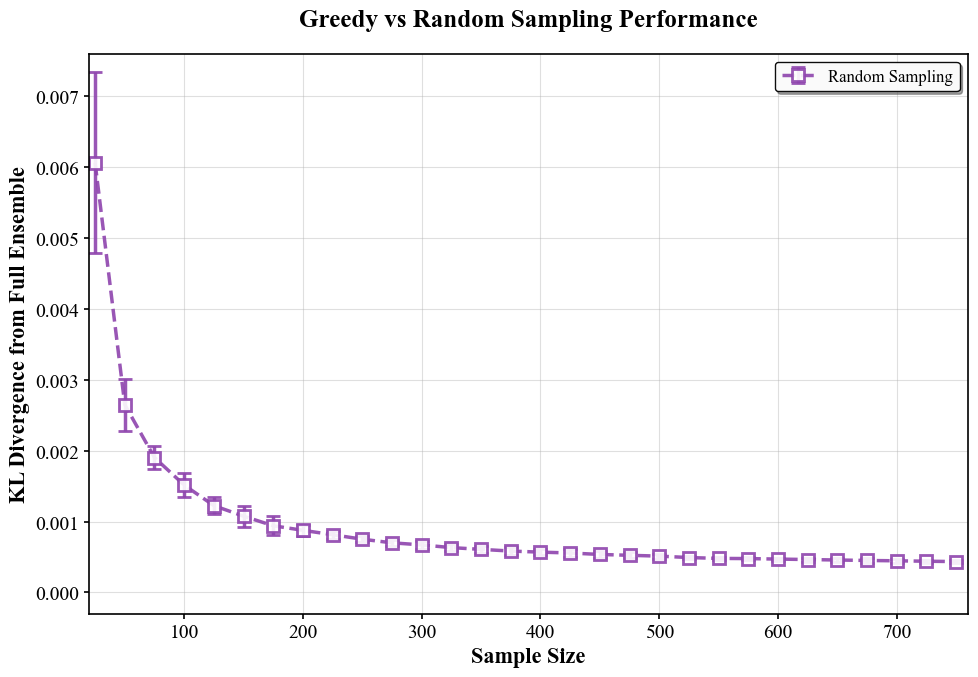

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Same LaTeX formatting with purple for random sampling
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'figure.titlesize': 20,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.5
})

# Plot random sampling with error bars (purple like your other plot)
ax.errorbar(sample_sizes, random_kls, yerr=random_stds, 
           color='#8E44AD', linestyle='--', linewidth=2.5, alpha=0.9, 
           capsize=5, markersize=8, marker='s', markerfacecolor='white',
           markeredgewidth=2, label='Random Sampling')

# # Plot optimal selection
# ax.plot(sample_sizes, optimal_kls, 
#         marker='o', color='#2ECC71', linewidth=2.5, markersize=8, 
#         markerfacecolor='white', markeredgewidth=2, markeredgecolor='#2ECC71',
#         label='Greedy Selection')

# Formatting
ax.set_xlabel('Sample Size', fontweight='bold')
ax.set_ylabel('KL Divergence from Full Ensemble', fontweight='bold')
ax.set_title('Greedy vs Random Sampling Performance', fontweight='bold', pad=20)

# Legend formatting
legend = ax.legend(frameon=True, fancybox=True, shadow=True, framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1)

# Grid and axis formatting
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
ax.set_axisbelow(True)
ax.set_xlim(20, 760)
ax.set_ylim(-0.0003, 0.0076)

for spine in ax.spines.values():
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

Loaded 2914 structure IDs
Calculating full ensemble RDFs...


Calculating ensemble partial RDFs: 100%|██████████| 2914/2914 [00:00<00:00, 38067.09it/s]


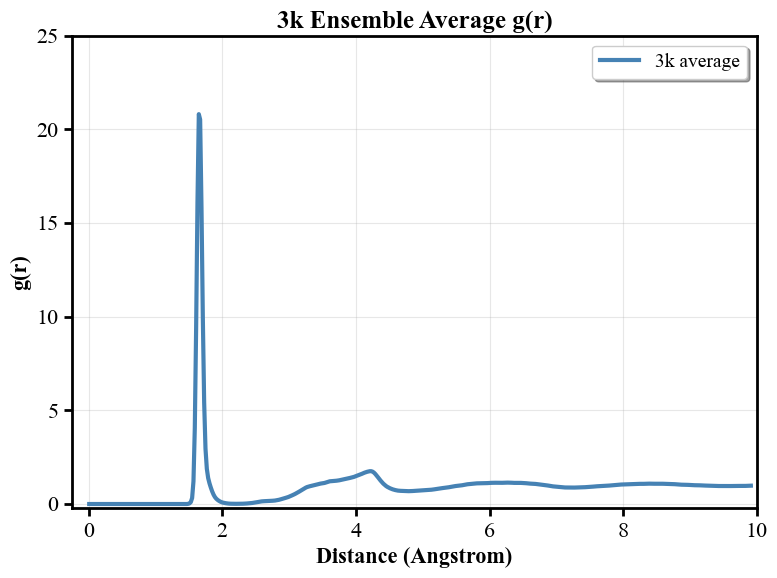

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import src.rdf_v2 as rdf
import src.data_management_v2 as dm

# Load structure IDs (same as your existing setup)
folder_path = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/3k_poscar"
vasp_files = [f for f in os.listdir(folder_path) if f.endswith('.vasp')]
struct_ids = [int(f.replace('.vasp', '')) for f in vasp_files]
struct_ids.sort()

print(f"Loaded {len(struct_ids)} structure IDs")

# Calculate full ensemble RDFs
print("Calculating full ensemble RDFs...")
full_ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(struct_ids, temperature=1800, use_weights=False)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Extract the total RDF (sum of all partial RDFs weighted by their contributions)
# For now, let's plot Si-O since it's typically the dominant pair in SiO2
if ('Si', 'O') in full_ensemble_rdfs:
    r_values, g_r = full_ensemble_rdfs[('Si', 'O')]
    ax.plot(r_values, g_r, '-', color='steelblue', linewidth=3, label='3k average')

# Enhanced formatting with distinct labels
ax.set_xlabel('Distance (Angstrom)', fontsize=16, fontweight='bold')
ax.set_ylabel('g(r)', fontsize=16, fontweight='bold')
ax.set_title('3k Ensemble Average g(r)', fontsize=18, fontweight='bold')

# Make axis labels more distinct
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, width=1, length=4)

# Set axis limits to match the original
ax.set_xlim(-0.25, 10)
ax.set_ylim(-0.25, 25)

# Add grid and legend
ax.grid(True, alpha=0.3)
ax.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)

# Make the plot frame more prominent
for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

COORDINATION NUMBER ANALYSIS BY REGION

Processing Streak 2 Top Right (100 structures)...


Calculating ensemble partial RDFs: 100%|██████████| 100/100 [00:00<00:00, 43708.88it/s]


  Si-O coordination: 3.90
  Si-Si coordination: 1.20
  O-O coordination: 5.81

Processing Streak 2 Bottom Left (100 structures)...


Calculating ensemble partial RDFs: 100%|██████████| 100/100 [00:00<00:00, 32436.04it/s]


  Si-O coordination: 3.84
  Si-Si coordination: 1.08
  O-O coordination: 5.93

Processing Streak 1 Top Right (100 structures)...


Calculating ensemble partial RDFs: 100%|██████████| 100/100 [00:00<00:00, 43049.41it/s]


  Si-O coordination: 4.00
  Si-Si coordination: 1.22
  O-O coordination: 5.53

Processing Streak 1 Bottom Left (100 structures)...


Calculating ensemble partial RDFs: 100%|██████████| 100/100 [00:00<00:00, 44782.23it/s]


  Si-O coordination: 3.97
  Si-Si coordination: 0.98
  O-O coordination: 5.71

Processing Streak 0 Middle (18 structures)...


Calculating ensemble partial RDFs: 100%|██████████| 18/18 [00:00<00:00, 16145.74it/s]


  Si-O coordination: 4.04
  Si-Si coordination: 1.16
  O-O coordination: 5.34

Calculating full ensemble coordination (2914 structures)...


Calculating ensemble partial RDFs: 100%|██████████| 2914/2914 [00:00<00:00, 41036.41it/s]


  Full ensemble Si-O coordination: 3.94
  Full ensemble Si-Si coordination: 1.16
  Full ensemble O-O coordination: 5.74

COORDINATION NUMBER SUMMARY
Region                    Si-O     Si-Si    O-O     
----------------------------------------------------------------------
Streak 2 Top Right        3.90     1.20     5.81    
Streak 2 Bottom Left      3.84     1.08     5.93    
Streak 1 Top Right        4.00     1.22     5.53    
Streak 1 Bottom Left      3.97     0.98     5.71    
Streak 0 Middle           4.04     1.16     5.34    
Full Ensemble             3.94     1.16     5.74    


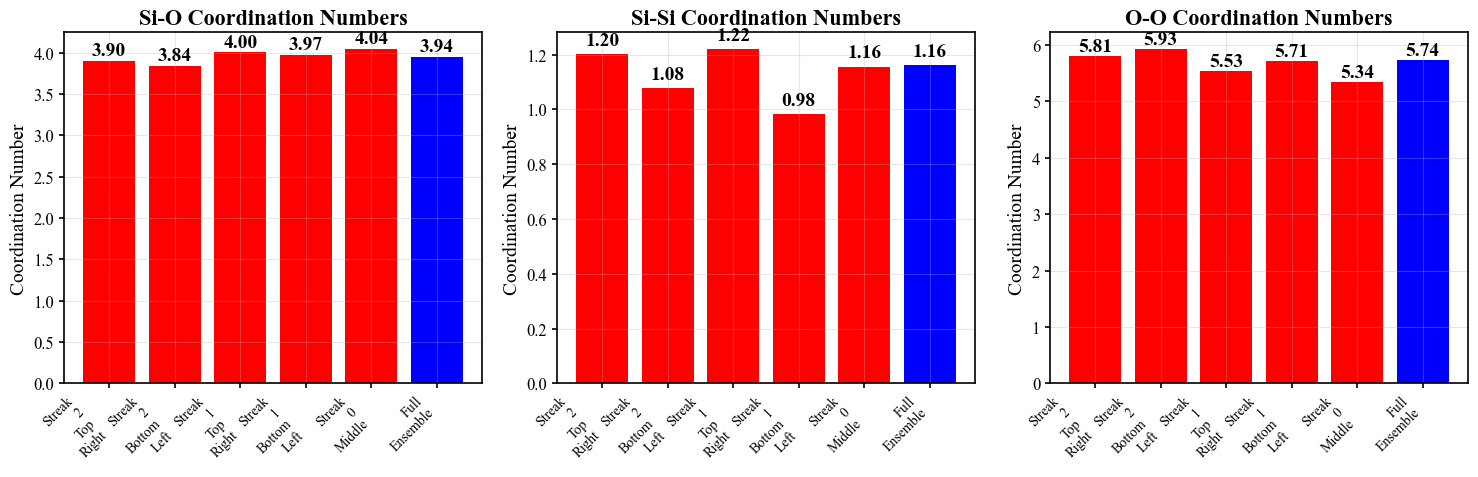

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import src.rdf_v2 as rdf
import src.data_management_v2 as dm

def calculate_coordination_numbers_from_rdf(r_values, g_r, pair_type, first_peak_limit=3.0):
    """
    Calculate coordination number by integrating RDF up to first minimum.
    
    Parameters:
    -----------
    r_values : array
        Distance values
    g_r : array  
        RDF values
    pair_type : tuple
        Element pair, e.g., ('Si', 'O')
    first_peak_limit : float
        Maximum distance to consider for first coordination shell
        
    Returns:
    --------
    float : Coordination number
    """
    # Find indices within the first coordination shell
    mask = r_values <= first_peak_limit
    r_shell = r_values[mask]
    g_shell = g_r[mask]
    
    if len(r_shell) == 0:
        return 0.0
    
    # For SiO2, use appropriate densities
    if pair_type == ('Si', 'O') or pair_type == ('O', 'Si'):
        # Si-O coordination: Use O density for Si neighbors
        rho = 0.044  # O atoms/Å³ approximate for SiO2
    elif pair_type == ('Si', 'Si'):
        rho = 0.022  # Si atoms/Å³ approximate for SiO2  
    elif pair_type == ('O', 'O'):
        rho = 0.044  # O atoms/Å³ approximate for SiO2
    else:
        rho = 0.033  # Default mixed density
    
    # Calculate coordination number: CN = ∫₀^r_cut 4πr²ρg(r)dr
    dr = r_shell[1] - r_shell[0] if len(r_shell) > 1 else 0.05
    integrand = 4 * np.pi * r_shell**2 * rho * g_shell
    coordination_number = np.trapz(integrand, dx=dr)
    
    return coordination_number

def analyze_region_coordination_numbers(streak_results):
    """
    Analyze coordination numbers for each region in streak_results.
    """
    # Extract data from streak_results
    energies = streak_results['energies_clean']
    entropies = streak_results['entropies_clean'] 
    struct_ids = streak_results['struct_ids_clean']
    streak_labels = streak_results['all_streak_labels']

    # Get structures for each streak
    streak_0_mask = streak_labels == 0
    streak_1_mask = streak_labels == 1  
    streak_2_mask = streak_labels == 2

    def select_region_structures(energies, entropies, struct_ids, n_select=100, region='top_right'):
        """Select structures from a specific region"""
        if region == 'top_right':
            energy_thresh = np.percentile(energies, 75)
            entropy_thresh = np.percentile(entropies, 75)
            mask = (energies >= energy_thresh) & (entropies >= entropy_thresh)
        elif region == 'bottom_left':
            energy_thresh = np.percentile(energies, 25)
            entropy_thresh = np.percentile(entropies, 25)
            mask = (energies <= energy_thresh) & (entropies <= entropy_thresh)
        elif region == 'middle':
            energy_range = np.percentile(energies, [40, 60])
            entropy_range = np.percentile(entropies, [40, 60])
            mask = ((energies >= energy_range[0]) & (energies <= energy_range[1]) & 
                    (entropies >= entropy_range[0]) & (entropies <= entropy_range[1]))
        
        selected_ids = struct_ids[mask]
        if len(selected_ids) >= n_select:
            np.random.seed(42)
            selected_ids = np.random.choice(selected_ids, n_select, replace=False)
        
        return selected_ids

    # Define regions
    regions = {
        'Streak 2 Top Right': select_region_structures(
            energies[streak_2_mask], entropies[streak_2_mask], 
            struct_ids[streak_2_mask], region='top_right'),
        'Streak 2 Bottom Left': select_region_structures(
            energies[streak_2_mask], entropies[streak_2_mask], 
            struct_ids[streak_2_mask], region='bottom_left'),
        'Streak 1 Top Right': select_region_structures(
            energies[streak_1_mask], entropies[streak_1_mask], 
            struct_ids[streak_1_mask], region='top_right'),
        'Streak 1 Bottom Left': select_region_structures(
            energies[streak_1_mask], entropies[streak_1_mask], 
            struct_ids[streak_1_mask], region='bottom_left'),
        'Streak 0 Middle': select_region_structures(
            energies[streak_0_mask], entropies[streak_0_mask], 
            struct_ids[streak_0_mask], region='middle')
    }

    # Calculate coordination numbers for each region
    coordination_results = {}
    pairs_to_analyze = [('Si', 'O'), ('Si', 'Si'), ('O', 'O')]

    print("="*70)
    print("COORDINATION NUMBER ANALYSIS BY REGION")
    print("="*70)

    for region_name, region_ids in regions.items():
        print(f"\nProcessing {region_name} ({len(region_ids)} structures)...")
        
        # Calculate ensemble RDFs for this region
        region_rdfs = rdf.calculate_ensemble_partial_rdfs(
            struct_ids=region_ids.tolist(),
            temperature=1800,
            smoothed=True
        )
        
        region_coords = {}
        
        for pair in pairs_to_analyze:
            if pair in region_rdfs:
                r_values, g_r = region_rdfs[pair]
                coord_num = calculate_coordination_numbers_from_rdf(
                    r_values, g_r, pair, first_peak_limit=3.0
                )
                region_coords[pair] = coord_num
                print(f"  {pair[0]}-{pair[1]} coordination: {coord_num:.2f}")
            else:
                region_coords[pair] = 0.0
                print(f"  {pair[0]}-{pair[1]} coordination: Not available")
        
        coordination_results[region_name] = region_coords

    # Calculate full ensemble coordination for comparison
    print(f"\nCalculating full ensemble coordination ({len(struct_ids)} structures)...")
    full_ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(
        struct_ids=struct_ids.tolist(), 
        temperature=1800, 
        smoothed=True
    )

    full_coords = {}
    for pair in pairs_to_analyze:
        if pair in full_ensemble_rdfs:
            r_values, g_r = full_ensemble_rdfs[pair]
            coord_num = calculate_coordination_numbers_from_rdf(
                r_values, g_r, pair, first_peak_limit=3.0
            )
            full_coords[pair] = coord_num
            print(f"  Full ensemble {pair[0]}-{pair[1]} coordination: {coord_num:.2f}")
        else:
            full_coords[pair] = 0.0

    coordination_results['Full Ensemble'] = full_coords

    # Create summary table
    print("\n" + "="*70)
    print("COORDINATION NUMBER SUMMARY")
    print("="*70)
    print(f"{'Region':<25} {'Si-O':<8} {'Si-Si':<8} {'O-O':<8}")
    print("-"*70)
    
    for region_name, coords in coordination_results.items():
        si_o = coords.get(('Si', 'O'), 0.0)
        si_si = coords.get(('Si', 'Si'), 0.0) 
        o_o = coords.get(('O', 'O'), 0.0)
        print(f"{region_name:<25} {si_o:<8.2f} {si_si:<8.2f} {o_o:<8.2f}")

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    pair_names = ['Si-O', 'Si-Si', 'O-O']
    
    for i, (pair, ax) in enumerate(zip(pairs_to_analyze, axes)):
        region_names = list(coordination_results.keys())
        coord_values = [coordination_results[region][pair] for region in region_names]
        
        bars = ax.bar(range(len(region_names)), coord_values, 
                     color=['red' if 'Full' not in name else 'blue' for name in region_names])
        
        ax.set_title(f'{pair_names[i]} Coordination Numbers', fontweight='bold')
        ax.set_ylabel('Coordination Number')
        ax.set_xticks(range(len(region_names)))
        ax.set_xticklabels([name.replace(' ', '\n') for name in region_names], 
                          rotation=45, ha='right', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, coord_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return coordination_results

# Run the analysis (assuming streak_results is defined)
coordination_analysis = analyze_region_coordination_numbers(streak_results)

Calculating full ensemble RDFs...


Calculating ensemble partial RDFs: 100%|██████████| 2914/2914 [00:00<00:00, 43019.87it/s]


Generating g(r) plots for each cluster...

Processing LIBFP clusters...
  Processing Cluster 0...


Calculating ensemble partial RDFs: 100%|██████████| 1481/1481 [00:00<00:00, 42389.55it/s]


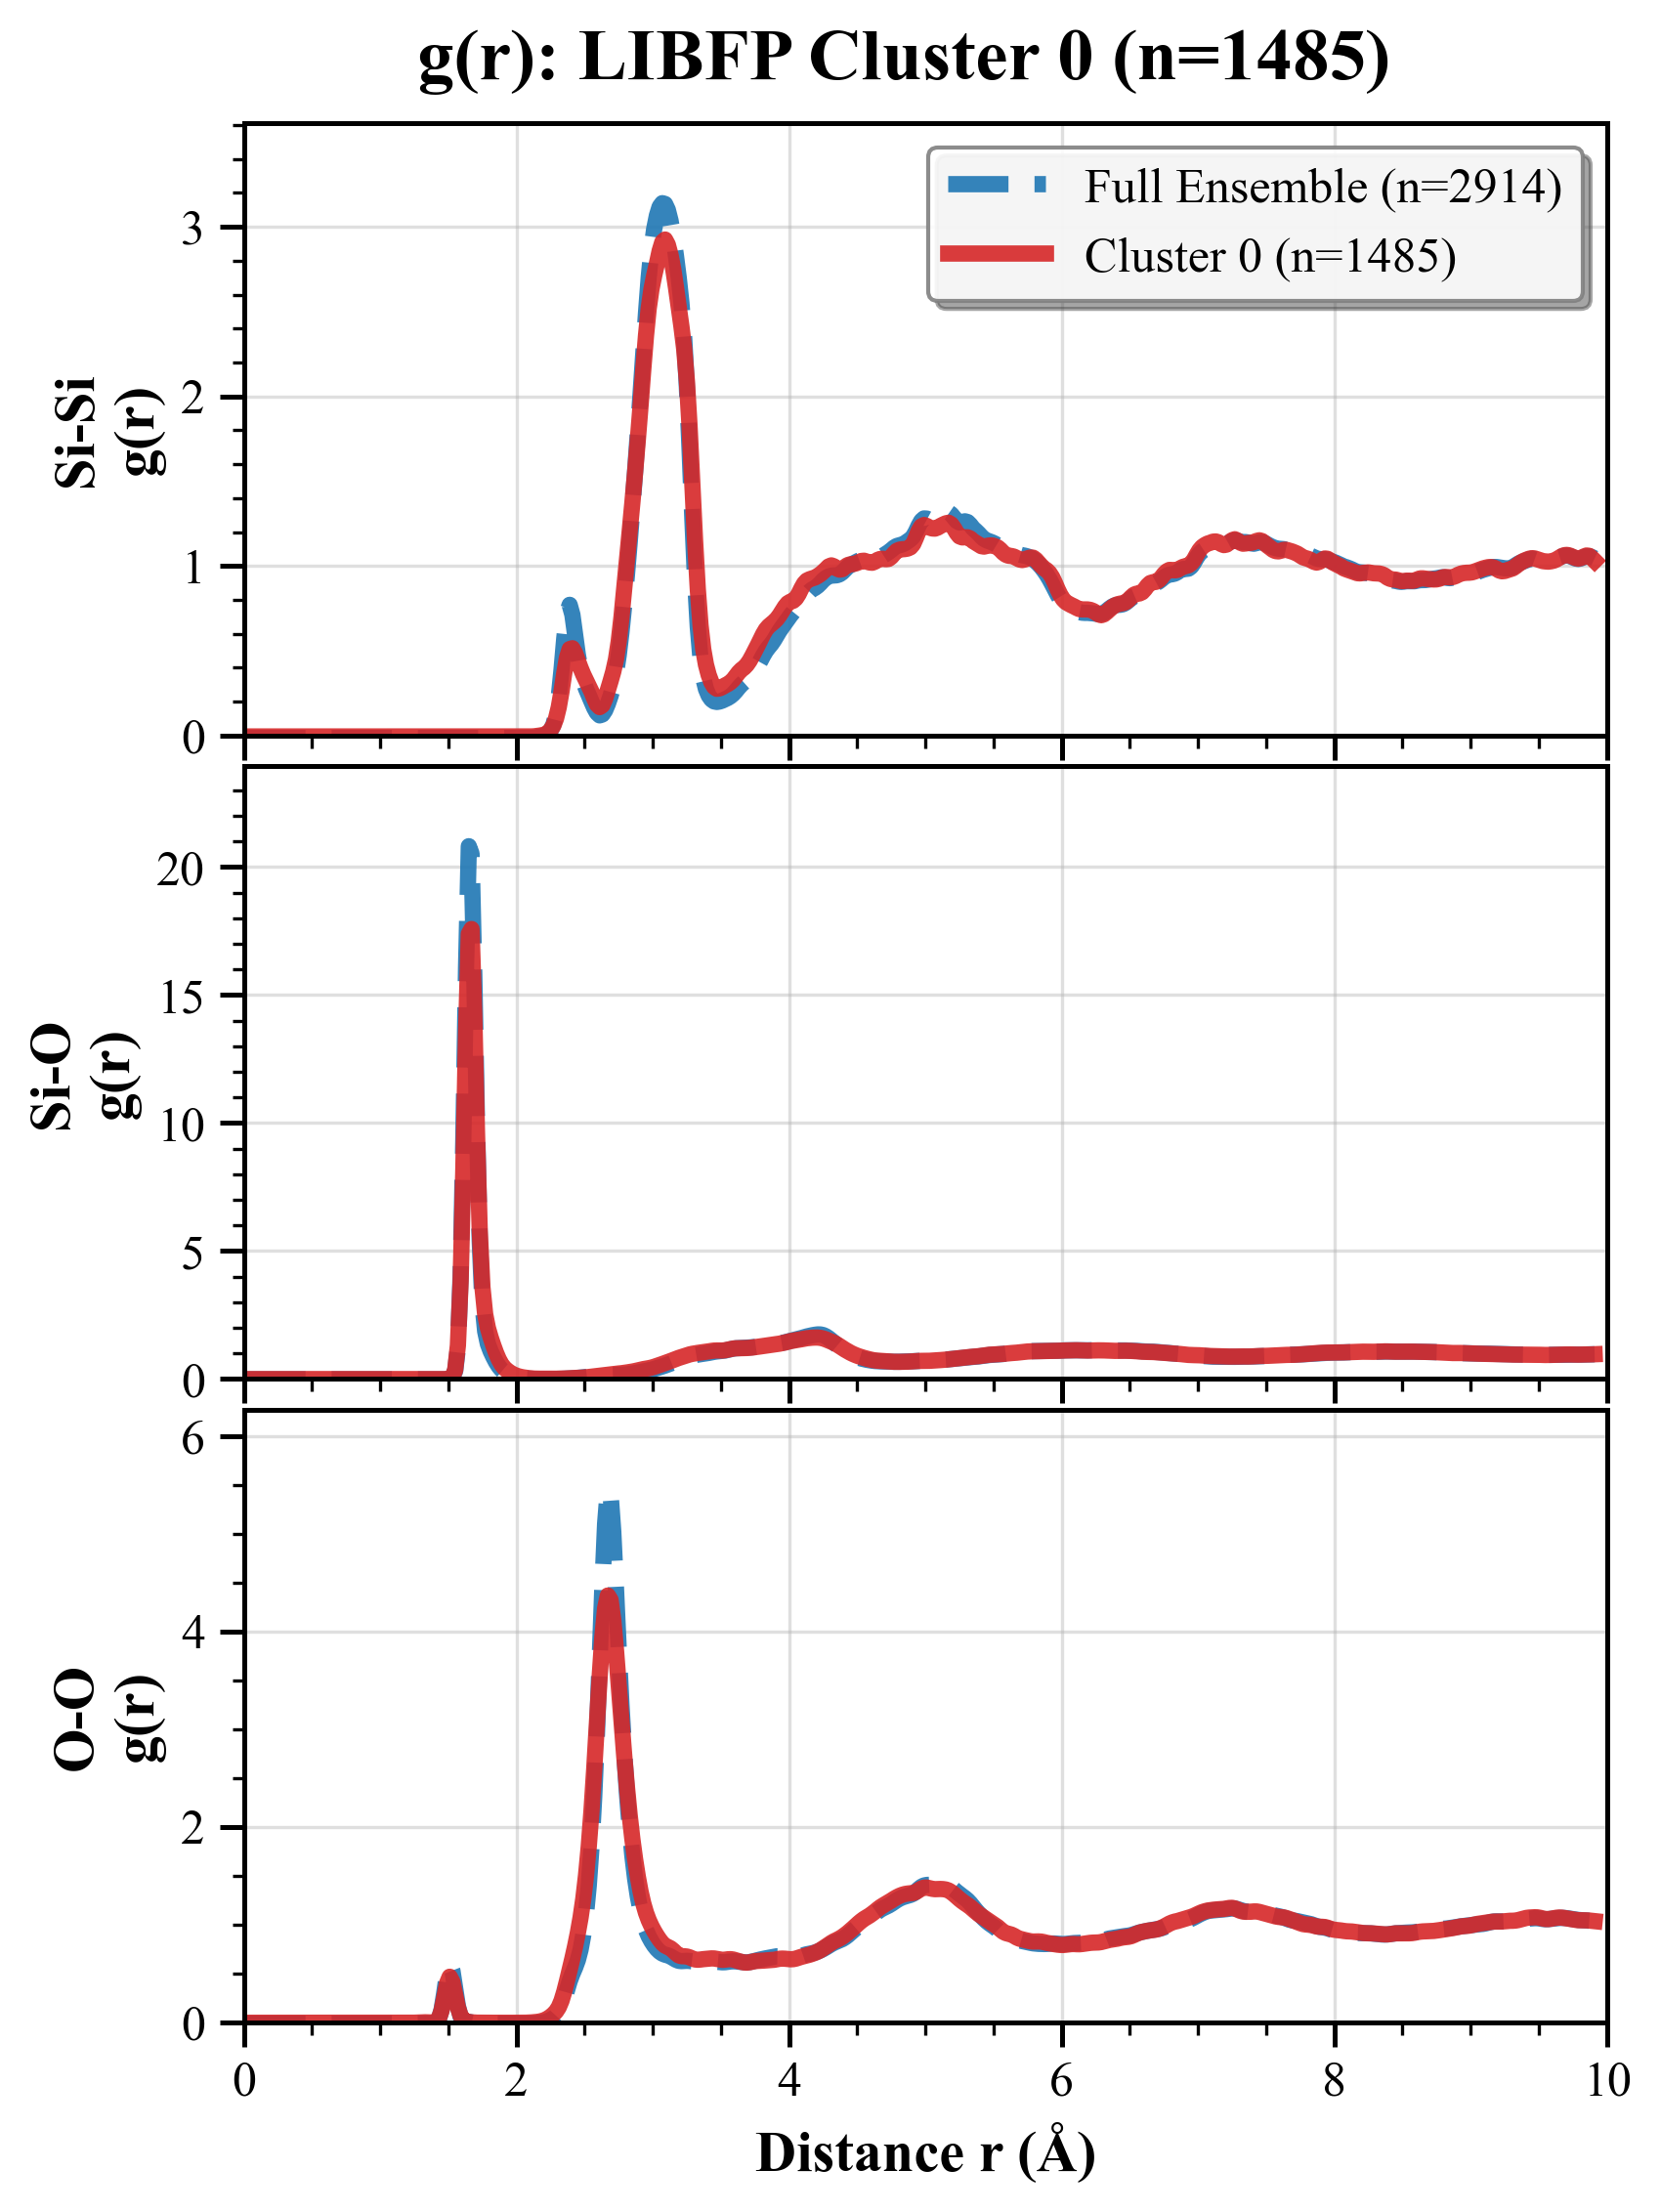

  Processing Cluster 1...


Calculating ensemble partial RDFs: 100%|██████████| 1428/1428 [00:00<00:00, 38879.26it/s]


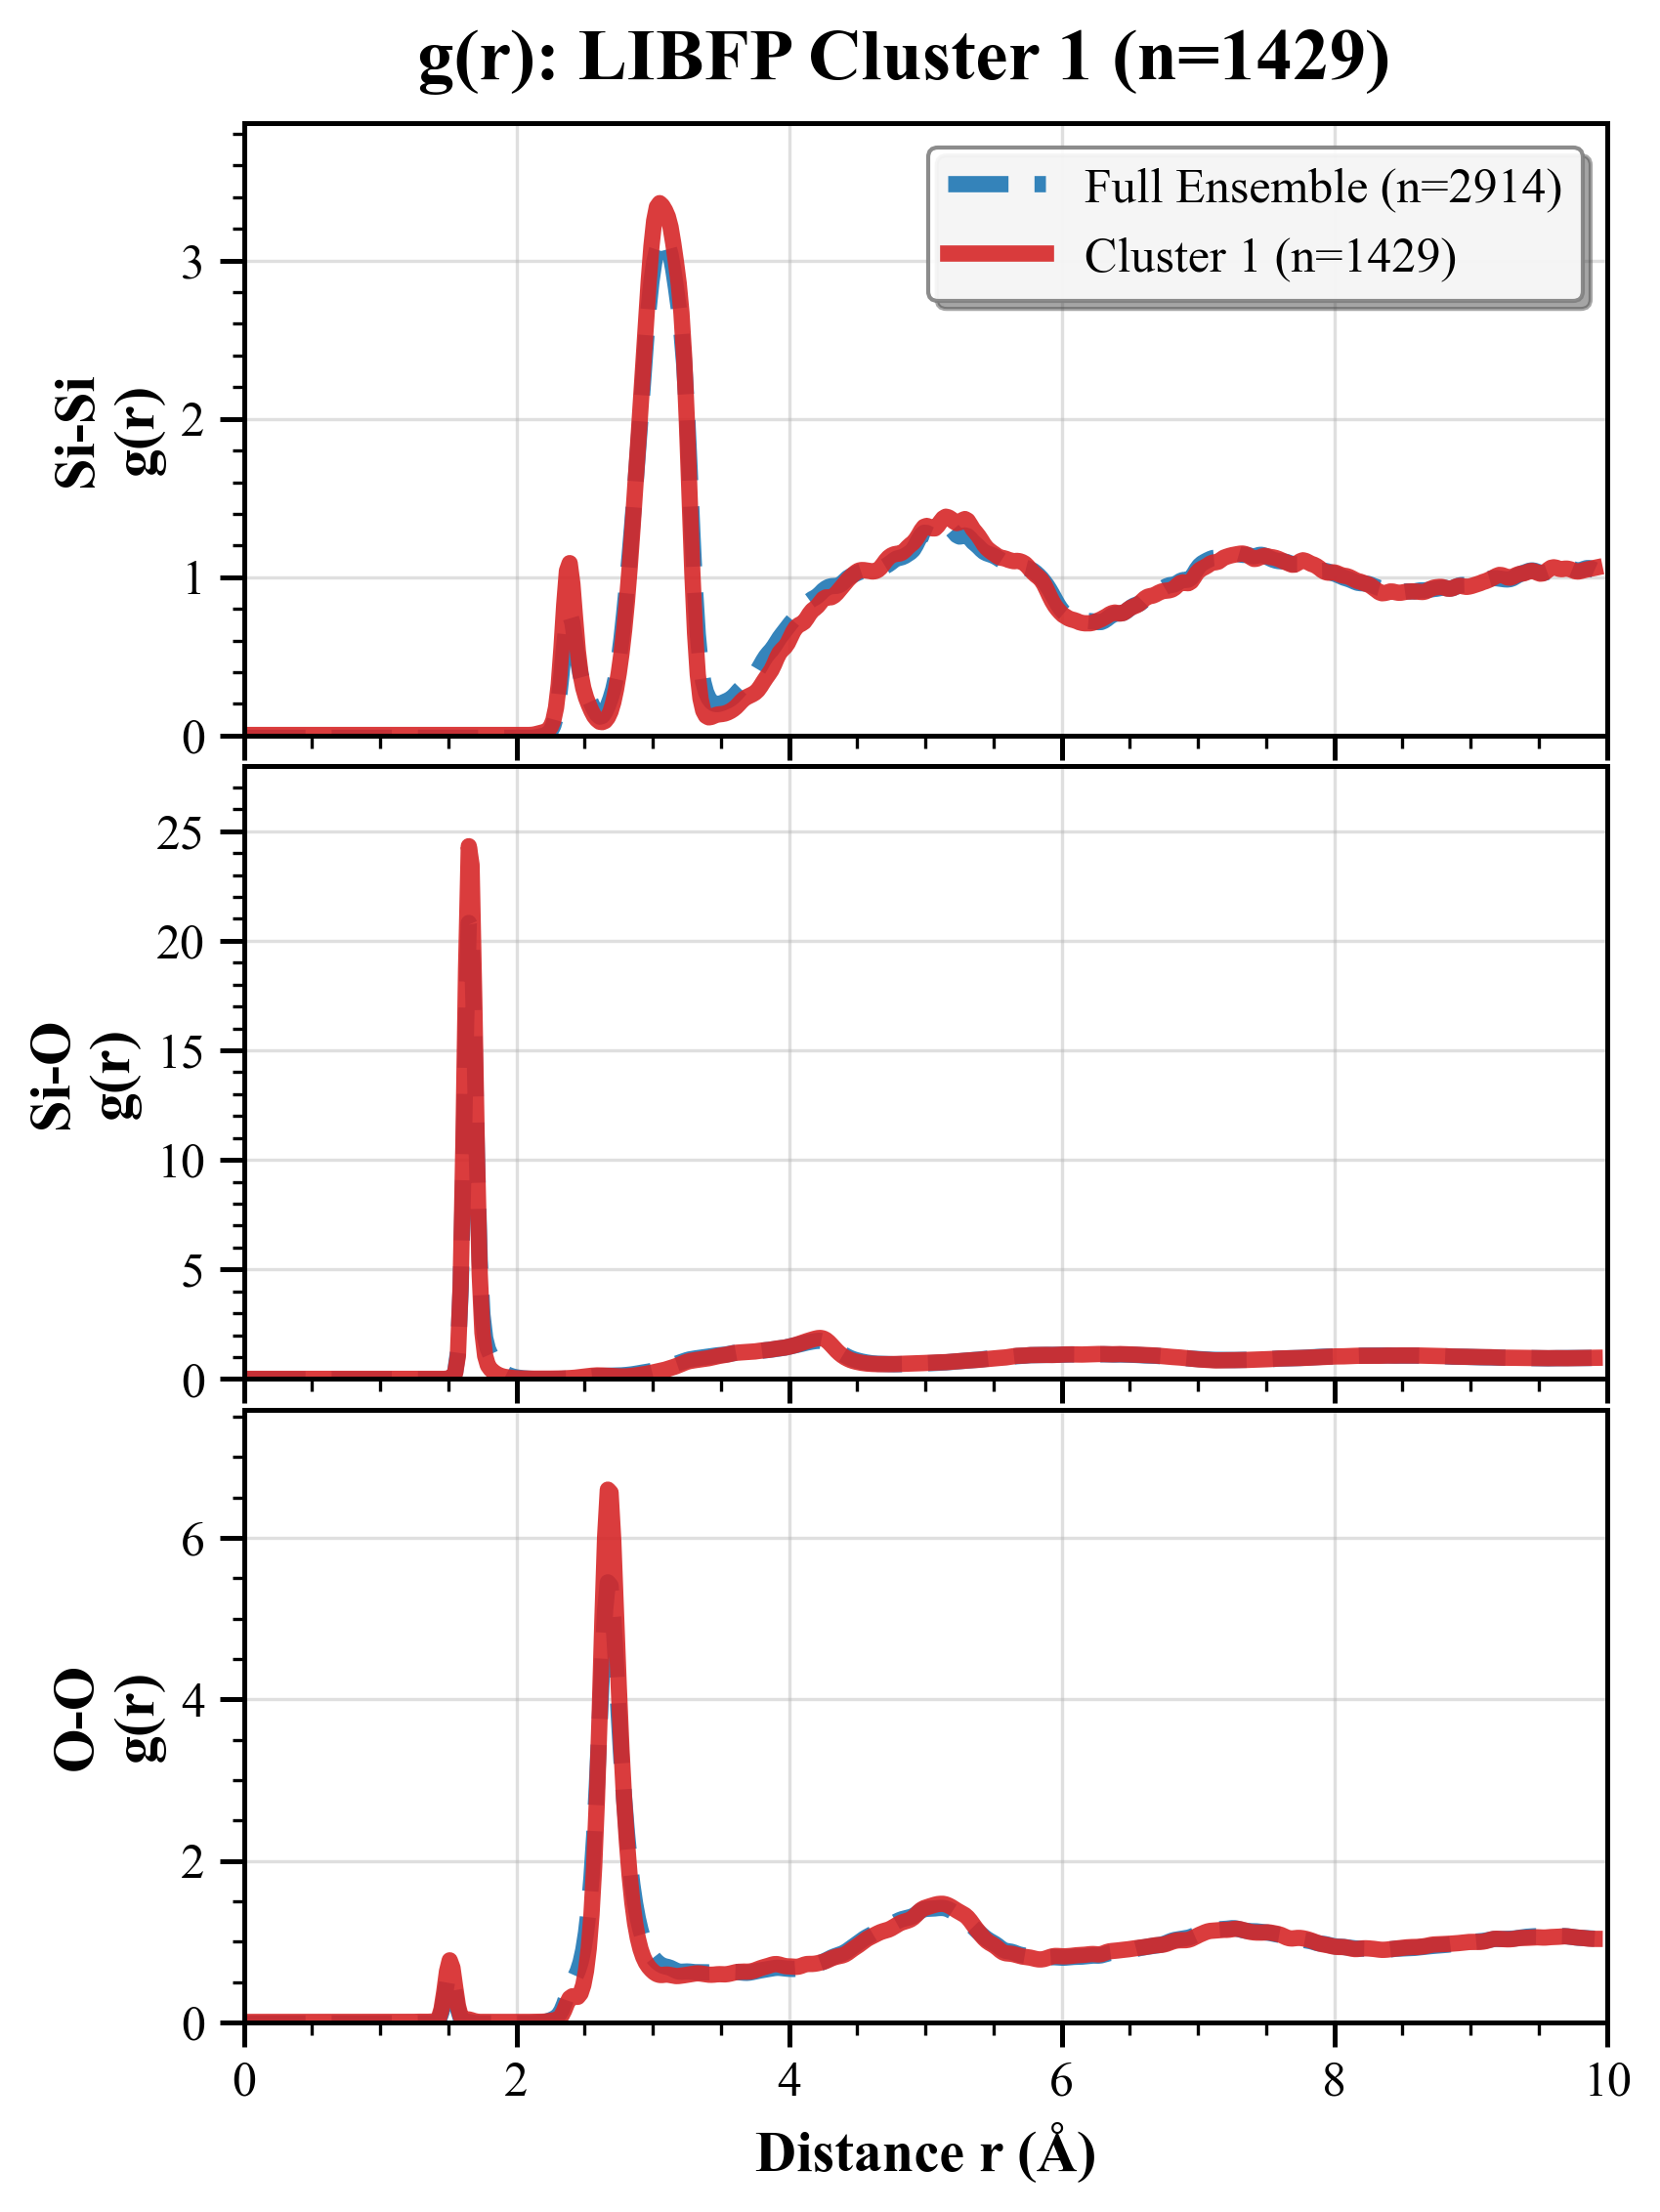


Processing LEVR clusters...
  Processing Cluster 0...


Calculating ensemble partial RDFs: 100%|██████████| 1429/1429 [00:00<00:00, 44314.11it/s]


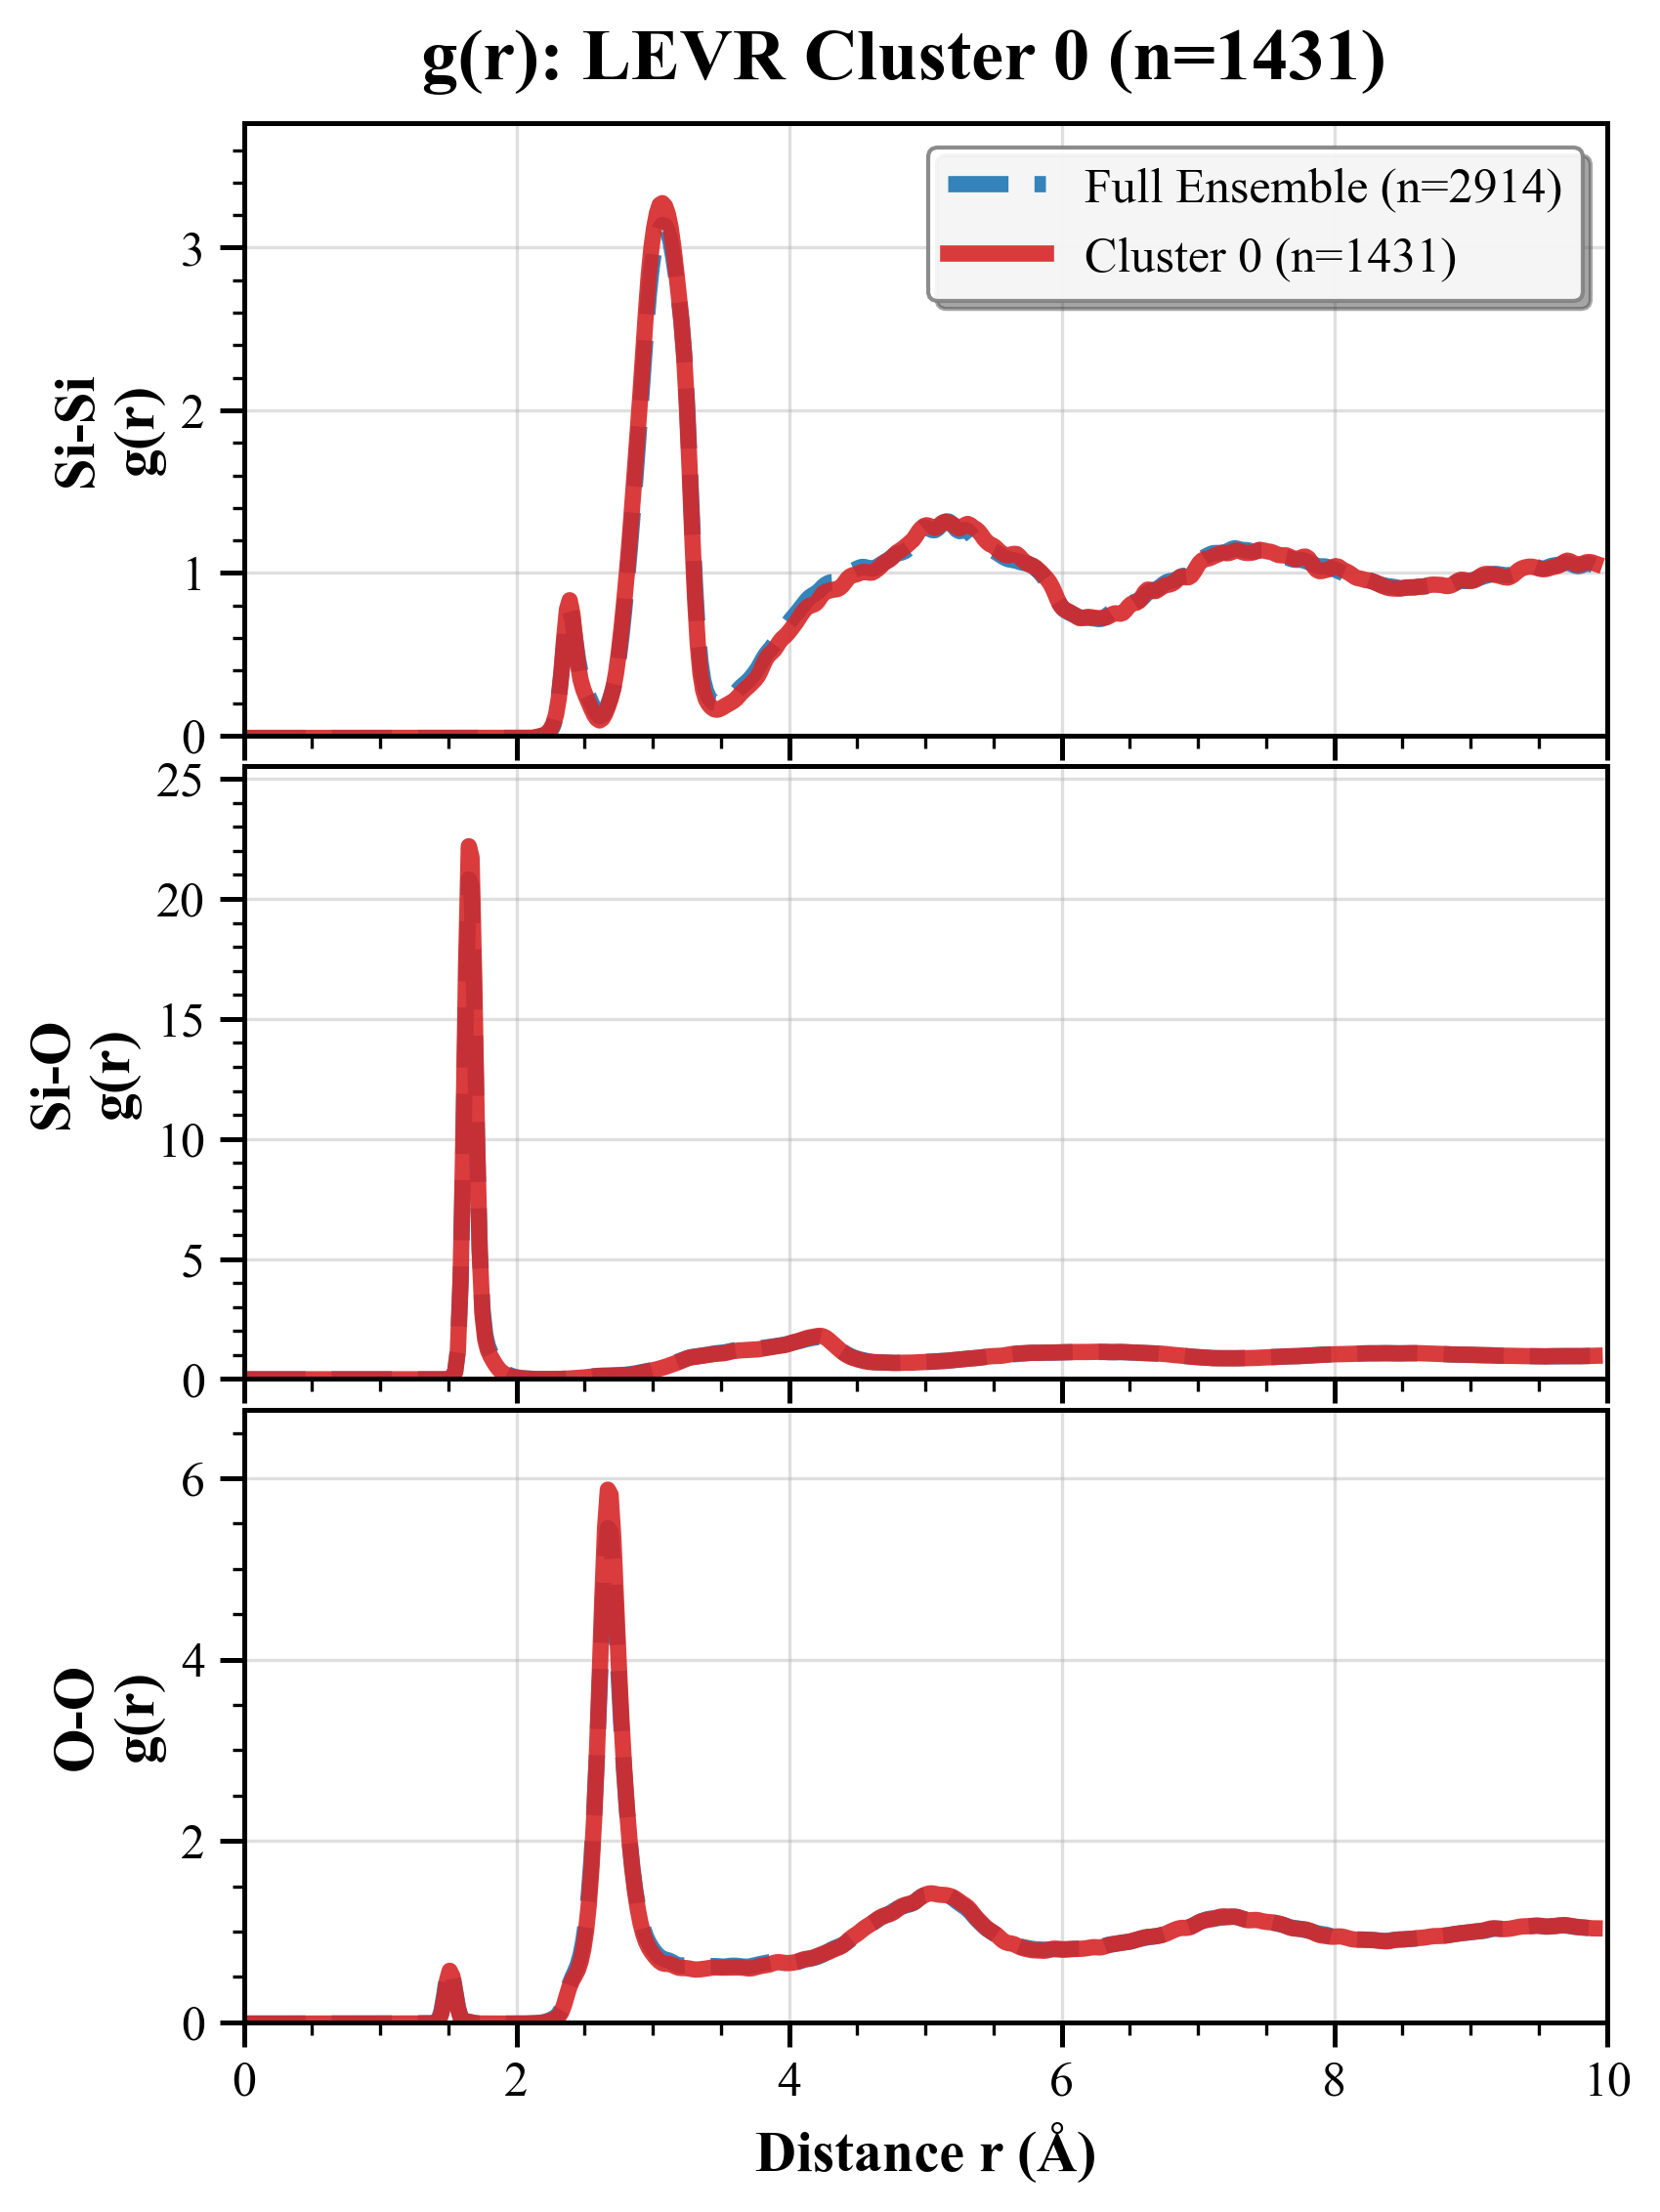

  Processing Cluster 1...


Calculating ensemble partial RDFs: 100%|██████████| 1481/1481 [00:00<00:00, 46063.91it/s]


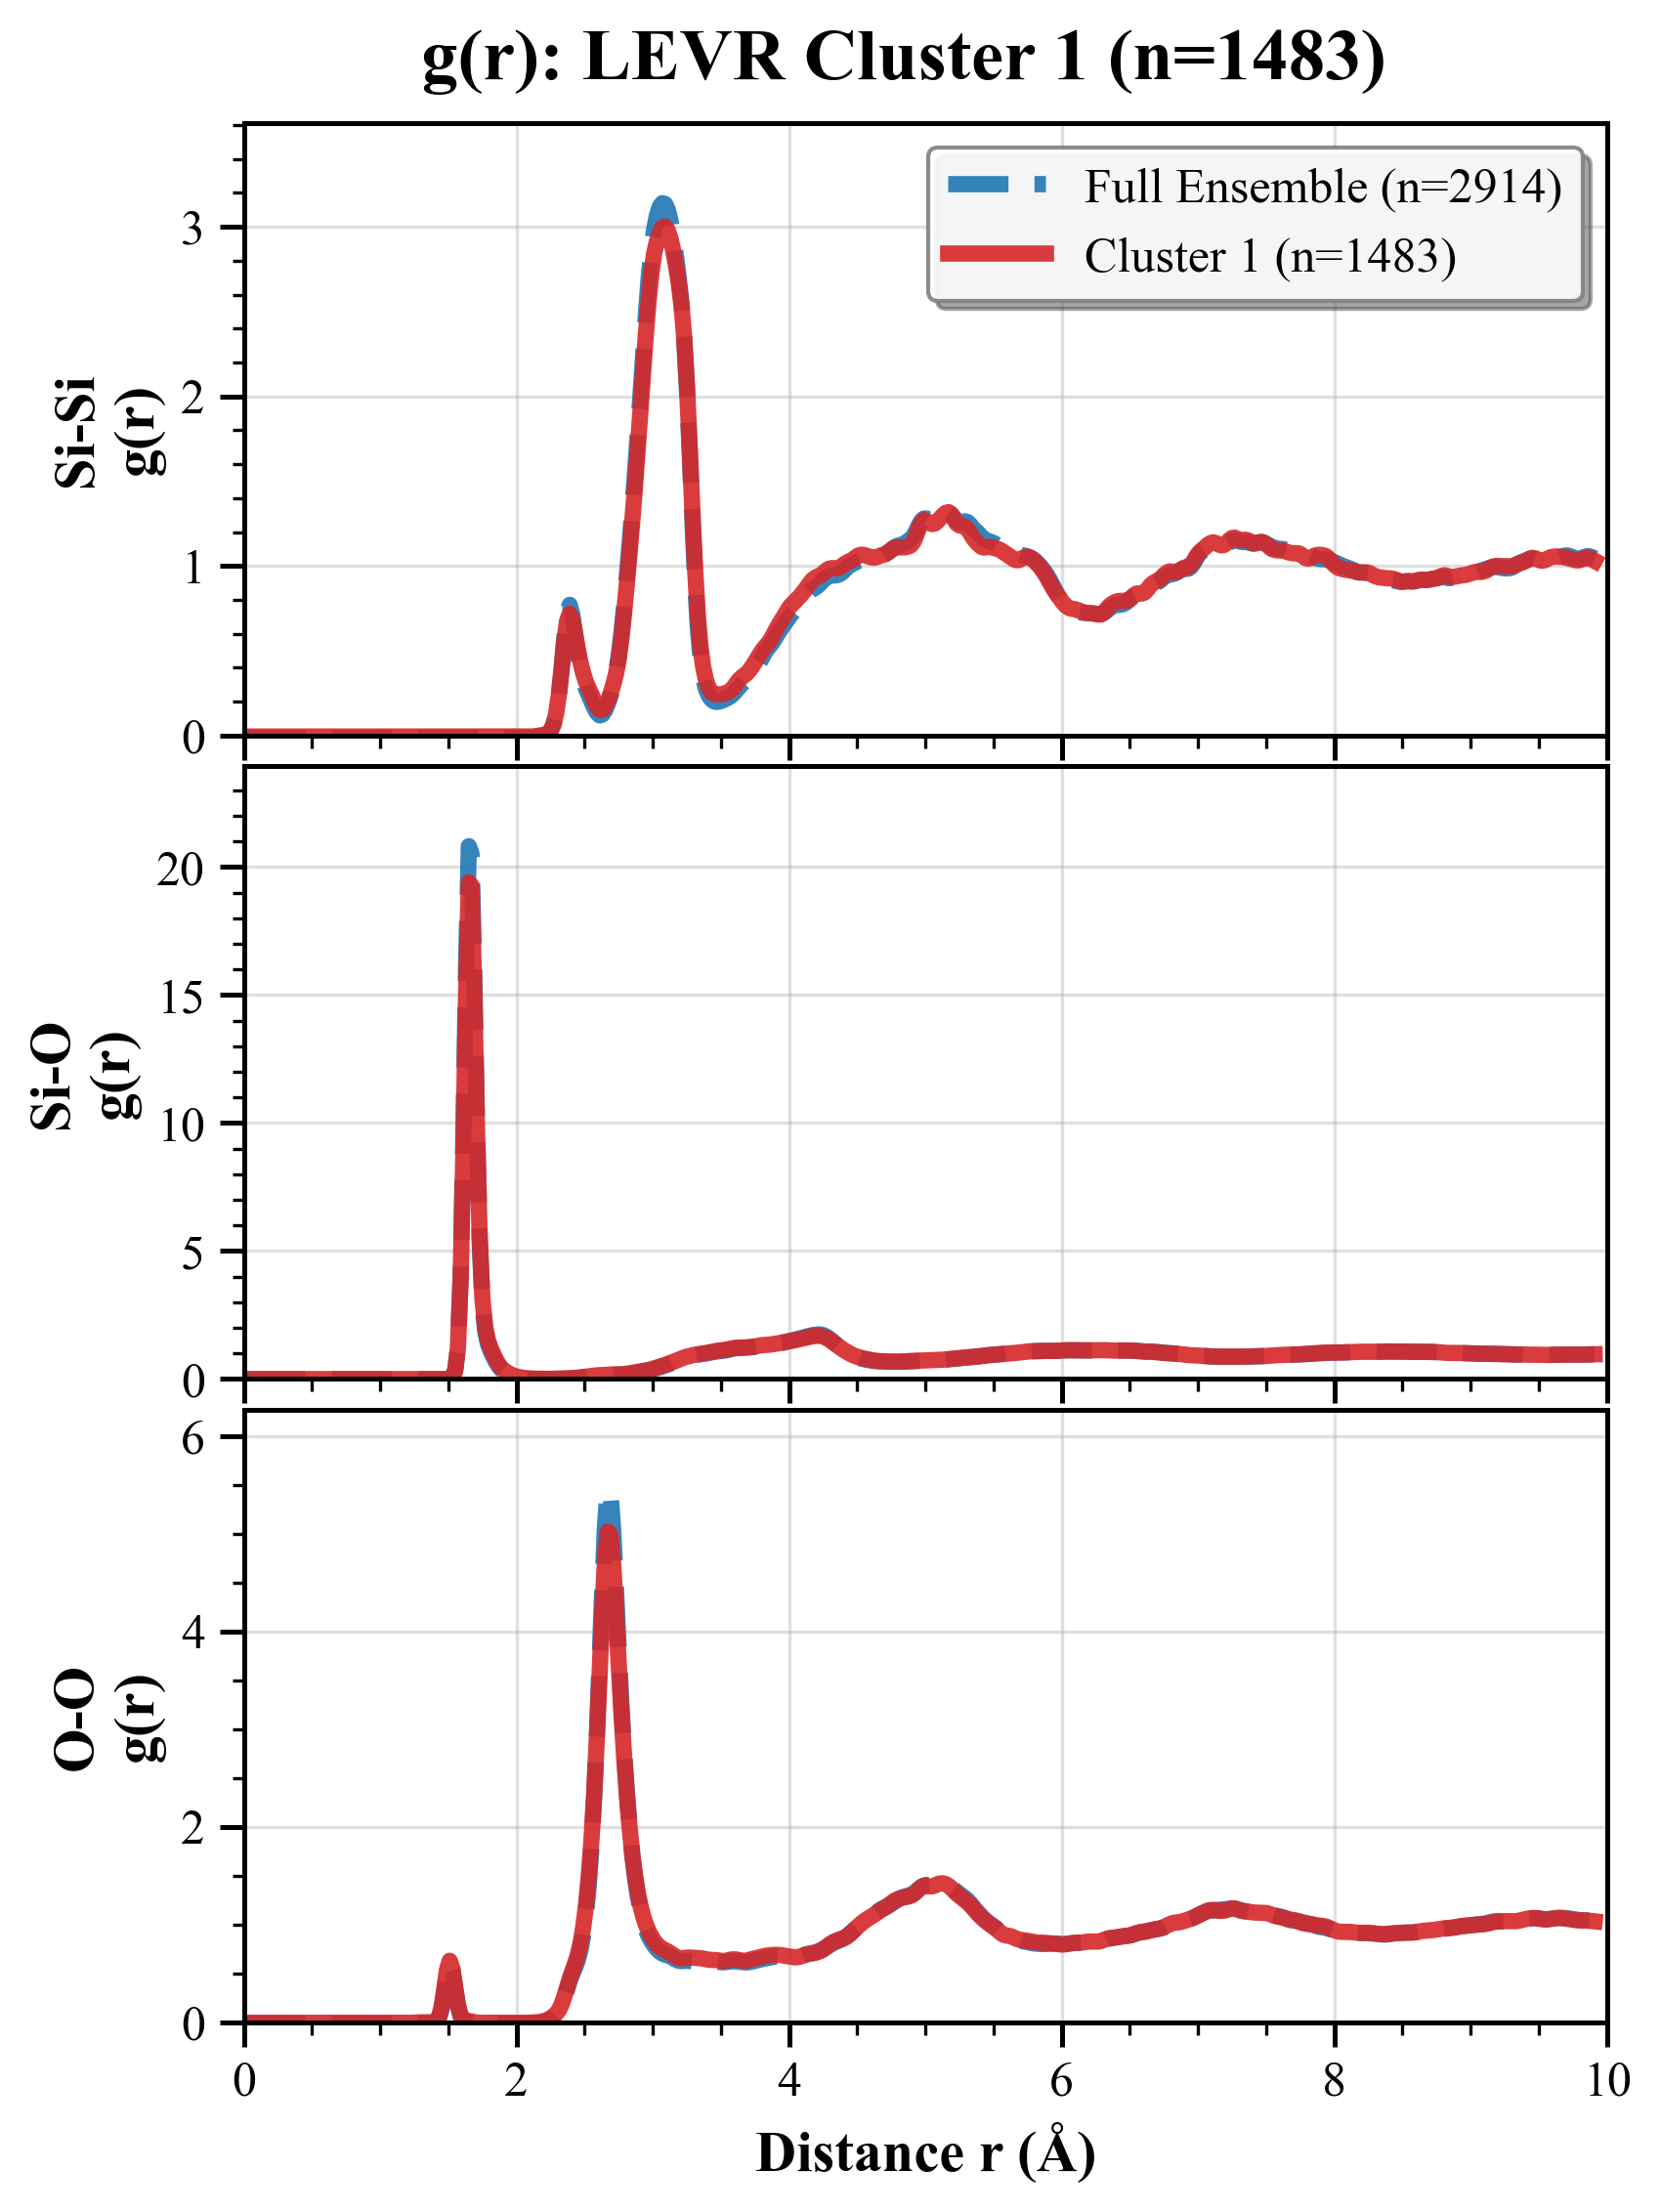


Processing MBTR clusters...
  Processing Cluster 0...


Calculating ensemble partial RDFs: 100%|██████████| 621/621 [00:00<00:00, 44442.86it/s]


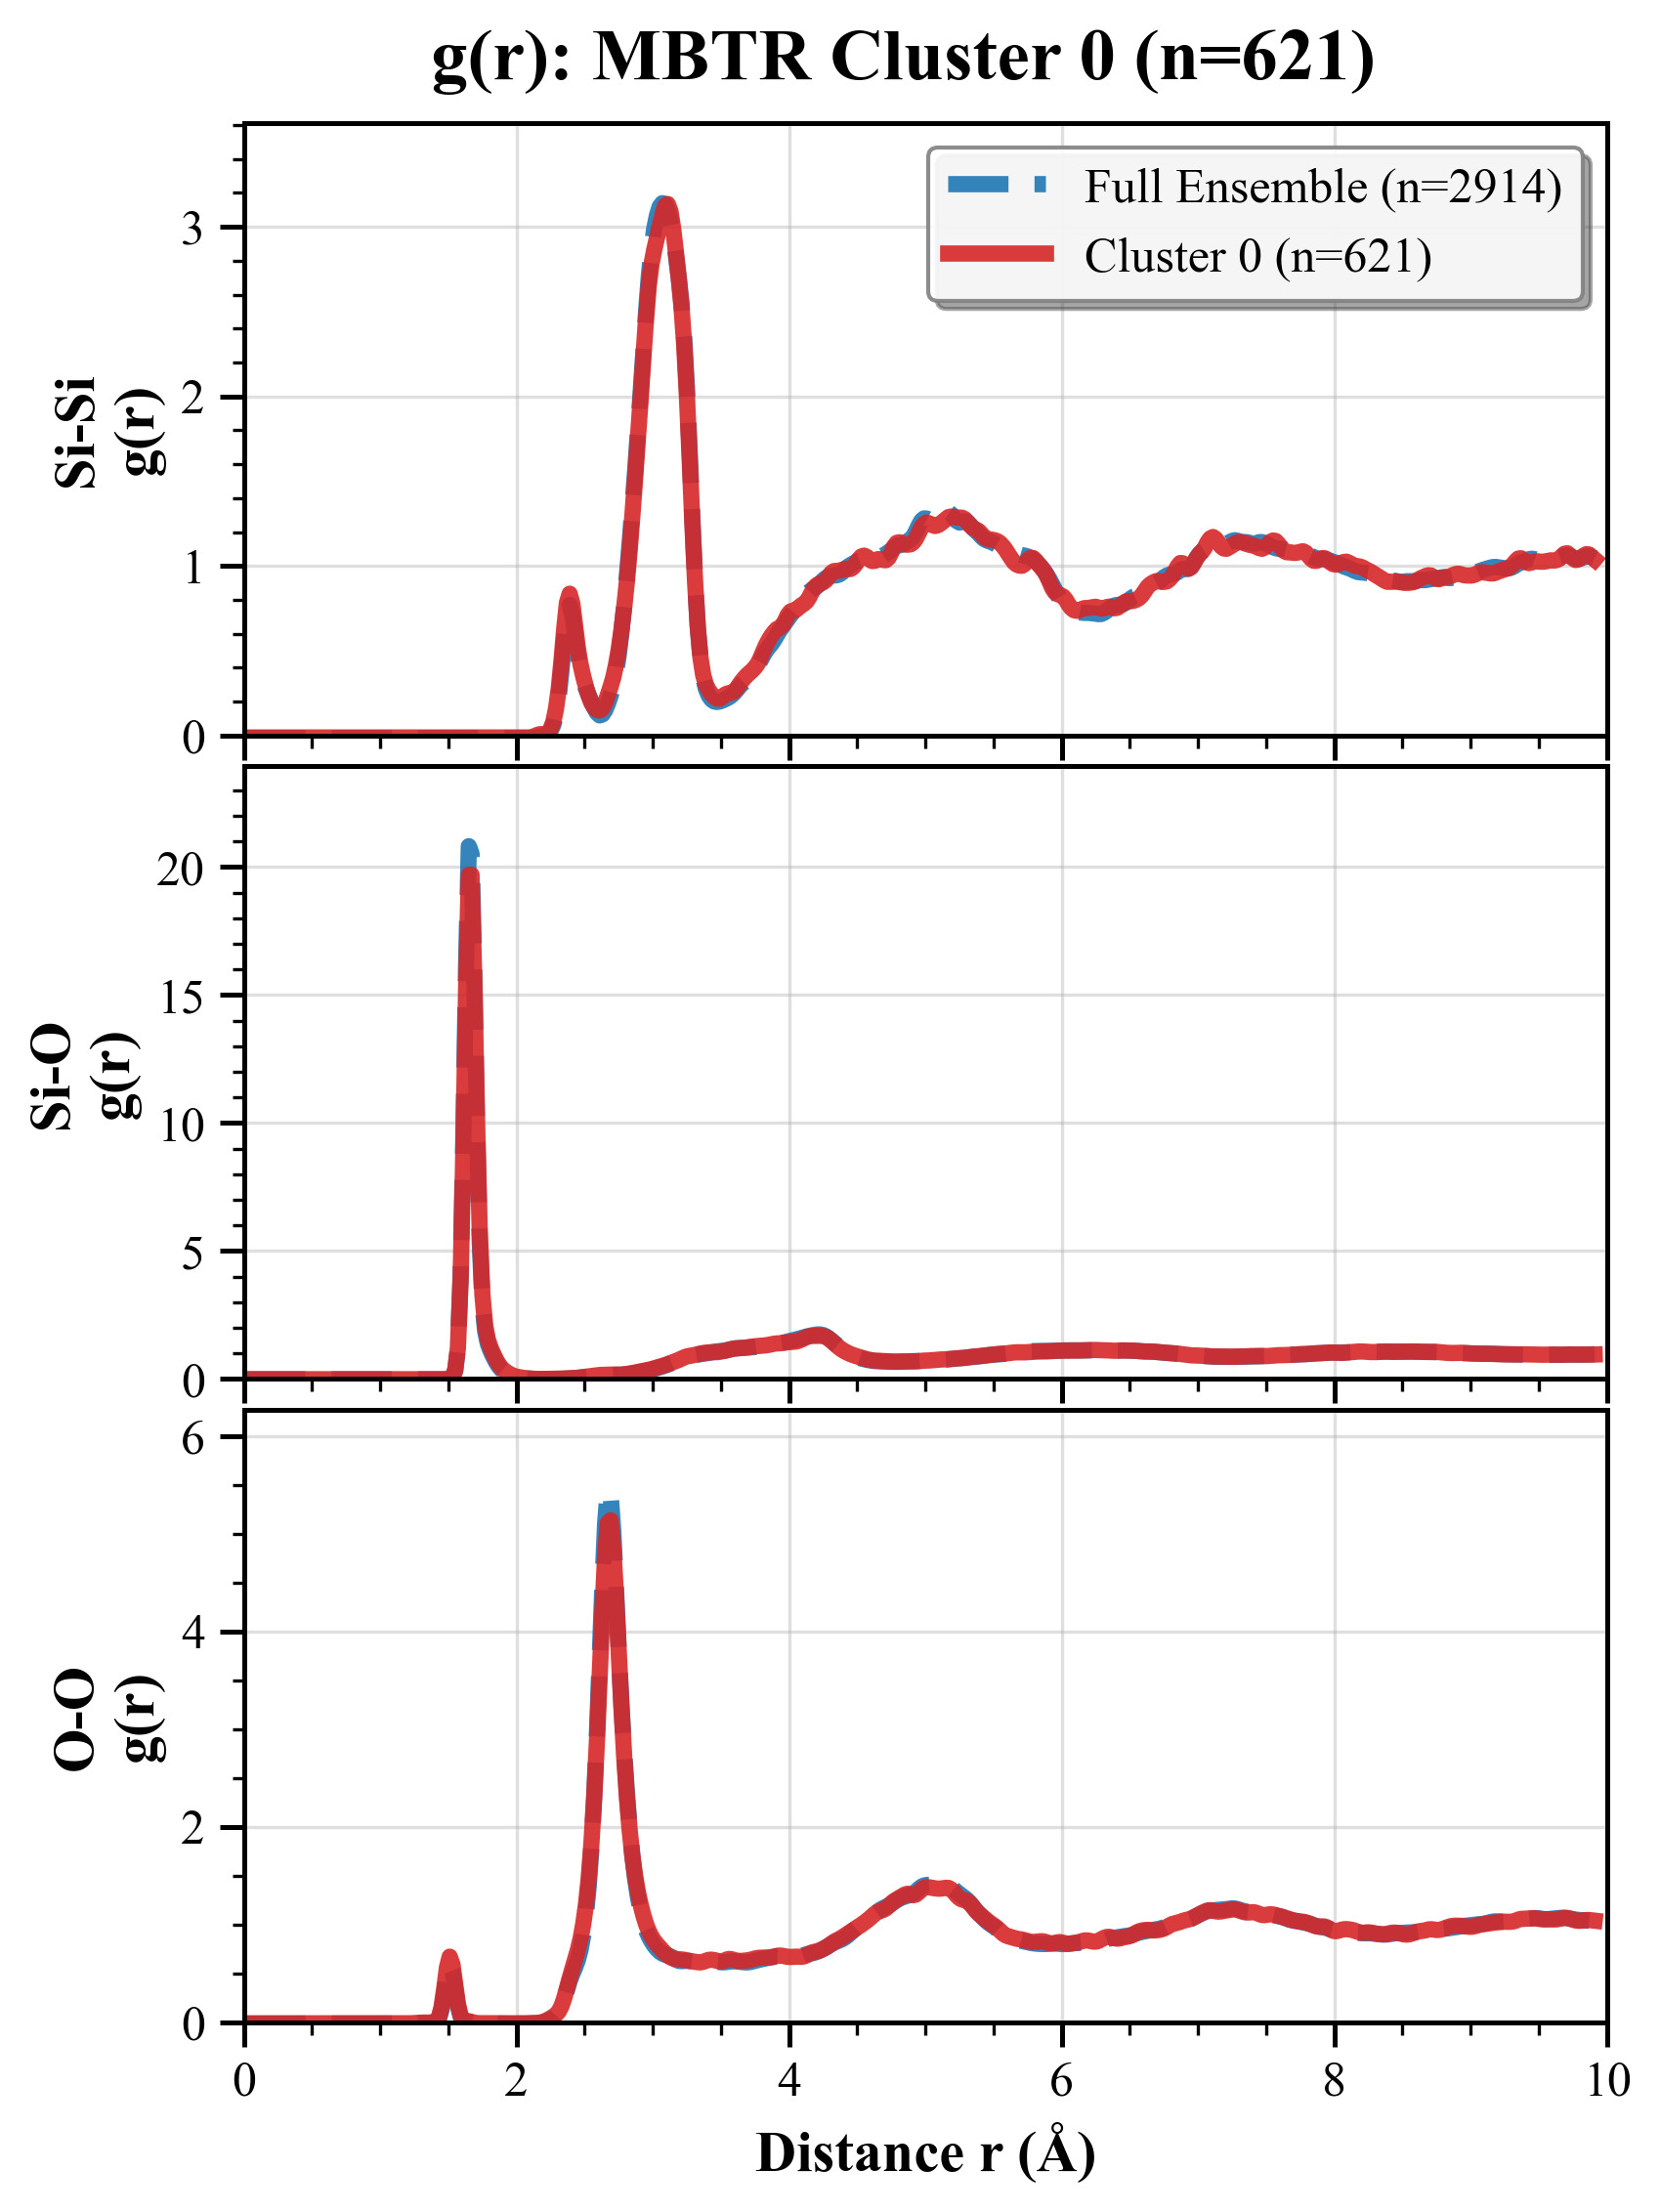

  Processing Cluster 1...


Calculating ensemble partial RDFs: 100%|██████████| 791/791 [00:00<00:00, 44694.19it/s]


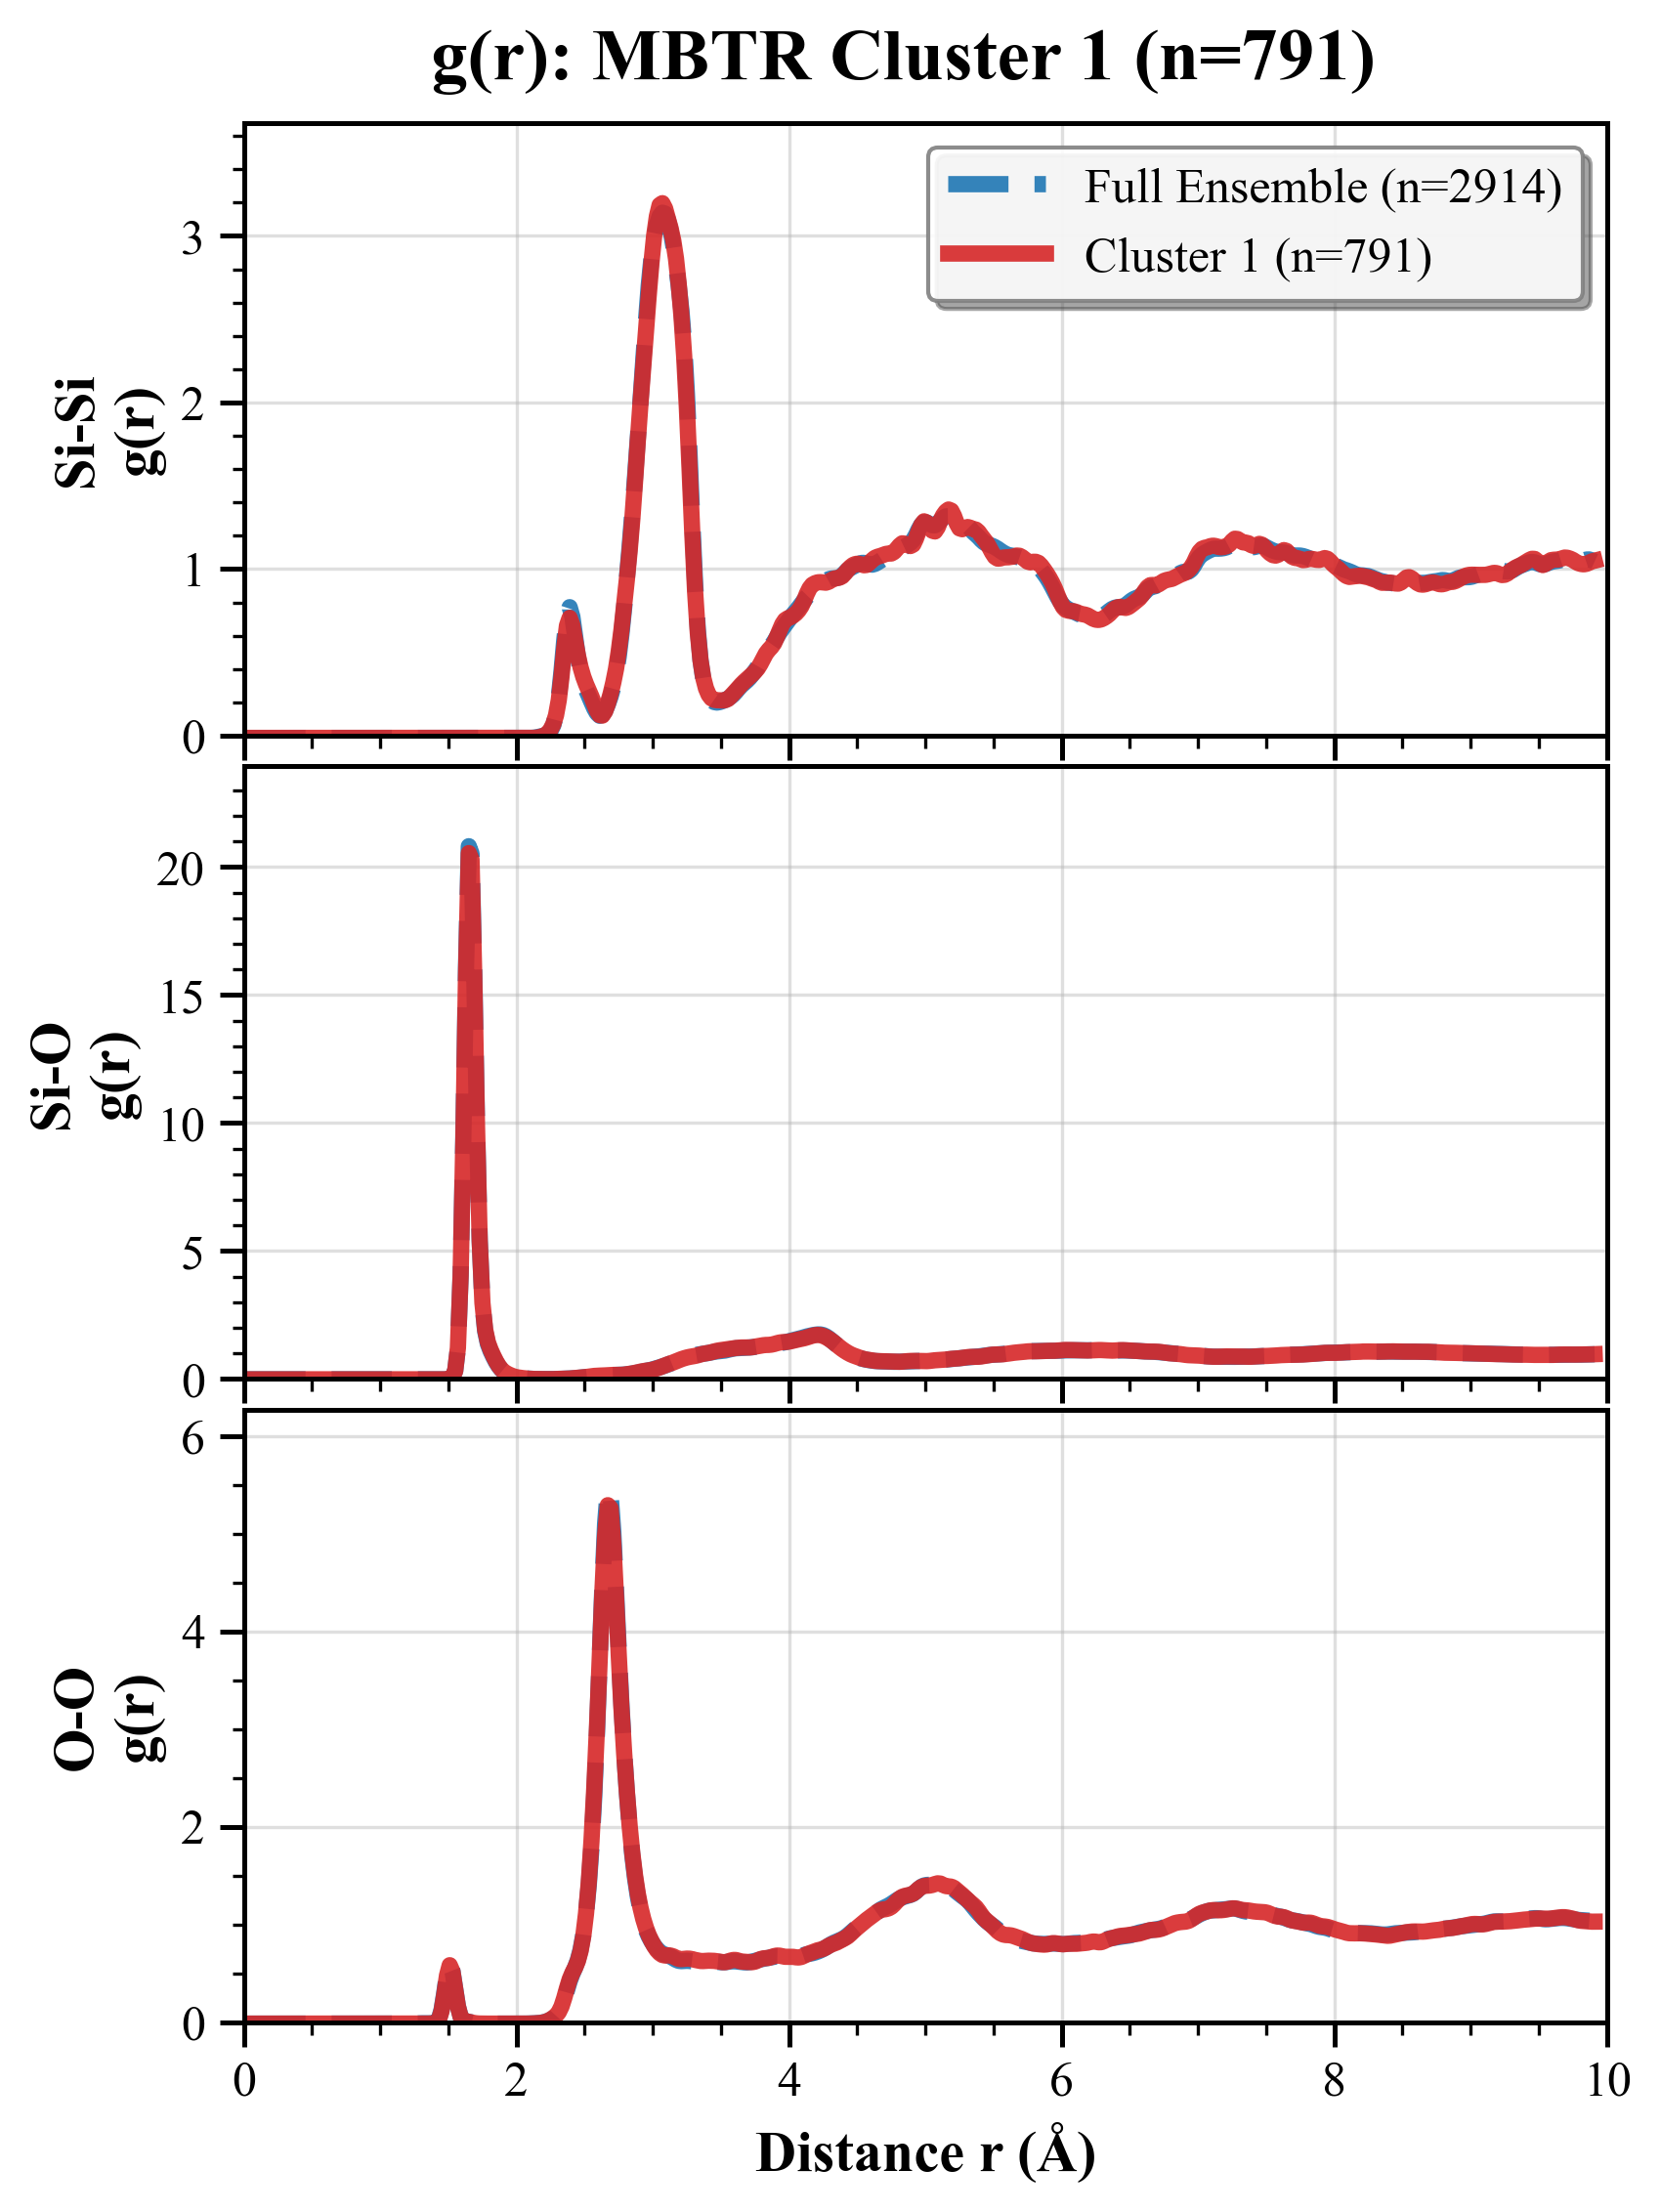

  Processing Cluster 2...


Calculating ensemble partial RDFs: 100%|██████████| 847/847 [00:00<00:00, 46469.88it/s]


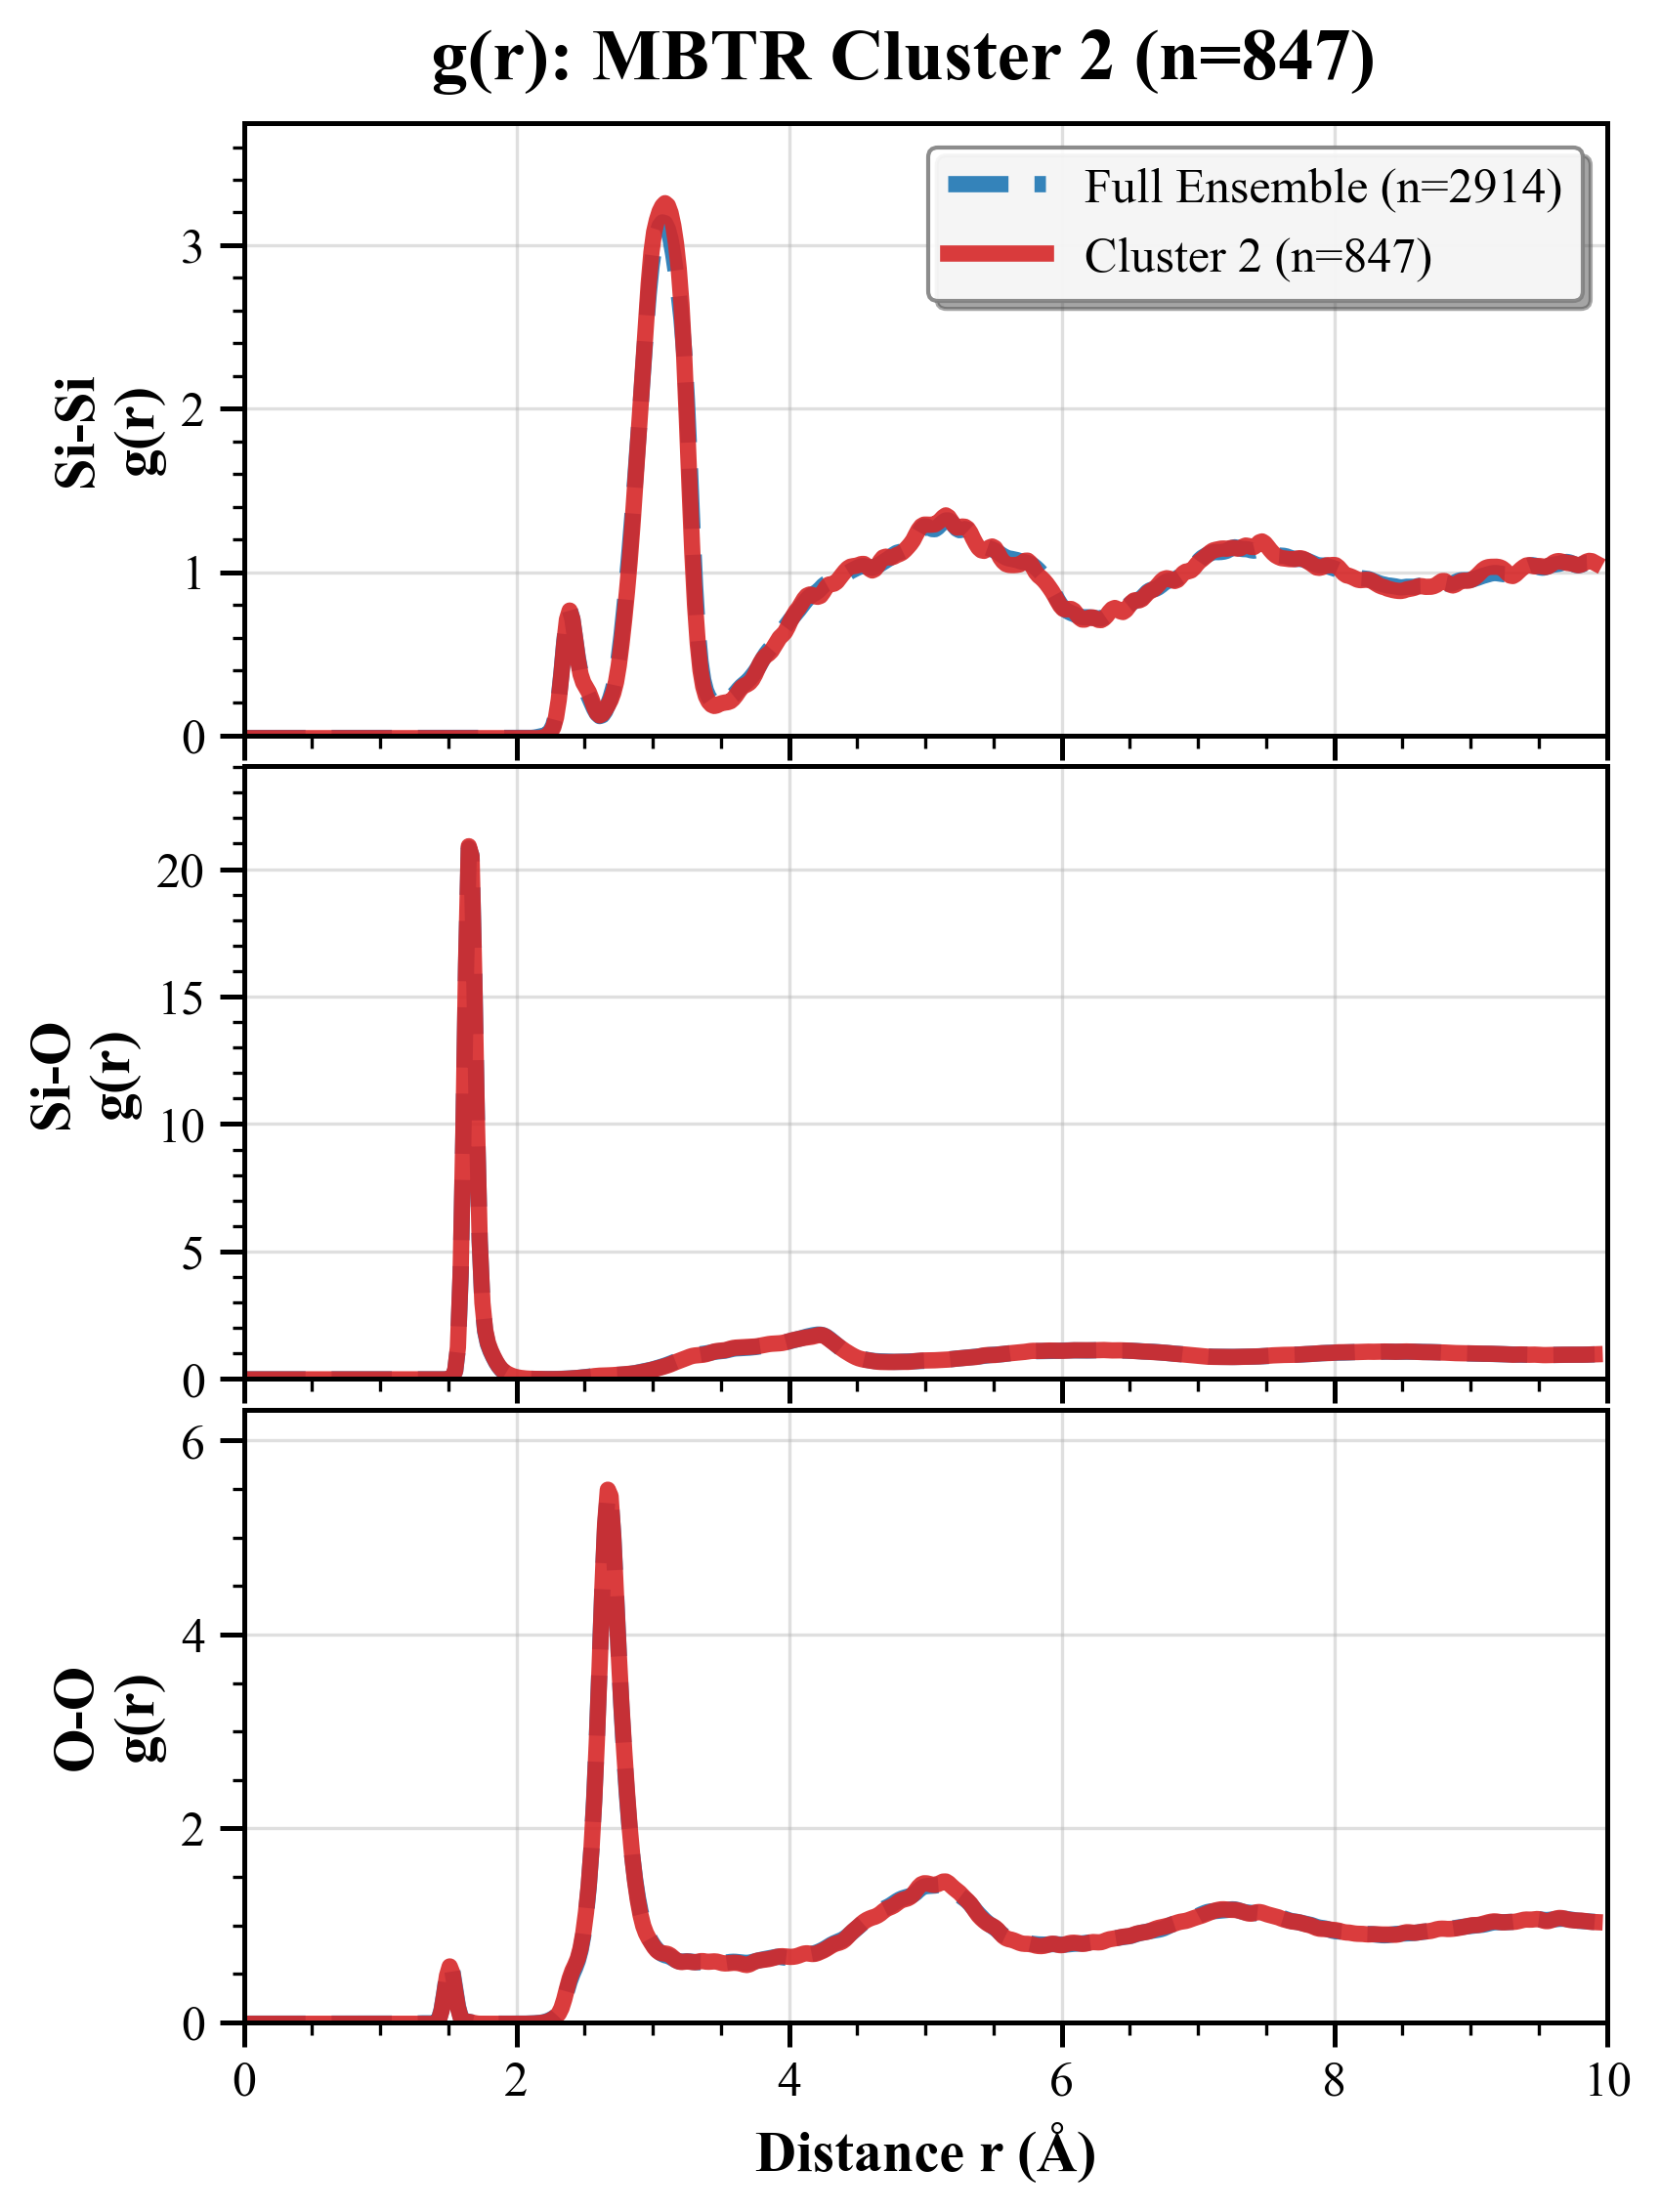

  Processing Cluster 3...


Calculating ensemble partial RDFs: 100%|██████████| 655/655 [00:00<00:00, 42505.01it/s]


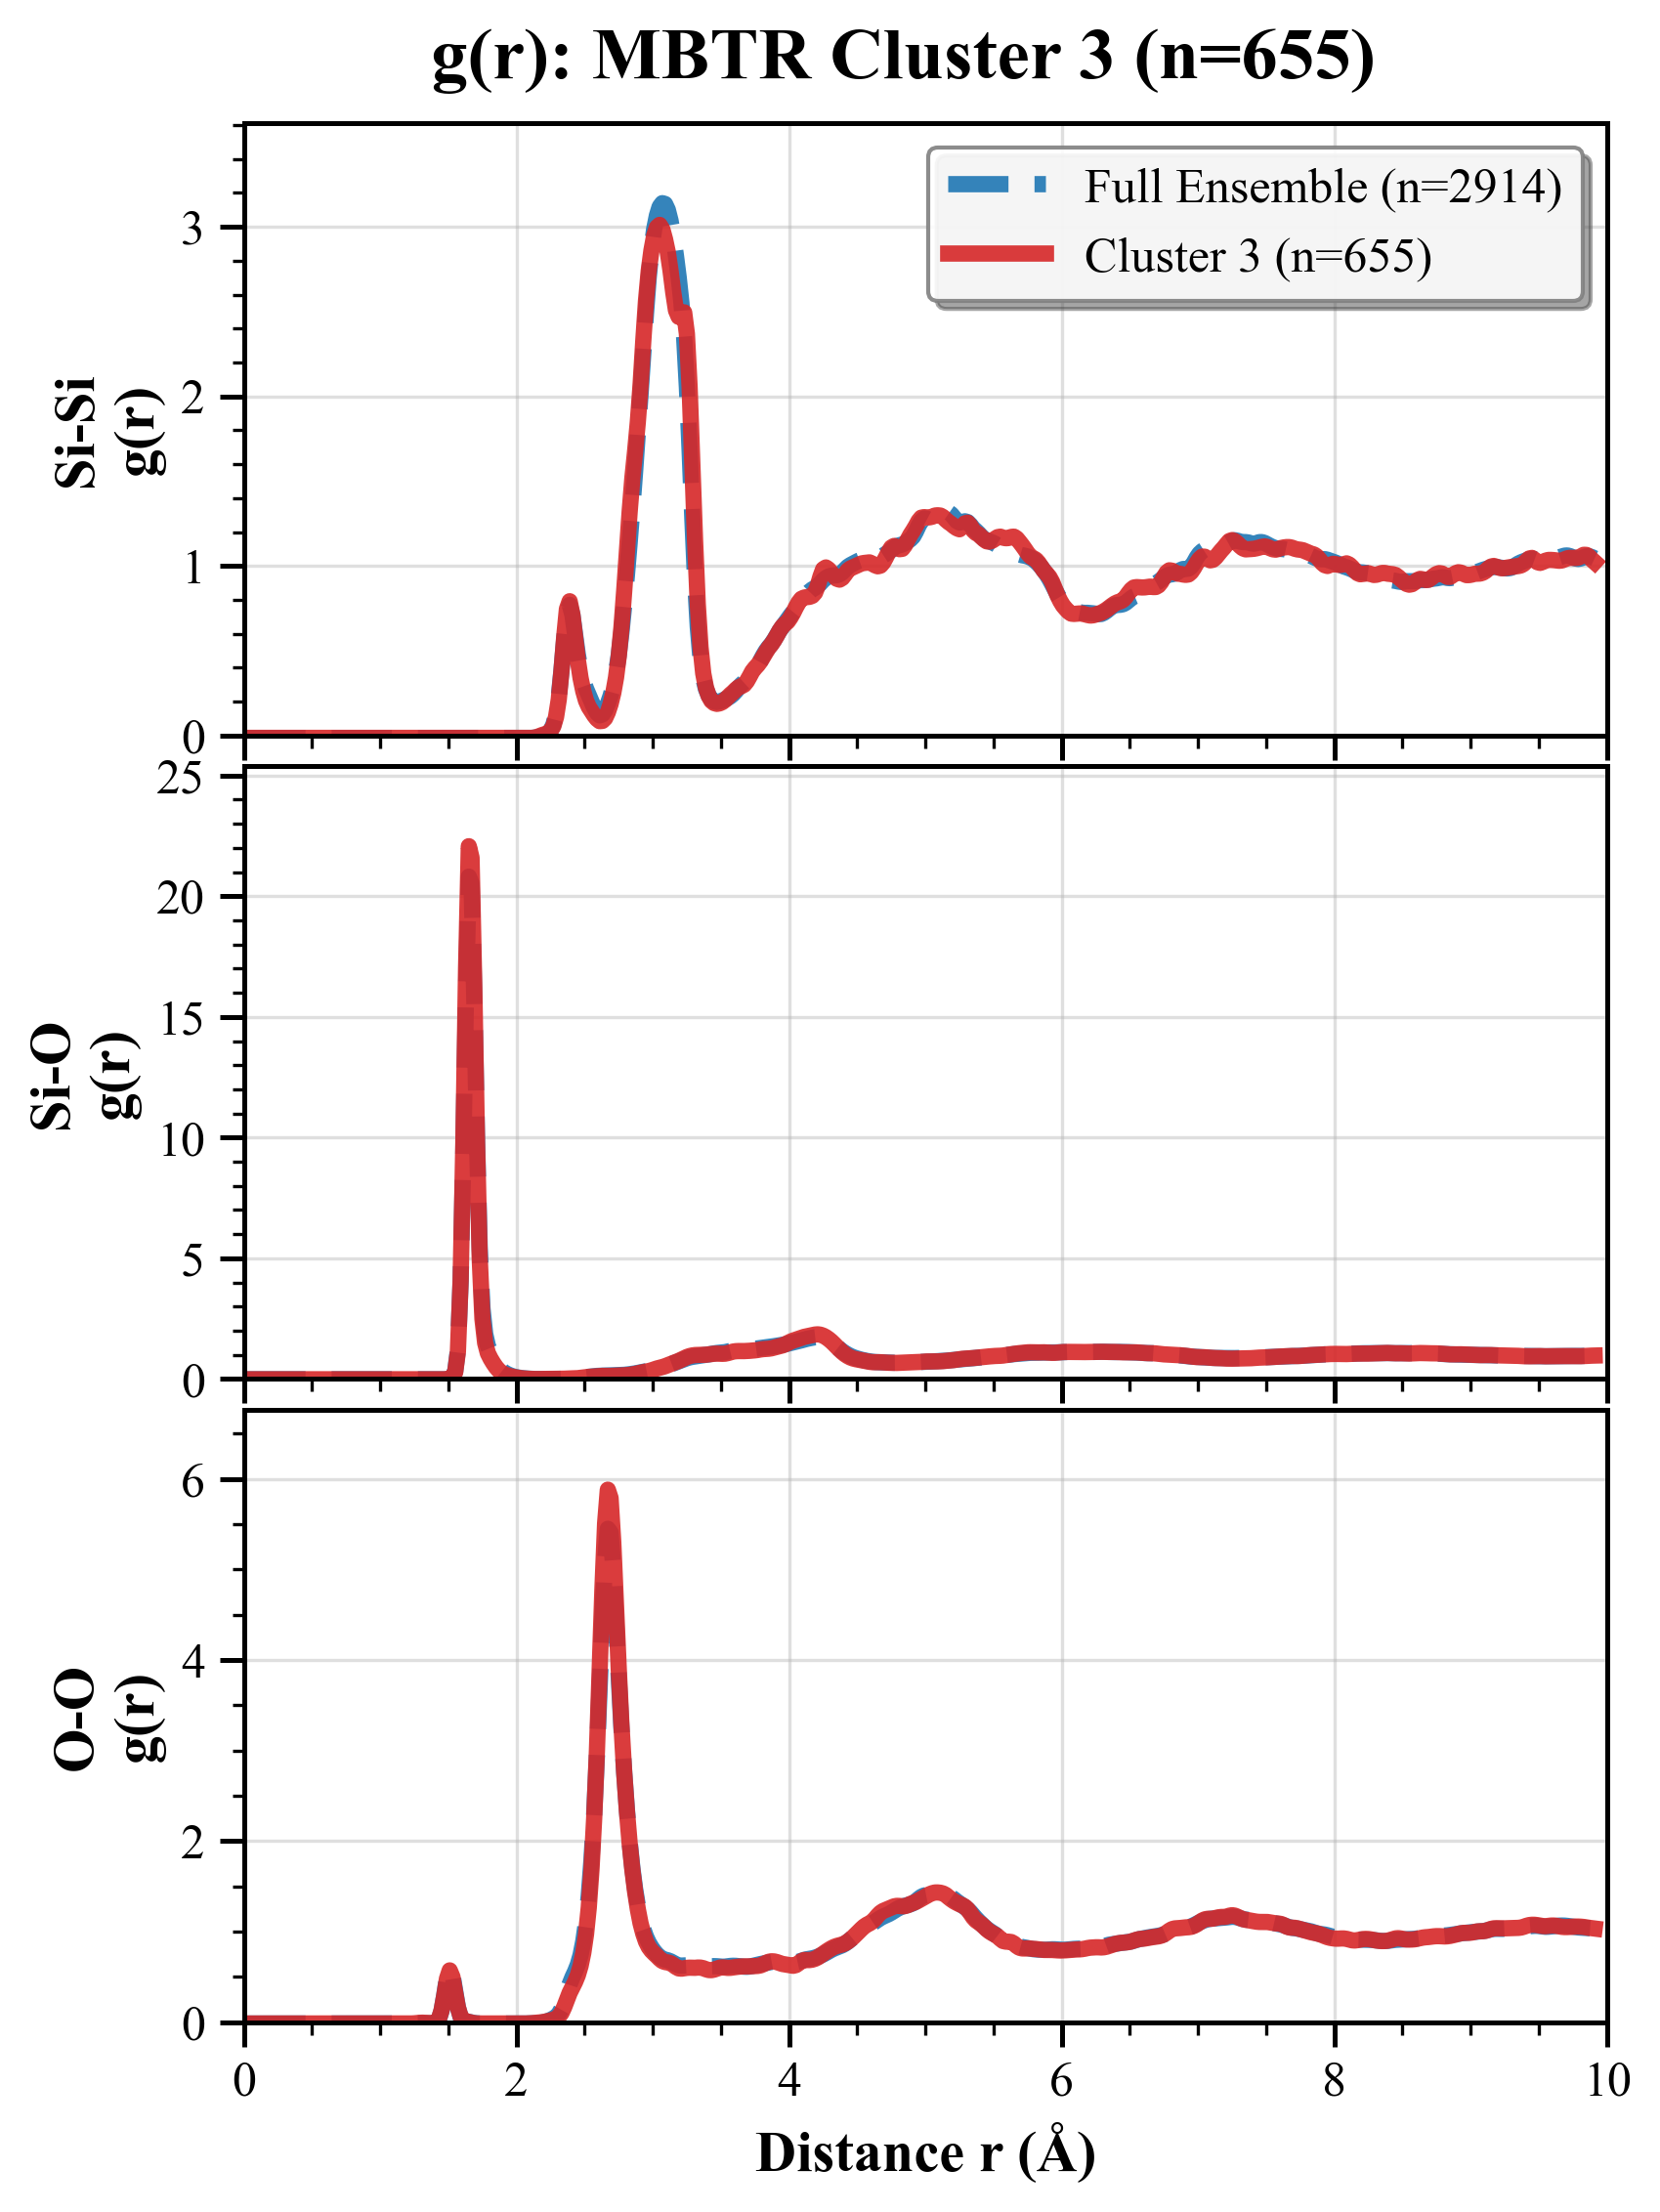


Cluster g(r) analysis complete!


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import src.data_management_v2 as dm
import src.rdf_v2 as rdf

# Set publication-quality plot parameters
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 3,
    'grid.linewidth': 0.8,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'font.family': 'serif',
    'text.usetex': False,      
})

# Load structure IDs and energies
folder_path = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/3k_poscar"
vasp_files = [f for f in os.listdir(folder_path) if f.endswith('.vasp')]
struct_ids = [int(f.replace('.vasp', '')) for f in vasp_files]
struct_ids.sort()

# Load clustering results
results_path = "/Users/raphaelzstone/Documents/CMU/Research/Ensemble-Analysis/data/Stored_info/clustering_results.pkl"
with open(results_path, 'rb') as f:
    results = pickle.load(f)

# Calculate full ensemble RDF for comparison
print("Calculating full ensemble RDFs...")
full_ensemble_rdfs = rdf.calculate_ensemble_partial_rdfs(
    struct_ids, temperature=1800, use_weights=False, smoothed=True
)

# Define colors
color_full = '#1f77b4'    # Blue for full ensemble
color_cluster = '#d62728' # Red for clusters

# Define pairs to plot
pairs_to_plot = [('Si', 'Si'), ('Si', 'O'), ('O', 'O')]
pair_labels = ['Si-Si', 'Si-O', 'O-O']

print("Generating g(r) plots for each cluster...")

# Loop through each distance metric
for metric_name, metric_results in results.items():
    print(f"\nProcessing {metric_name} clusters...")
    
    cluster_energies = metric_results['cluster_energies']
    
    # Loop through each cluster in this metric
    for cluster_name, energy_array in cluster_energies.items():
        print(f"  Processing {cluster_name}...")
        
        # Get structure IDs for this cluster (you'll need to map from energies back to IDs)
        # Since we have energies, we need to find which struct_ids correspond to these energies
        energies_dict = dm.load_energies(struct_ids)
        
        # Find struct_ids that match the energies in this cluster
        cluster_struct_ids = []
        for energy in energy_array:
            # Find struct_id with matching energy (within small tolerance)
            for sid in struct_ids:
                if abs(energies_dict[sid] - energy) < 1e-6:
                    cluster_struct_ids.append(sid)
                    break
        
        if not cluster_struct_ids:
            print(f"    Warning: No structures found for {cluster_name}")
            continue
            
        # Calculate RDFs for this cluster
        cluster_rdfs = rdf.calculate_ensemble_partial_rdfs(
            cluster_struct_ids, temperature=1800, use_weights=False, smoothed=True
        )
        
        # Create the plot
        fig, axes = plt.subplots(3, 1, figsize=(6, 8), dpi=300, 
                                gridspec_kw={'hspace': 0.05})
        
        for i, (pair, label, ax) in enumerate(zip(pairs_to_plot, pair_labels, axes)):
            subplot_y_values = []
            
            # Plot full ensemble
            if pair in full_ensemble_rdfs:
                r_full, g_full = full_ensemble_rdfs[pair]
                ax.plot(r_full, g_full, '--', linewidth=4, 
                        label=f'Full Ensemble (n={len(struct_ids)})', 
                        color=color_full, alpha=0.9)
                subplot_y_values.extend(g_full)
            
            # Plot cluster ensemble
            if pair in cluster_rdfs:
                r_cluster, g_cluster = cluster_rdfs[pair]
                ax.plot(r_cluster, g_cluster, '-', linewidth=4,
                        label=f'{cluster_name} (n={len(cluster_struct_ids)})', 
                        color=color_cluster, alpha=0.9)
                subplot_y_values.extend(g_cluster)
            
            # Set axis ranges
            ax.set_xlim(0, 10)
            
            if subplot_y_values:
                y_min, y_max = min(subplot_y_values), max(subplot_y_values)
                y_padding = (y_max - y_min) * 0.15 if y_max > y_min else 0.1
                ax.set_ylim(max(0, y_min - y_padding), y_max + y_padding)
            
            # Labels
            if i == len(axes) - 1:
                ax.set_xlabel('Distance r (Å)', fontweight='bold')
            else:
                ax.set_xticklabels([])
            
            ax.set_ylabel(f'{label}\ng(r)', fontweight='bold', ha='center')
            
            # Legend only on top plot
            if i == 0:
                ax.legend(frameon=True, fancybox=True, shadow=True, 
                         facecolor='white', edgecolor='gray', framealpha=0.9,
                         loc='upper right')
            
            # Grid and ticks
            ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
            ax.set_axisbelow(True)
            ax.tick_params(which='major', length=6, width=1.2)
            ax.tick_params(which='minor', length=3, width=0.8)
            ax.minorticks_on()
        
        # Title with g(r), clustering method, and number of structures
        fig.suptitle(f'g(r): {metric_name} {cluster_name} (n={len(cluster_struct_ids)})', 
                     fontweight='bold', y=0.96, fontsize=18)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, hspace=0.05)
        plt.show()

print("\nCluster g(r) analysis complete!")

Calculating Si-O coordination numbers for 2914 structures...
  Processed 500/2914 structures...
  Processed 1000/2914 structures...
  Processed 1500/2914 structures...
  Processed 2000/2914 structures...
  Processed 2500/2914 structures...
Successfully calculated coordination for 2914 structures
Si-O coordination range: 3.00 - 5.75
Differential entropy range: -3.684 - 11.012 nats


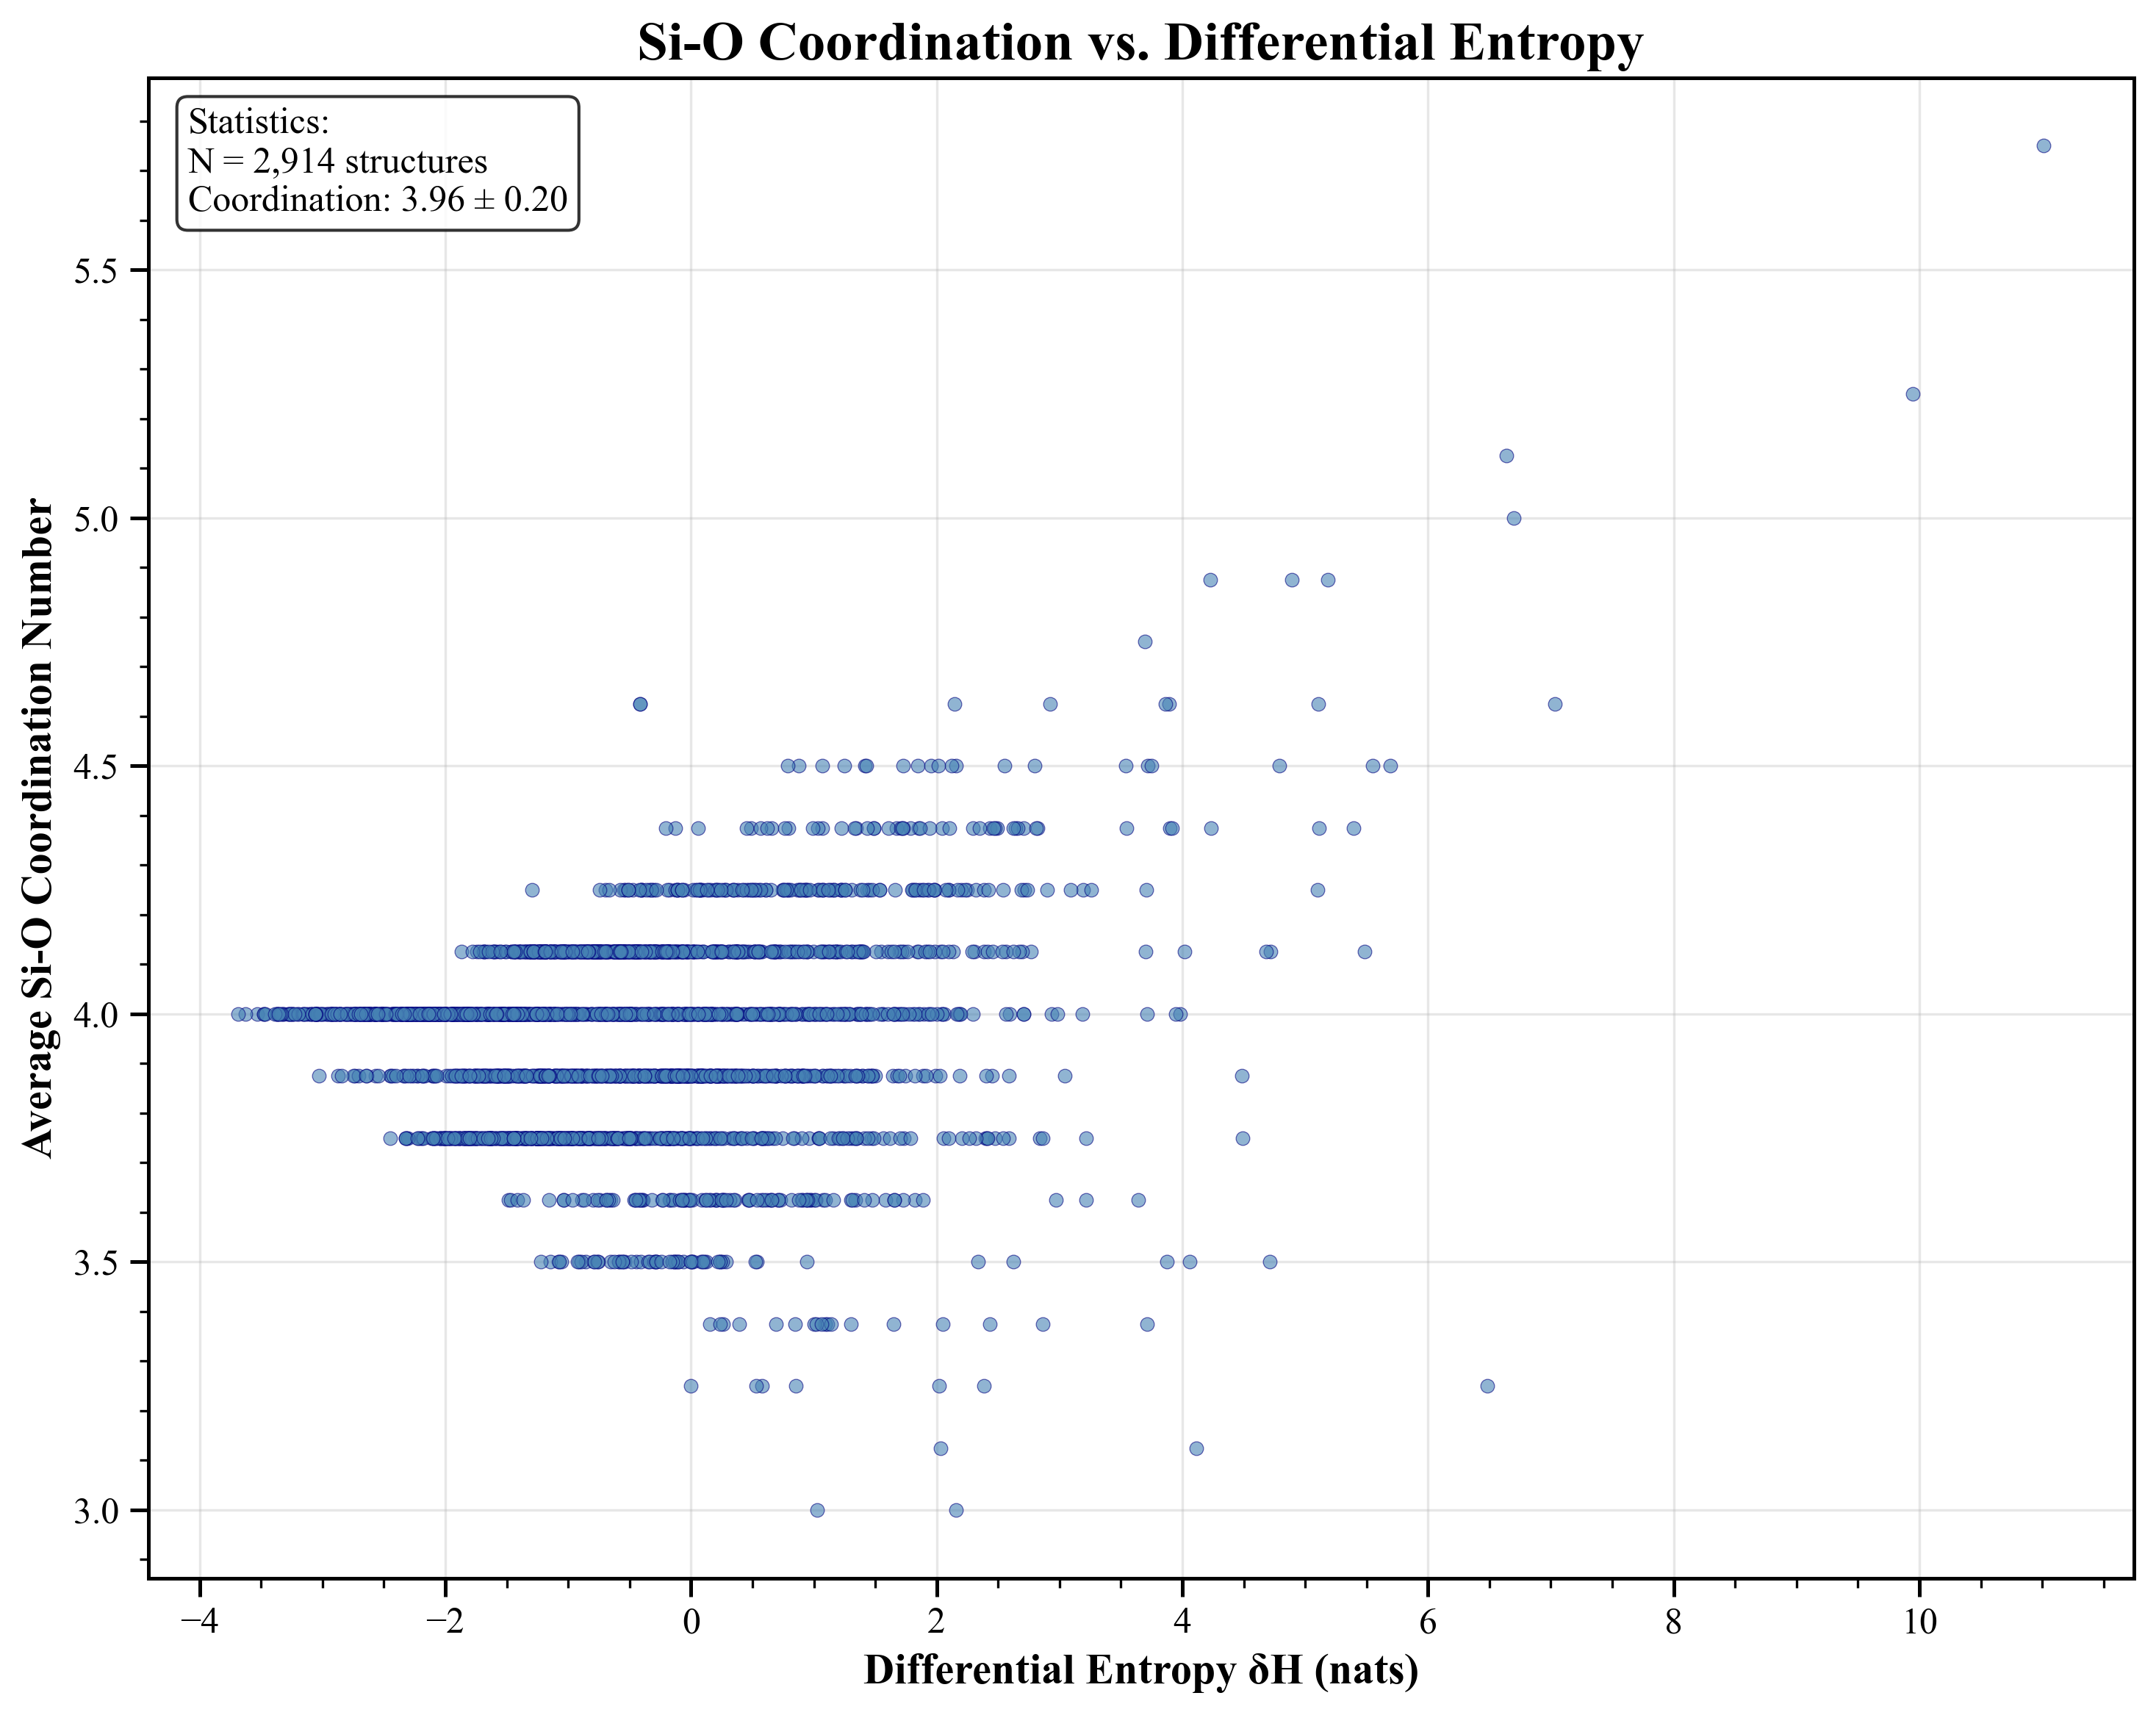


COORDINATION-ENTROPY ANALYSIS SUMMARY
Number of structures: 2,914
Average Si-O coordination: 3.955 ± 0.200
Average differential entropy: -0.490 ± 1.438 nats
Correlation coefficient: 0.195


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import src.rdf_v2 as rdf
import src.data_management_v2 as dm

# Set publication-quality plot parameters
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 2,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'font.family': 'serif',
    'text.usetex': False,      
})

def calculate_single_structure_coordination(struct_id, structure_dict, pair_type=('Si', 'O'), r_cutoff=2.5):
    """
    Calculate coordination number for a single structure.
    """
    # Fix: Access structure directly, not through ["structure"] key
    structure = structure_dict[struct_id]
    center_element, neighbor_element = pair_type
    
    # Find all center atoms (e.g., all Si atoms)
    center_sites = [site for site in structure.sites if site.specie.symbol == center_element]
    
    if not center_sites:
        return 0.0
    
    coordination_numbers = []
    
    for center_site in center_sites:
        # Get neighbors within cutoff distance
        neighbors = structure.get_neighbors(center_site, r_cutoff)
        
        # Count neighbors of the target element type
        coord_count = 0
        for neighbor_info in neighbors:
            neighbor_site = neighbor_info[0]
            if neighbor_site.specie.symbol == neighbor_element:
                coord_count += 1
        
        coordination_numbers.append(coord_count)
    
    # Return average coordination number for this structure
    return np.mean(coordination_numbers) if coordination_numbers else 0.0

def create_coordination_entropy_scatterplot(streak_results):
    """
    Create scatterplot of Si-O coordination number vs differential entropy.
    """
    # Extract data from streak_results
    energies = streak_results['energies_clean']
    entropies = streak_results['entropies_clean'] 
    struct_ids = streak_results['struct_ids_clean']
    
    print(f"Calculating Si-O coordination numbers for {len(struct_ids)} structures...")
    
    # Load structure data
    structure_dict = dm.load_structures(struct_ids.tolist())
    
    # Calculate coordination numbers for each structure
    coordination_numbers = []
    valid_entropies = []
    valid_struct_ids = []
    
    for i, struct_id in enumerate(struct_ids):
        if struct_id in structure_dict:
            coord_num = calculate_single_structure_coordination(
                struct_id, structure_dict, pair_type=('Si', 'O'), r_cutoff=2.5
            )
            coordination_numbers.append(coord_num)
            valid_entropies.append(entropies[i])
            valid_struct_ids.append(struct_id)
        
        if (i + 1) % 500 == 0:
            print(f"  Processed {i + 1}/{len(struct_ids)} structures...")
    
    coordination_numbers = np.array(coordination_numbers)
    valid_entropies = np.array(valid_entropies)
    
    print(f"Successfully calculated coordination for {len(coordination_numbers)} structures")
    print(f"Si-O coordination range: {coordination_numbers.min():.2f} - {coordination_numbers.max():.2f}")
    print(f"Differential entropy range: {valid_entropies.min():.3f} - {valid_entropies.max():.3f} nats")
    
    # Create the scatterplot
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Create scatter plot with some transparency and moderate point size
    scatter = ax.scatter(valid_entropies, coordination_numbers, 
                        alpha=0.6, s=20, c='steelblue', edgecolors='navy', linewidth=0.3)
    
    # Labels and title
    ax.set_xlabel('Differential Entropy δH (nats)', fontweight='bold')
    ax.set_ylabel('Average Si-O Coordination Number', fontweight='bold')
    ax.set_title('Si-O Coordination vs. Differential Entropy', fontweight='bold', fontsize=18)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    
    # Add minor ticks for professional look
    ax.tick_params(which='major', length=6, width=1.2)
    ax.tick_params(which='minor', length=3, width=0.8)
    ax.minorticks_on()
    
    # Add statistics text box
    stats_text = f"""Statistics:
N = {len(coordination_numbers):,} structures
Coordination: {coordination_numbers.mean():.2f} ± {coordination_numbers.std():.2f}"""
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("COORDINATION-ENTROPY ANALYSIS SUMMARY")
    print("="*60)
    print(f"Number of structures: {len(coordination_numbers):,}")
    print(f"Average Si-O coordination: {coordination_numbers.mean():.3f} ± {coordination_numbers.std():.3f}")
    print(f"Average differential entropy: {valid_entropies.mean():.3f} ± {valid_entropies.std():.3f} nats")
    print(f"Correlation coefficient: {np.corrcoef(valid_entropies, coordination_numbers)[0,1]:.3f}")
    
    return {
        'coordination_numbers': coordination_numbers,
        'differential_entropies': valid_entropies,
        'struct_ids': valid_struct_ids
    }

# Run the analysis (assuming streak_results is defined)
coordination_entropy_data = create_coordination_entropy_scatterplot(streak_results)